In [1]:
import sys
import math
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm, trange
from torchvision import datasets, transforms
from typing import List, Tuple
import matplotlib.pyplot as plt

sys.path.append('..')

from src.tools import beta_schedule

In [2]:
x0 = torch.randn(2, 3, 32, 32)
t = torch.tensor([1, 3])
betas = beta_schedule(0, 0.25, 20)

$\alpha_t = 1 - \beta_t$

In [3]:
alphas = 1 - betas
# amount of original information that is beign preserver after a diffussion process step 

$\overline{\alpha_t} = \prod_{i = 1}^{t} \alpha_i$

In [4]:
alpha_hat = torch.cumprod(alphas, 0) # cumprod is the cumulative product of elements of the tensor

In [5]:
t = torch.tensor([1, 3]) # list of indexes (time steps) to compute the alpha_hat

In [6]:
alpha_hat.size()

torch.Size([20])

In [7]:
x0.size()

torch.Size([2, 3, 32, 32])

In [8]:
result = alpha_hat.gather(axis=-1, index=t).reshape(-1, 1, 1, 1) # now it has 4 dimensions
# this returns the values of alpha_hat at the indexes of t

- $\mu = \sqrt{\hat{\alpha_t}} {x_0}$
- $variance = \sqrt{1 - \hat{\alpha_t}} {\epsilon}$

In [9]:
noise = torch.randn_like(x0)            # the values are drawn from a normal distribution with same dimensions as x0
mean = result.sqrt() * x0
variance = torch.sqrt(1 - result) * noise

In [10]:
print(mean.size())
print(variance.size())

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])


In [11]:
x_t = mean + variance

In [12]:
x_t[0]

tensor([[[ 0.7155,  0.9021, -0.0381,  ..., -1.9564,  0.5196,  0.5273],
         [-1.7844, -0.0385, -1.5961,  ..., -0.0263,  0.2992, -0.7182],
         [ 0.4629, -1.0472,  0.1884,  ..., -2.3181,  1.2767, -1.6987],
         ...,
         [-0.5507, -0.8426, -0.4024,  ...,  0.1150,  0.0485, -1.0934],
         [ 1.2688,  1.0795, -0.0954,  ...,  0.4954,  0.4117,  0.7207],
         [ 0.2212, -0.6239,  0.2137,  ...,  1.3947, -0.2700, -0.0144]],

        [[ 1.0283, -1.3555,  0.5635,  ...,  0.1201,  0.5390,  0.8783],
         [ 0.2637, -0.1254, -0.5718,  ..., -0.8804,  0.6654, -0.7182],
         [ 0.2966, -0.9311,  0.1504,  ..., -0.2355,  0.2287, -0.1395],
         ...,
         [ 0.9898, -0.7819,  0.1997,  ...,  1.2969, -0.2883, -0.0083],
         [ 1.2790,  0.4060,  0.6746,  ..., -0.4602,  1.2033, -0.6554],
         [ 0.7437,  0.0237, -0.6316,  ...,  0.2134,  0.3923,  0.0442]],

        [[-1.2943, -1.1719, -1.0262,  ...,  0.3968,  2.5155, -1.1870],
         [-0.9972, -1.3018,  0.3245,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


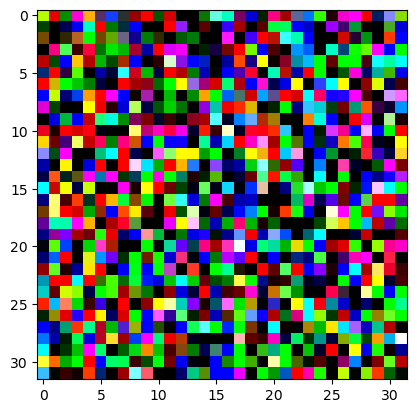

In [13]:
# plot the generated image

plt.imshow(x_t[0].permute(1, 2, 0).detach().numpy())
plt.show()

In [14]:
#https://rpruim.github.io/s341/S19/from-class/MathinRmd.html
# https://www.youtube.com/watch?v=S_il77Ttrmg

In [15]:
def forward_difussion(x0: torch.Tensor, t: torch.Tensor, betas: torch.Tensor):
    alphas = 1 - betas                      # amount of original information that is beign preserver after a diffussion process step
    alpha_hat = torch.cumprod(alphas, 0)    # cumprod is the cumulative product of elements of the tensor
    result = alpha_hat.gather(axis=-1, index=t).reshape(-1, 1, 1, 1) # now it has 4 dimensions
    noise = torch.randn_like(x0)            # the values are drawn from a normal distribution with same dimensions as x0
    mean = result.sqrt() * x0               # mean of the normal distribution
    variance = torch.sqrt(1 - result) * noise # variance of the normal distribution
    return mean + variance, noise             

In [16]:
data_set_root = '../data'

def normalize(x):
    return 2 * x - 1

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
    # scale the pixel values to the range of [-1, 1]
    transforms.Lambda(normalize)
])
trainset = datasets.FashionMNIST(data_set_root, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

In [17]:
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2), # denormalize to [0, 1]
    transforms.Lambda(lambda x: x.permute(1, 2, 0)),
    transforms.Lambda(lambda x: x*255.),
    # to cpu and np unint8
    transforms.Lambda(lambda x: x.cpu().numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

In [18]:
# get one sample
x0, _ = next(iter(train_loader))    

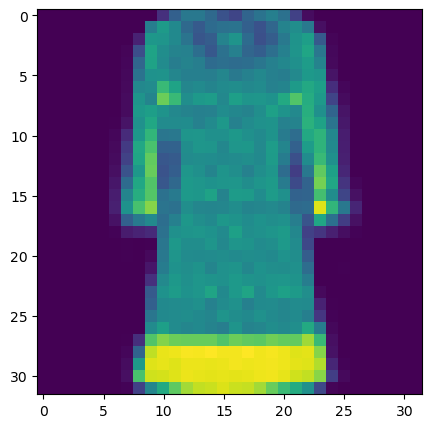

In [19]:
#show the image (figsize bigger than default)
plt.figure(figsize=(5, 5))
plt.imshow(reverse_transform(x0[0]))
plt.show()


In [20]:
t = torch.tensor([0,1,2,3,4])
batch_images = torch.stack([x0[0]] * len(t))
betas = beta_schedule(0, 0.01, 5, type='cosine')
noisy_images, _ = forward_difussion(batch_images, t, betas)

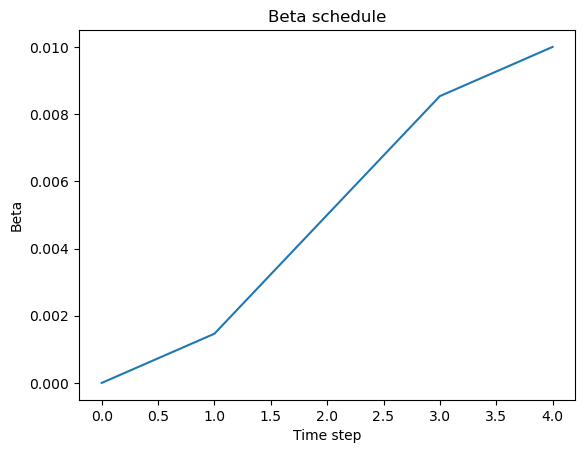

In [21]:
# plot betas
plt.plot(betas)
plt.xlabel('Time step')
plt.ylabel('Beta')
plt.title('Beta schedule')
plt.show()

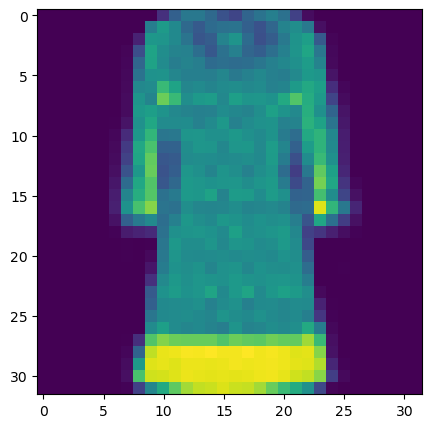

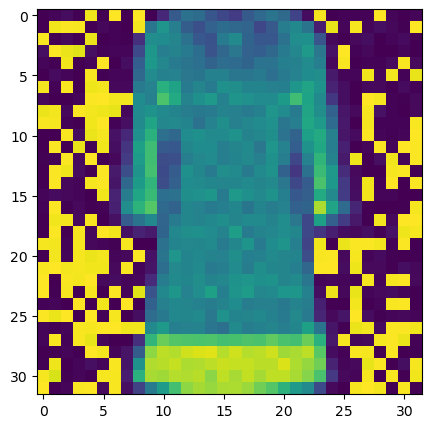

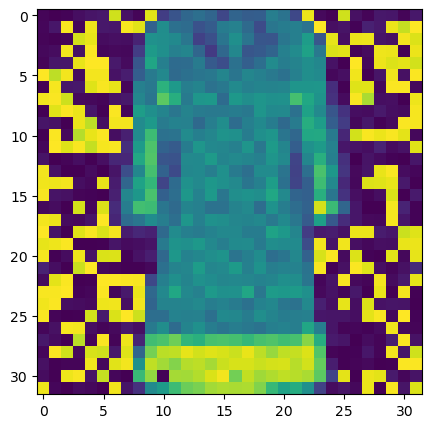

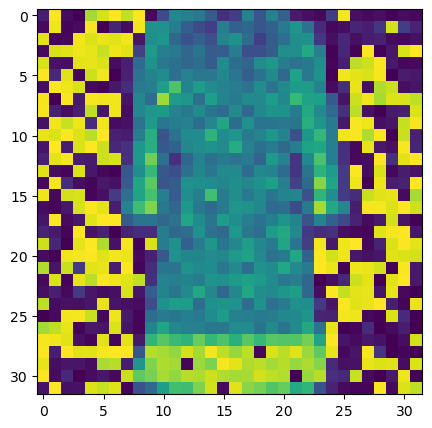

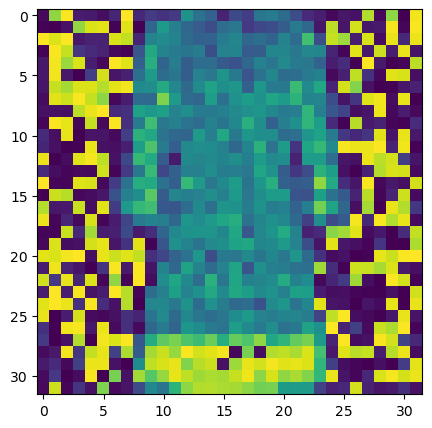

In [22]:
for img in noisy_images:
    plt.figure(figsize=(5, 5))
    plt.imshow(reverse_transform(img))
    plt.show()

In [23]:
class DifussionModel:
    def __init__(self, 
                 start_schedule:float=0.001, 
                 end_schedule:float=0.25, 
                 num_steps:int=20, type:str='linear'):

        self.betas = beta_schedule(
            start_schedule, 
            end_schedule, 
            num_steps,
            type=type
            )
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, 0)
    
    @torch.no_grad()
    def forward(self, x0: torch.Tensor, t: torch.Tensor, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        In the forward method we compute the forward diffusion process

        Args:
            - x0: torch.Tensor: the input tensor to be diffused (batch_size, channels, height, width)
            - t: torch.Tensor: the list of indexes (time steps) to compute the alpha_hat
            - device: torch.device: the device to use for the computation

        Returns:
            - torch.Tensor: the diffused tensor
            - torch.Tensor: the noise tensor
        """
        noise = torch.randn_like(x0, device=device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alpha_hat.sqrt(), t, x0.shape)
        sqrt_1_minus_alphas_cumprod_t = self.get_index_from_list((1 - self.alpha_hat).sqrt(), t, x0.shape)
        mean = sqrt_alphas_cumprod_t.to(device) * x0.to(device)
        variance = sqrt_1_minus_alphas_cumprod_t.to(device) * noise.to(device)
        return mean + variance, noise
    
    @staticmethod
    def get_index_from_list(values: torch.Tensor, t: torch.Tensor, x_shape: torch.Size):
        """
        This method returns the values of a tensor at the indexes of another tensor

        Args:
            - values: torch.Tensor: the tensor to extract the values from
            - t: torch.Tensor: the indexes tensor
            - x_shape: torch.Size: the shape of the output tensor
        
        Returns:
            - torch.Tensor: the tensor with the values at the indexes of t
        """
        batch_size = x_shape[0]
        result = values.gather(axis=-1, index=t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [24]:
IMAGE_SHAPE = 32

In [25]:
DM = DifussionModel(start_schedule=0.001, end_schedule=0.25, num_steps=20, type='linear')

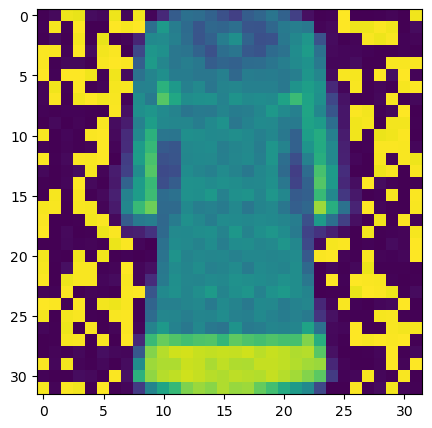

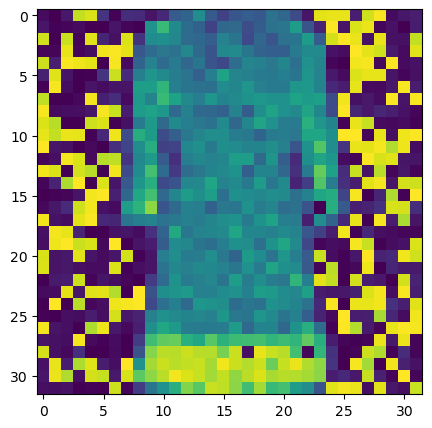

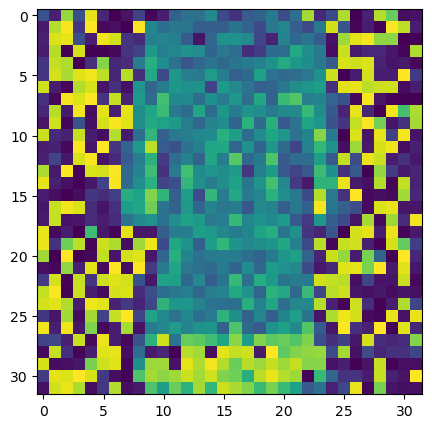

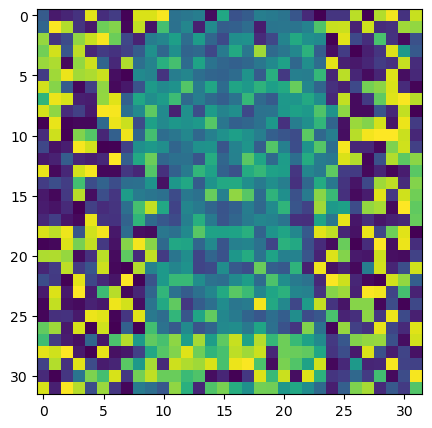

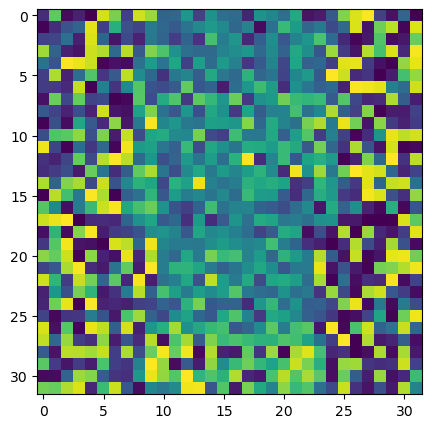

In [26]:
batch_images = torch.stack([x0[0]] * 5)
t = torch.tensor([0,1,2,3,4])
# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noisy_images, _ = DM.forward(batch_images, t, device=device)

for img in noisy_images:
    plt.figure(figsize=(5, 5))
    plt.imshow(reverse_transform(img))
    plt.show()

In [27]:
class ConditionalNorm2d(nn.Module):
    def __init__(self, channels, num_features, norm_type="gn"):
        super(ConditionalNorm2d, self).__init__()
        self.channels = channels
        if norm_type == "bn":
            self.norm = nn.BatchNorm2d(channels, affine=False, eps=1e-4)
        elif norm_type == "gn":
            self.norm = nn.GroupNorm(8, channels, affine=False, eps=1e-4)
        else:
            raise ValueError("Normalisation type not recognised.")

        self.fcw = nn.Linear(num_features, channels)
        self.fcb = nn.Linear(num_features, channels)

    def forward(self, x, features):
        out = self.norm(x)
        w = self.fcw(features)
        b = self.fcb(features)

        out = w.view(-1, self.channels, 1, 1) * out + b.view(-1, self.channels, 1, 1)
        return out


class ResDown(nn.Module):
    """
    Residual down sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=128):
        super(ResDown, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_out, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size, 1, kernel_size // 2)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.act_fnc(self.norm1(x, features))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResUp(nn.Module):
    """
    Residual up sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2, num_features=128):
        super(ResUp, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.up_nn(self.act_fnc(self.norm1(x, features)))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResBlock(nn.Module):
    """
    Residual block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=128):
        super(ResBlock, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)

        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        if not channel_in == channel_out:
            self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        else:
            self.conv3 = None

        self.act_fnc = nn.ELU()

    def forward(self, x_in, features):
        x = self.act_fnc(self.norm1(x_in, features))

        if self.conv3 is not None:
            skip = self.conv3(x)
        else:
            skip = x_in

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class Encoder(nn.Module):
    """
    Encoder block
    """

    def __init__(self, channels, ch=64, blocks=(1, 2, 4), num_features=128):
        super(Encoder, self).__init__()
        self.conv_in = nn.Conv2d(channels, blocks[0] * ch, 3, 1, 1)

        widths_in = list(blocks)
        widths_out = list(blocks[1:]) + [blocks[-1]]

        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResDown(w_in * ch, w_out * ch, num_features=num_features))

        self.block_out = ResBlock(w_out * ch, w_out * ch, num_features=num_features)

        self.act_fnc = nn.ELU()

    def forward(self, x, index_features):
        x = self.conv_in(x)
        skip_list = [x]

        for block in self.layer_blocks:
            x = block(x, index_features)
            skip_list.append(x)
        
        x = self.block_out(x, index_features)
        return x, skip_list


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=64, blocks=(1, 2, 4), num_features=128):
        super(Decoder, self).__init__()
        
        widths_out = list(blocks)[::-1]
        widths_in = (list(blocks[1:]) + [blocks[-1]])[::-1]

        self.block_in = ResBlock(blocks[-1] * ch, blocks[-1] * ch, num_features=num_features)
        
        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResUp(w_in * ch * 2, w_out * ch, num_features=num_features))

        self.conv_out = nn.Conv2d(blocks[0] * ch * 2, channels, 3, 1, 1)
        self.act_fnc = nn.ELU()

    def forward(self, x_in, skip_list, index_features):
        x = self.block_in(x_in, index_features)
        
        for block in self.layer_blocks:
            skip = skip_list.pop()
            x = torch.cat((x, skip), 1)
            x = block(x, index_features)
            
        skip = skip_list.pop()
        x = torch.cat((x, skip), 1)
        return self.conv_out(x)

    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class UNet(nn.Module):
    """
    Unet network, uses the above encoder and decoder blocks
    """
    def __init__(self, channel_in=3, ch=32, blocks=(1, 2, 4), timesteps=20, num_features=128):
        super(UNet, self).__init__()        
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(num_features),
            nn.Linear(num_features, 2 * num_features),
            nn.GELU(),
            nn.Linear(2 * num_features, num_features),
            nn.GELU()
        )
        
        self.encoder = Encoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)
        self.decoder = Decoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)
    
    def forward(self, x, index):
        index_features = self.time_mlp(index)
        
        bottleneck, skip_list = self.encoder(x, index_features)
        recon_img = self.decoder(bottleneck, skip_list, index_features)
        return recon_img

In [28]:
unet = UNet(channel_in=1)

NO_EPOCHS = 100
LR = 1e-3
BATCH_SIZE = 64
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

Epoch 1/100:   0%|          | 0/100 [00:01<?, ?it/s, loss=0.479]

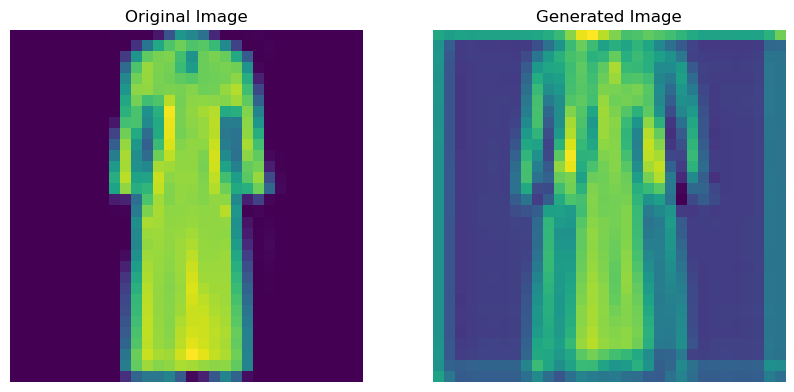

Epoch 1/100:   0%|          | 0/100 [00:10<?, ?it/s, loss=0.000101]

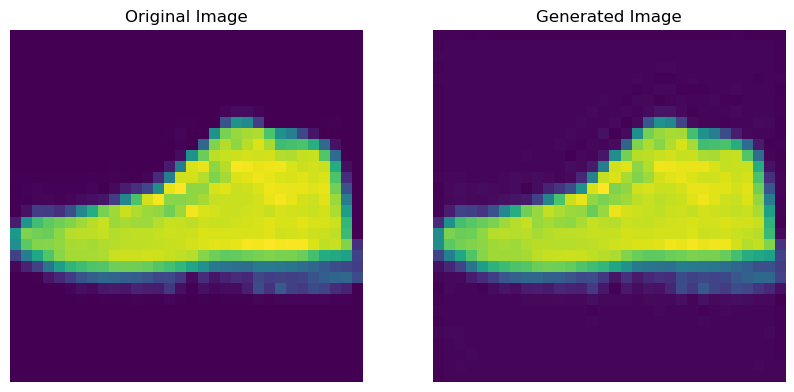

Epoch 2/100:   1%|          | 1/100 [00:18<31:01, 18.80s/it, loss=4e-5]   

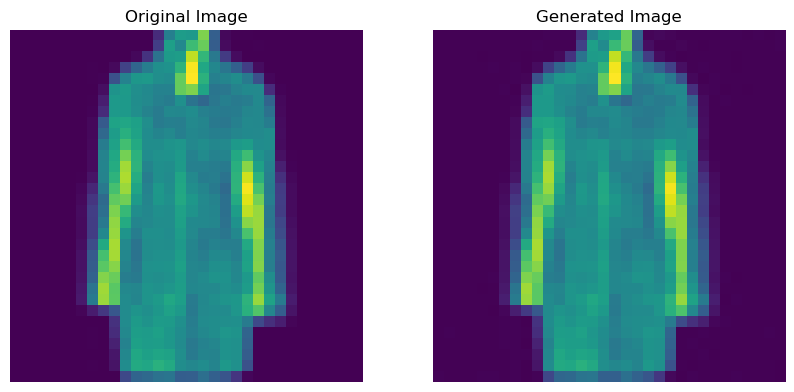

Epoch 2/100:   1%|          | 1/100 [00:27<31:01, 18.80s/it, loss=1.67e-5]

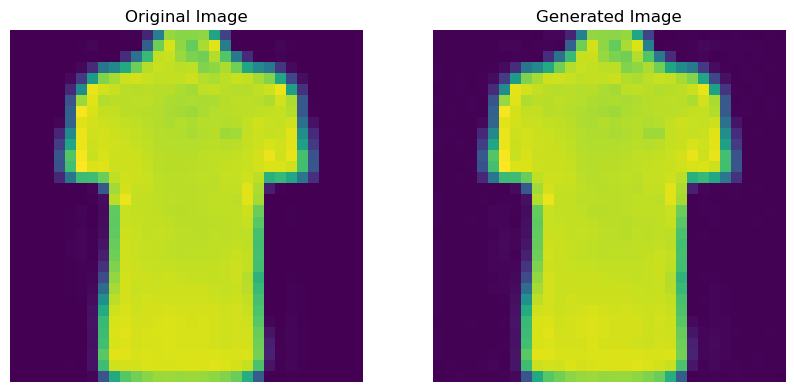

Epoch 3/100:   2%|▏         | 2/100 [00:36<29:11, 17.87s/it, loss=1.17e-5]

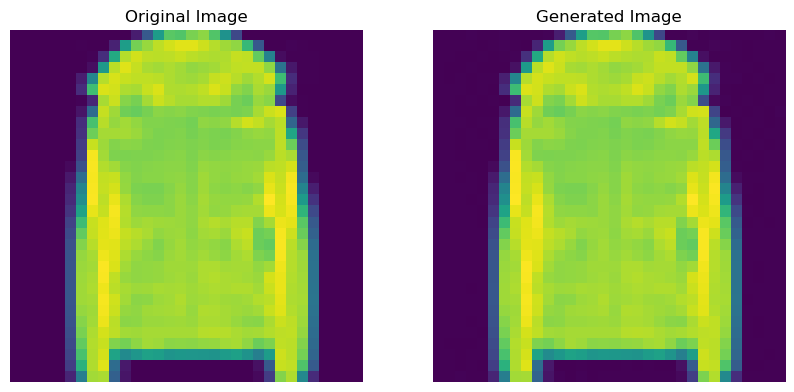

Epoch 3/100:   2%|▏         | 2/100 [00:45<29:11, 17.87s/it, loss=1.05e-5]

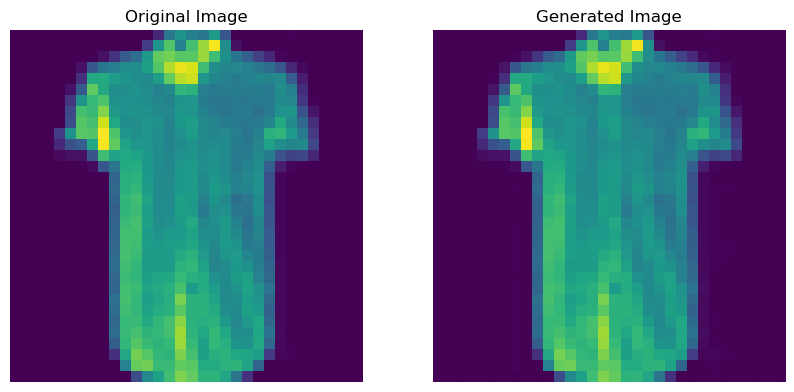

Epoch 4/100:   3%|▎         | 3/100 [00:53<28:22, 17.55s/it, loss=0.00345] 

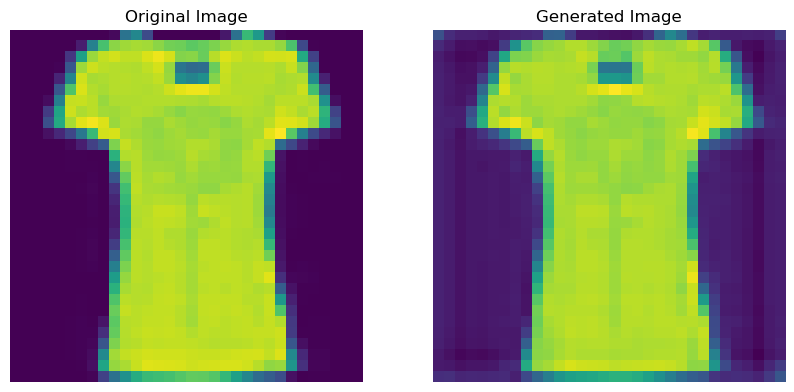

Epoch 4/100:   3%|▎         | 3/100 [01:02<28:22, 17.55s/it, loss=0.00138]

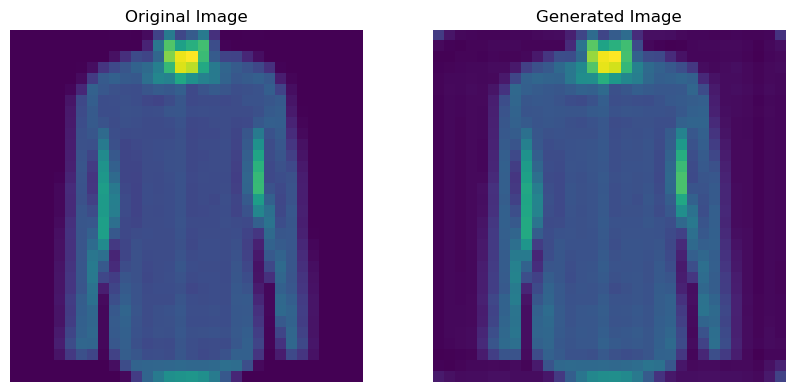

Epoch 5/100:   4%|▍         | 4/100 [01:10<27:49, 17.39s/it, loss=0.000735]

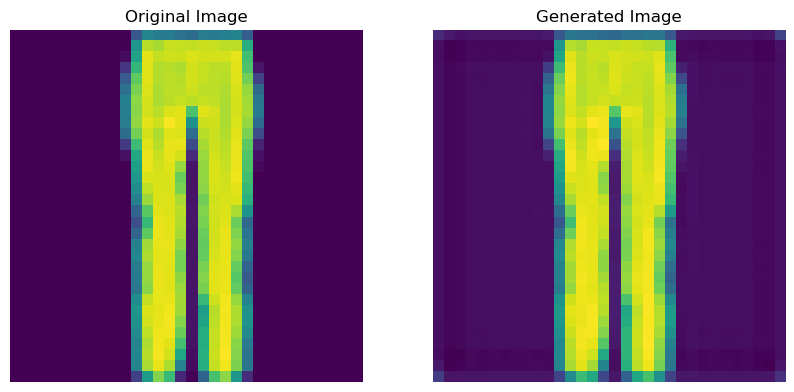

Epoch 5/100:   4%|▍         | 4/100 [01:19<27:49, 17.39s/it, loss=0.000481]

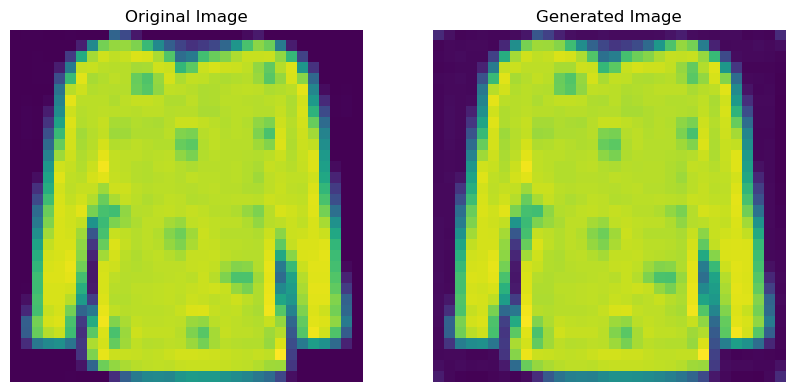

Epoch 6/100:   5%|▌         | 5/100 [01:27<27:21, 17.28s/it, loss=0.000382]

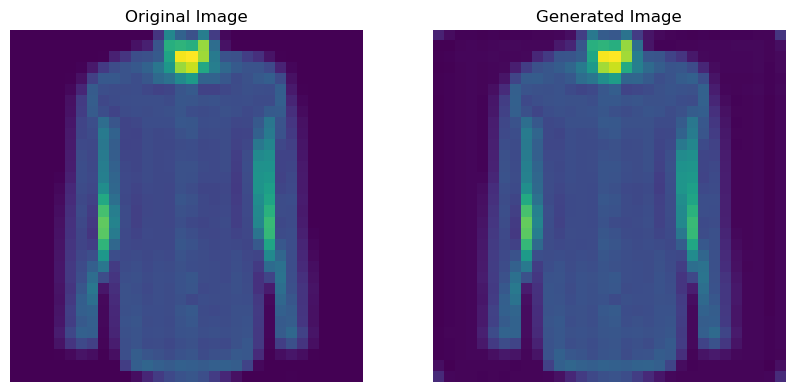

Epoch 6/100:   5%|▌         | 5/100 [01:36<27:21, 17.28s/it, loss=0.000317]

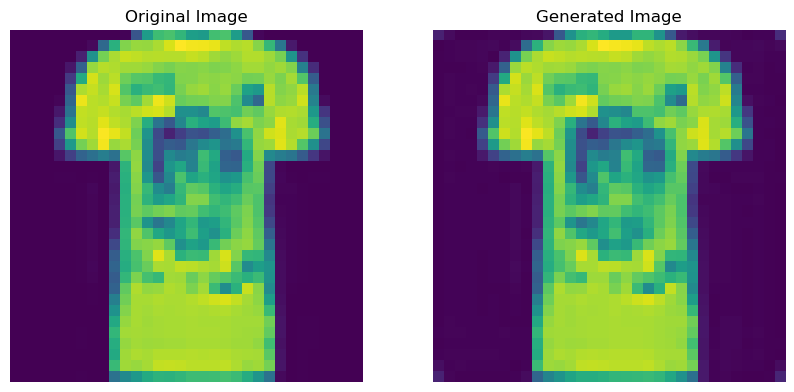

Epoch 7/100:   6%|▌         | 6/100 [01:44<26:54, 17.18s/it, loss=0.000407]

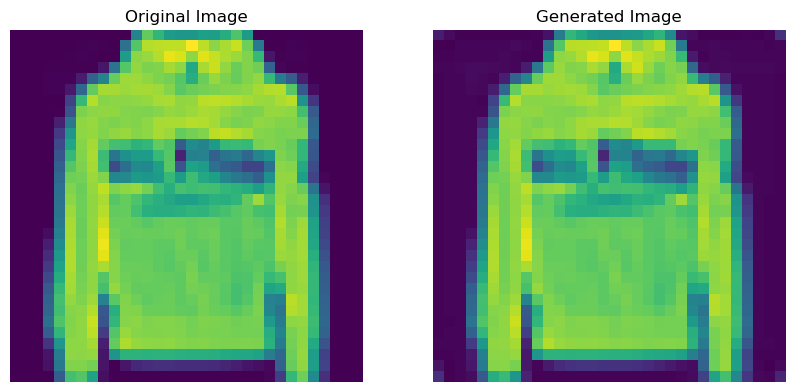

Epoch 7/100:   6%|▌         | 6/100 [01:53<26:54, 17.18s/it, loss=0.000232]

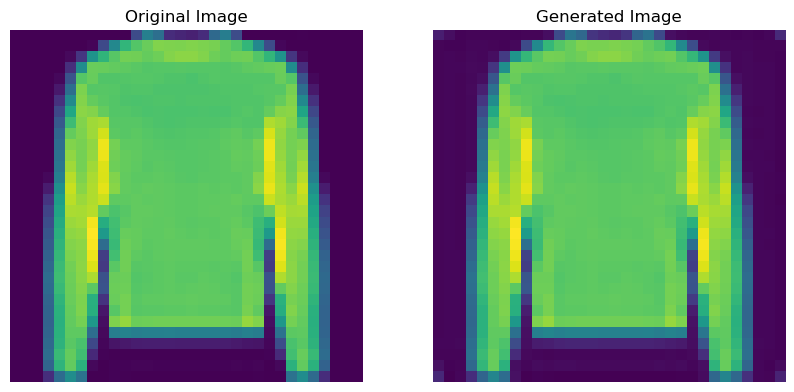

Epoch 8/100:   7%|▋         | 7/100 [02:01<26:30, 17.10s/it, loss=0.000824]

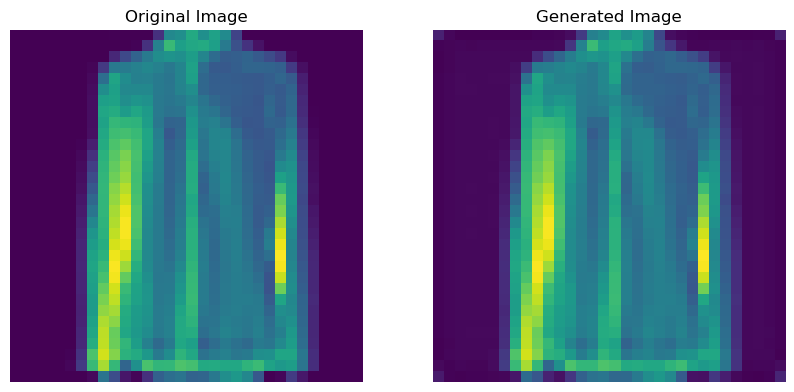

Epoch 8/100:   7%|▋         | 7/100 [02:10<26:30, 17.10s/it, loss=0.000171]

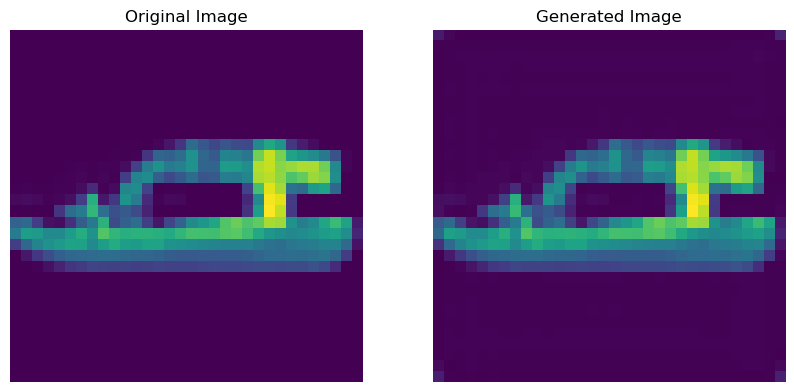

Epoch 9/100:   8%|▊         | 8/100 [02:18<26:12, 17.09s/it, loss=0.000149]

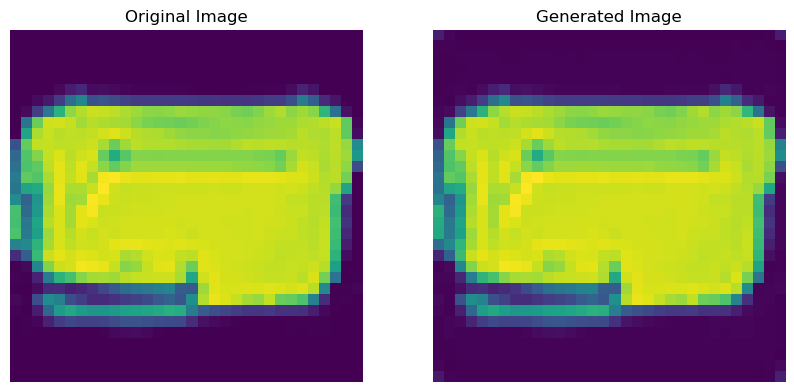

Epoch 9/100:   8%|▊         | 8/100 [02:27<26:12, 17.09s/it, loss=0.000112]

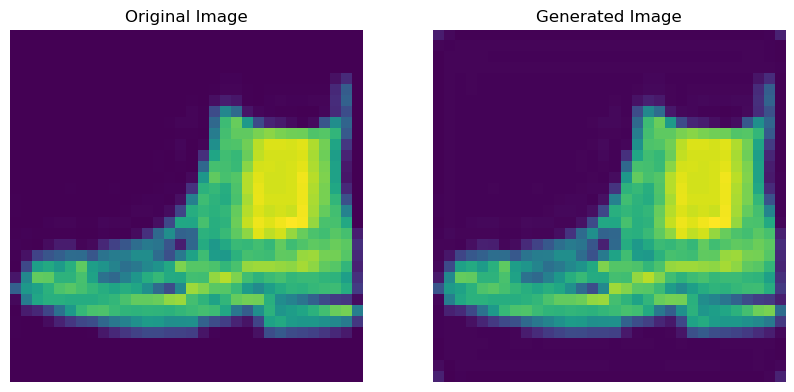

Epoch 10/100:   9%|▉         | 9/100 [02:35<25:54, 17.09s/it, loss=0.000104]

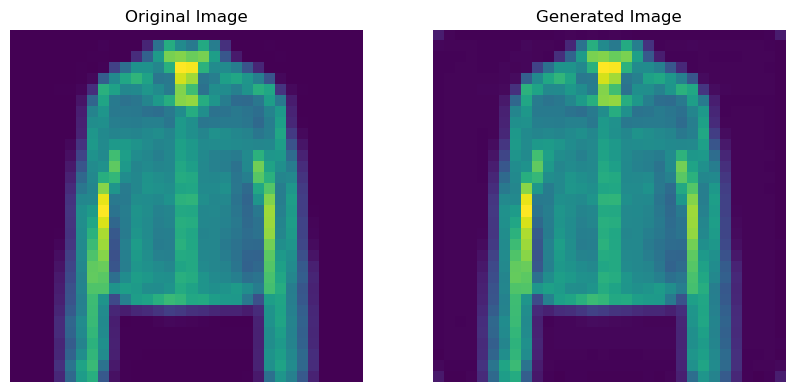

Epoch 10/100:   9%|▉         | 9/100 [02:44<25:54, 17.09s/it, loss=0.000779]

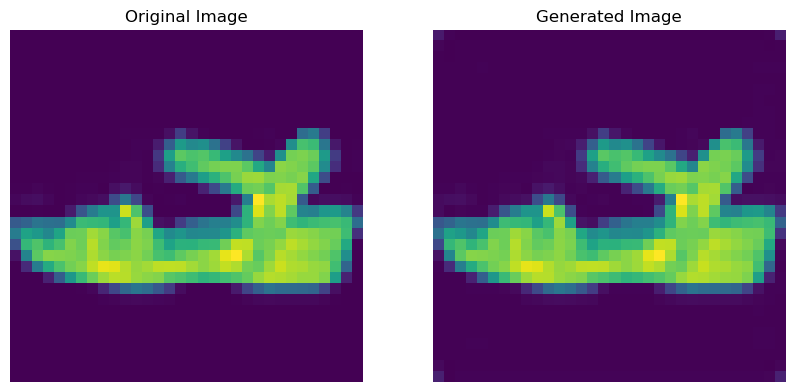

Epoch 11/100:  10%|█         | 10/100 [02:52<25:37, 17.08s/it, loss=6.16e-5]

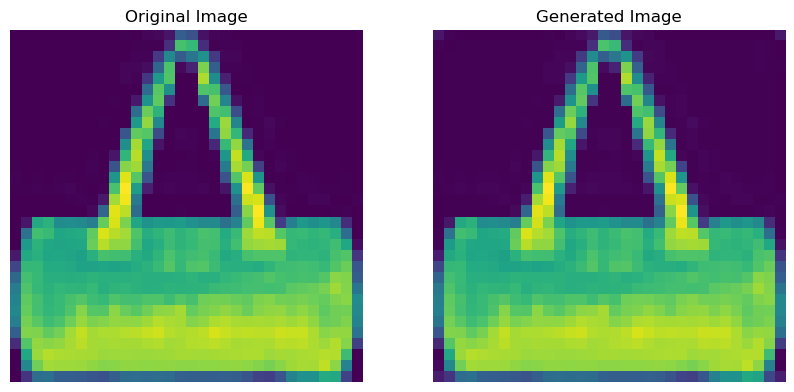

Epoch 11/100:  10%|█         | 10/100 [03:01<25:37, 17.08s/it, loss=9.06e-5] 

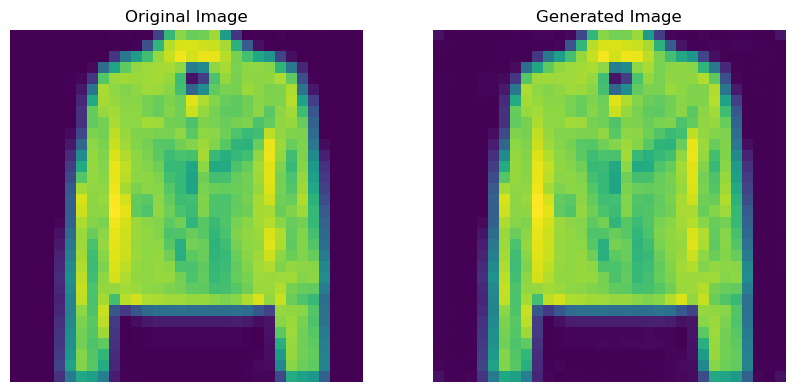

Epoch 12/100:  11%|█         | 11/100 [03:09<25:15, 17.03s/it, loss=3.36e-5] 

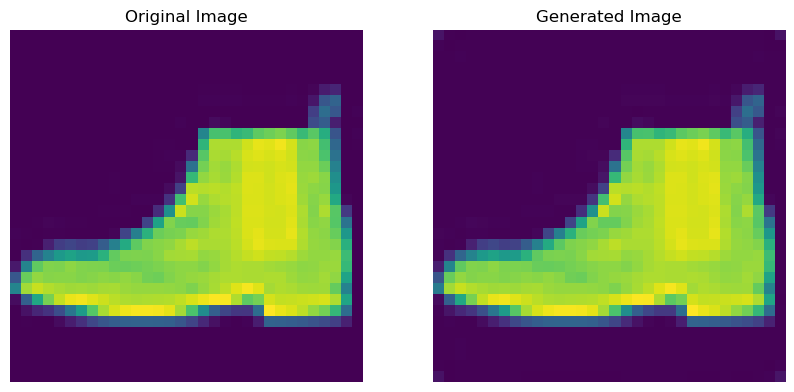

Epoch 12/100:  11%|█         | 11/100 [03:18<25:15, 17.03s/it, loss=2.5e-5]  

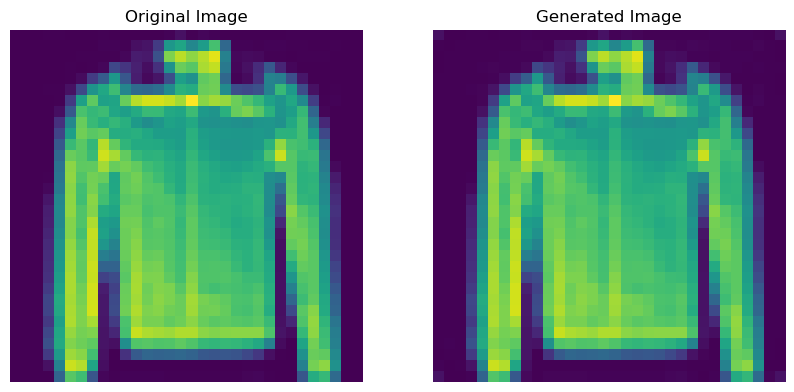

Epoch 13/100:  12%|█▏        | 12/100 [03:26<24:56, 17.00s/it, loss=1.64e-5]

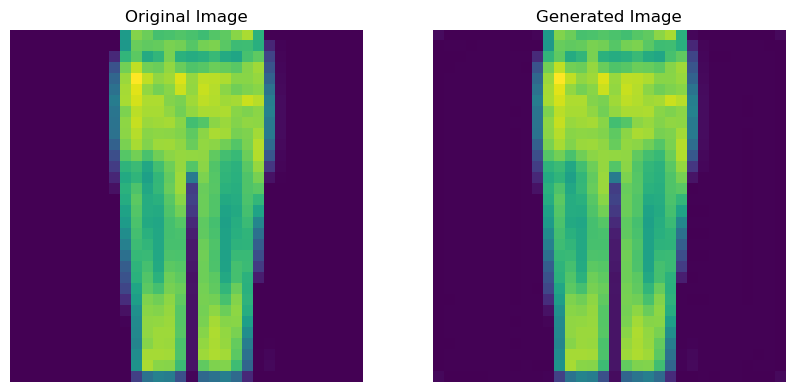

Epoch 13/100:  12%|█▏        | 12/100 [03:35<24:56, 17.00s/it, loss=1.39e-5] 

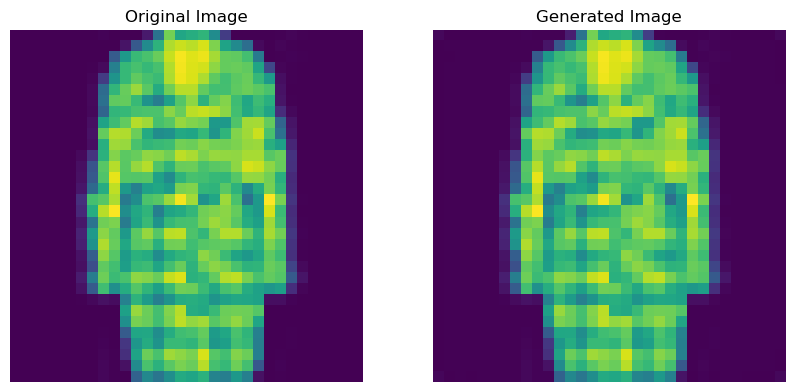

Epoch 14/100:  13%|█▎        | 13/100 [03:43<24:39, 17.00s/it, loss=8.91e-6] 

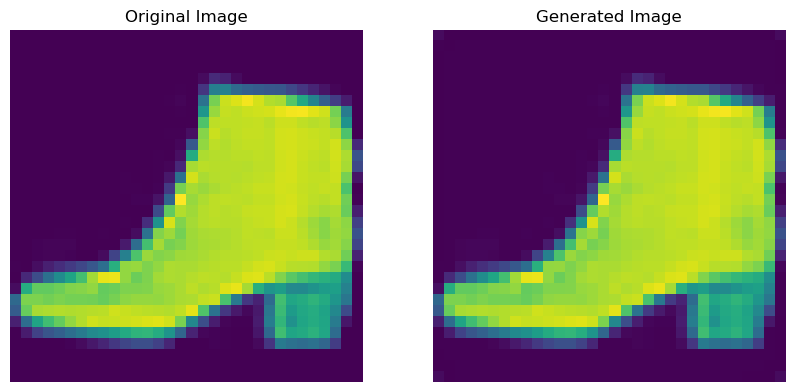

Epoch 14/100:  13%|█▎        | 13/100 [03:52<24:39, 17.00s/it, loss=2.34e-5] 

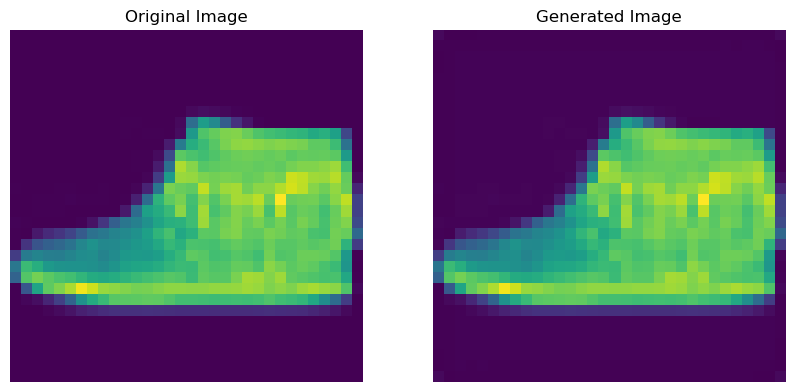

Epoch 15/100:  14%|█▍        | 14/100 [04:00<24:22, 17.00s/it, loss=1.56e-5] 

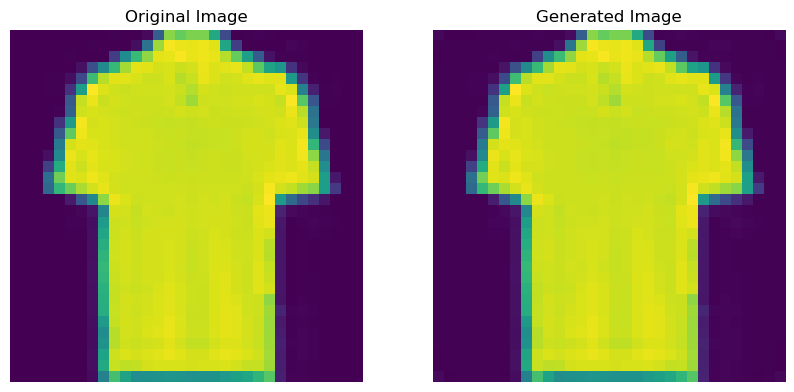

Epoch 15/100:  14%|█▍        | 14/100 [04:09<24:22, 17.00s/it, loss=2.88e-6] 

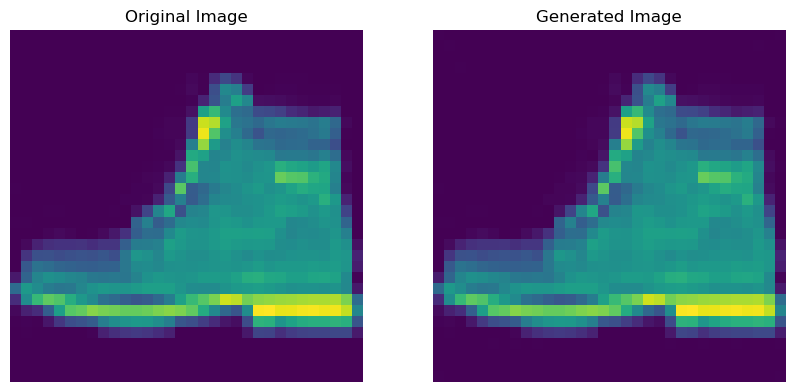

Epoch 16/100:  15%|█▌        | 15/100 [04:17<24:07, 17.03s/it, loss=1.98e-6] 

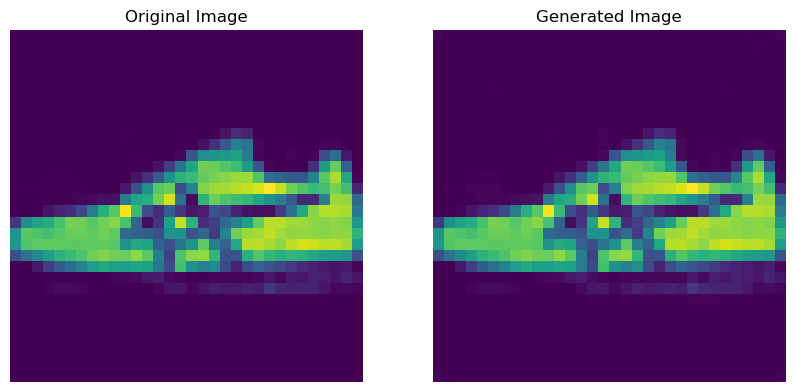

Epoch 16/100:  15%|█▌        | 15/100 [04:26<24:07, 17.03s/it, loss=1.87e-5] 

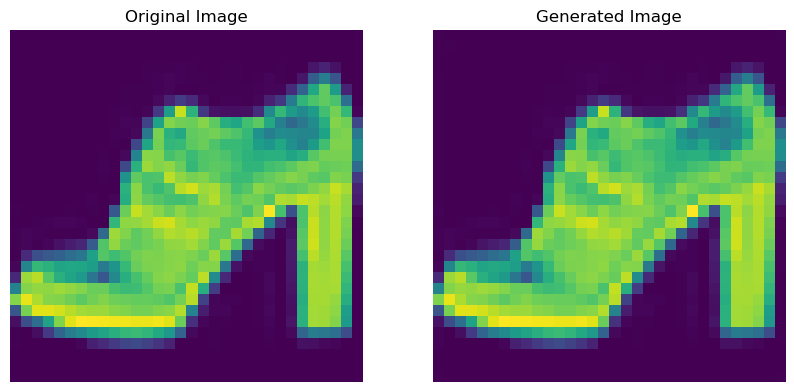

Epoch 17/100:  16%|█▌        | 16/100 [04:34<23:52, 17.06s/it, loss=1.09e-6] 

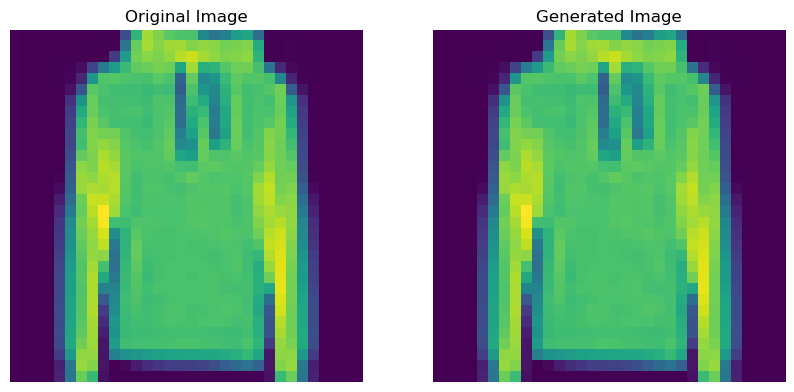

Epoch 17/100:  16%|█▌        | 16/100 [04:43<23:52, 17.06s/it, loss=9.66e-7] 

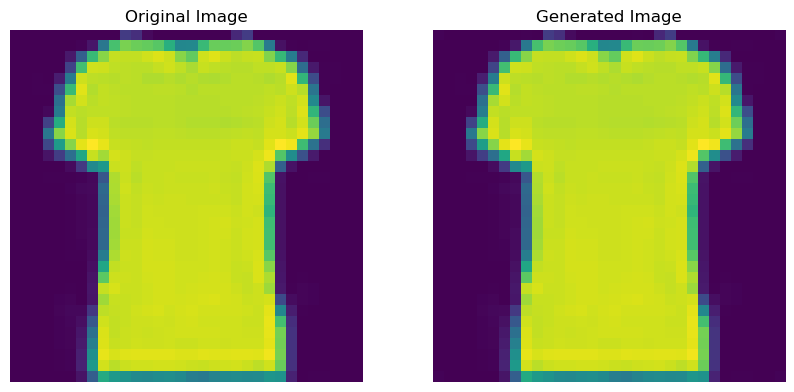

Epoch 18/100:  17%|█▋        | 17/100 [04:51<23:38, 17.09s/it, loss=5.57e-7] 

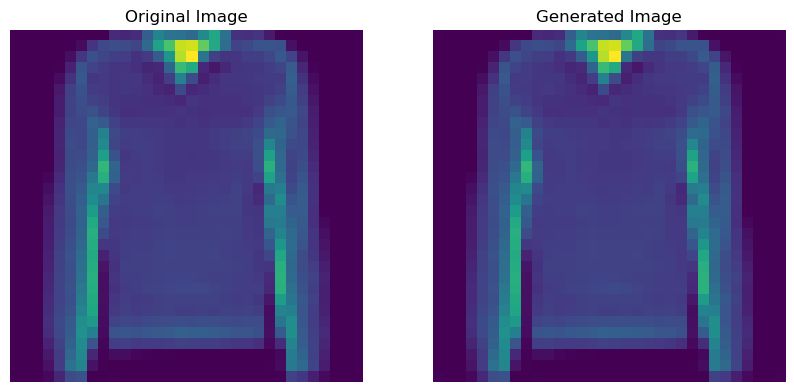

Epoch 18/100:  17%|█▋        | 17/100 [05:01<23:38, 17.09s/it, loss=9.29e-7] 

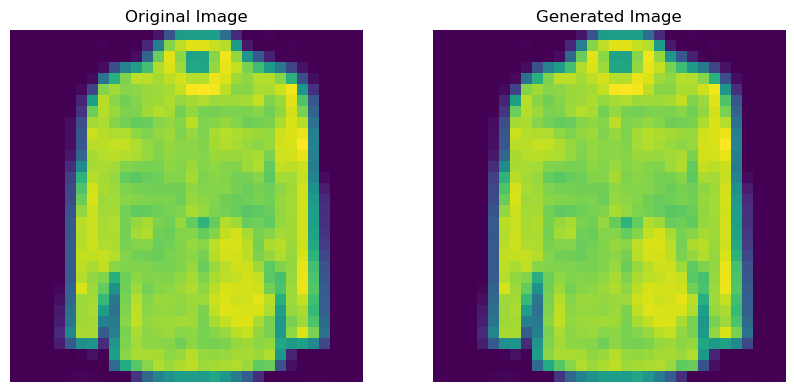

Epoch 19/100:  18%|█▊        | 18/100 [05:09<23:25, 17.14s/it, loss=3.97e-6] 

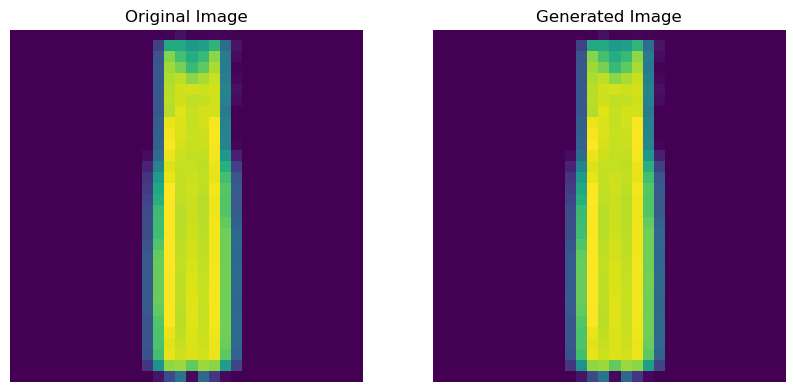

Epoch 19/100:  18%|█▊        | 18/100 [05:18<23:25, 17.14s/it, loss=2.77e-7] 

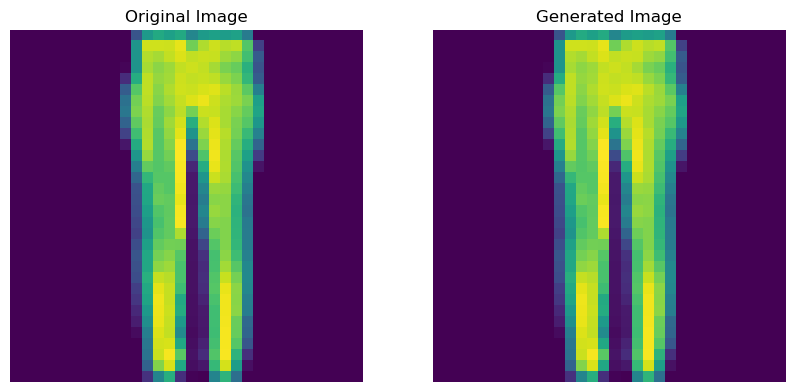

Epoch 20/100:  19%|█▉        | 19/100 [05:25<23:01, 17.06s/it, loss=5.38e-7] 

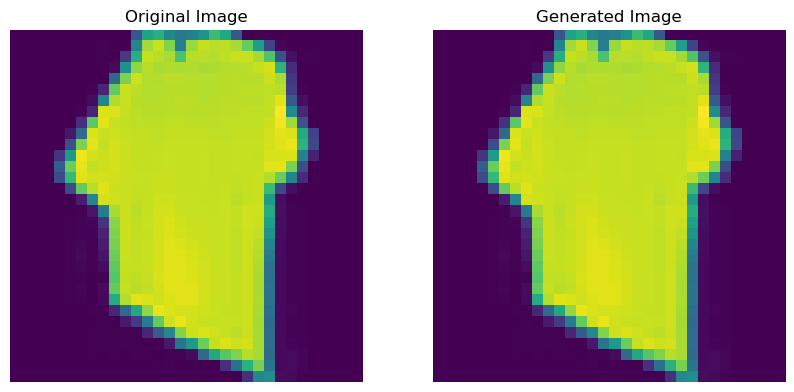

Epoch 20/100:  19%|█▉        | 19/100 [05:34<23:01, 17.06s/it, loss=8.14e-7]

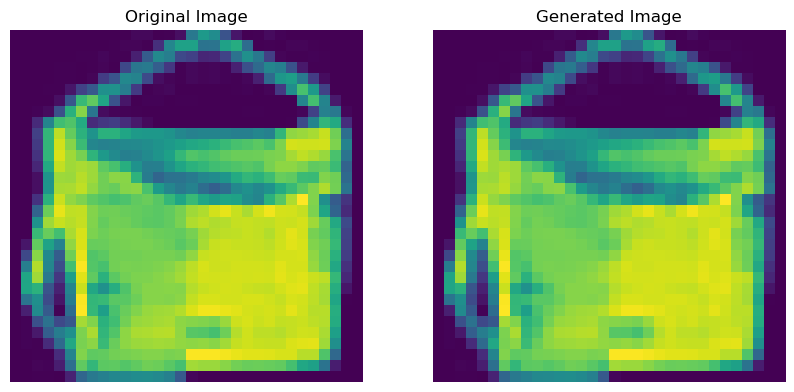

Epoch 21/100:  20%|██        | 20/100 [05:42<22:38, 16.98s/it, loss=5.47e-7]

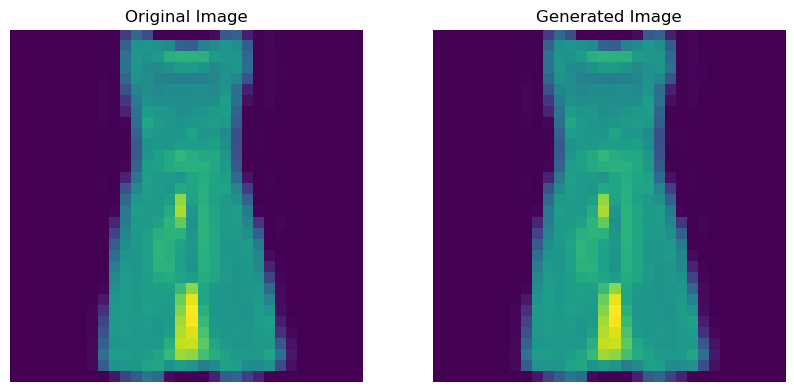

Epoch 21/100:  20%|██        | 20/100 [05:51<22:38, 16.98s/it, loss=5.23e-7] 

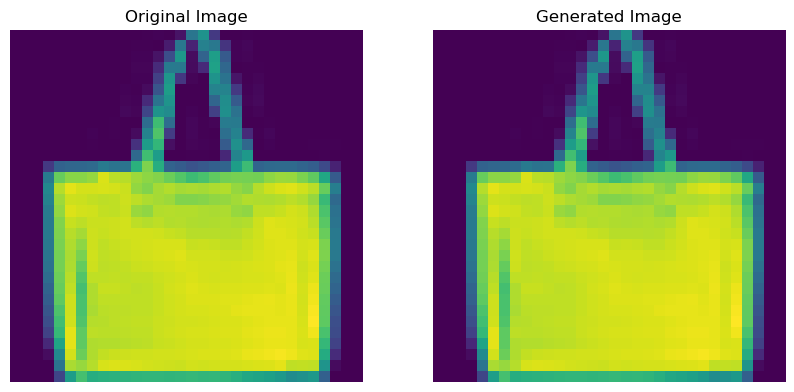

Epoch 22/100:  21%|██        | 21/100 [05:59<22:16, 16.92s/it, loss=5.41e-7] 

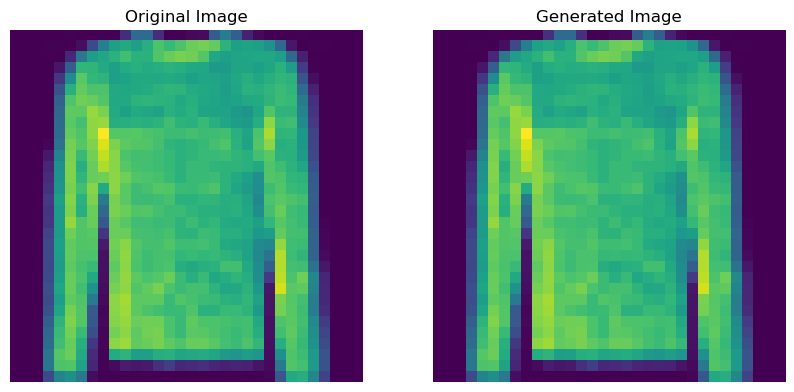

Epoch 22/100:  21%|██        | 21/100 [06:08<22:16, 16.92s/it, loss=5.57e-8] 

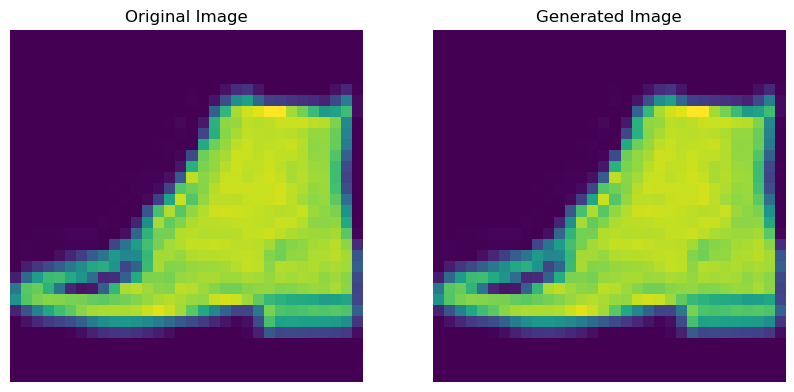

Epoch 23/100:  22%|██▏       | 22/100 [06:16<21:55, 16.87s/it, loss=5.8e-7]  

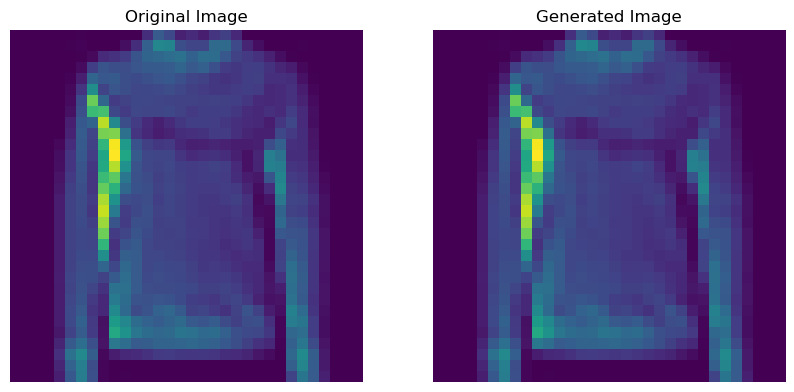

Epoch 23/100:  22%|██▏       | 22/100 [06:25<21:55, 16.87s/it, loss=4.25e-7]

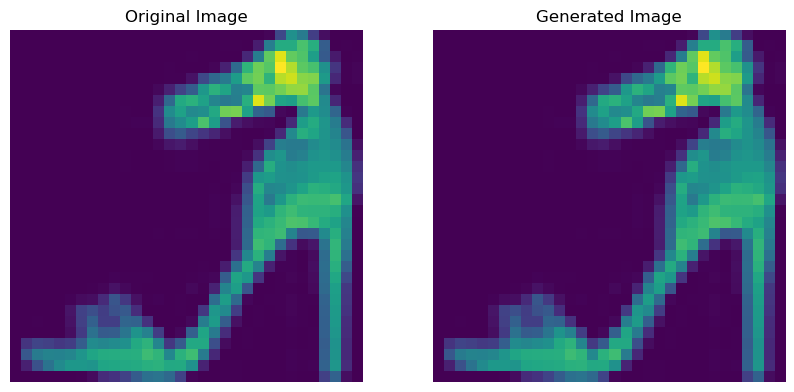

Epoch 24/100:  23%|██▎       | 23/100 [06:33<21:36, 16.84s/it, loss=2.5e-5]  

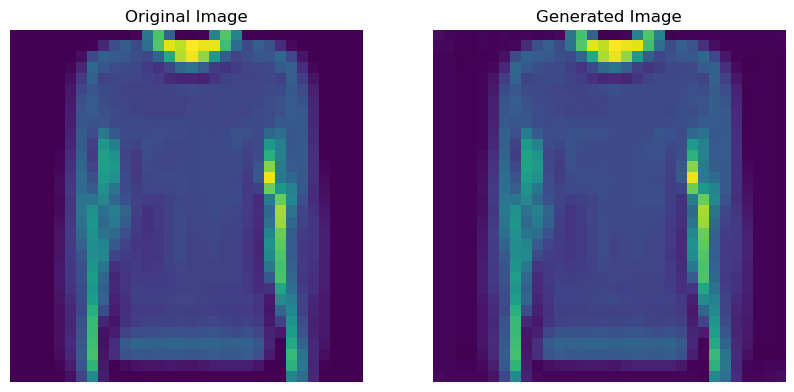

Epoch 24/100:  23%|██▎       | 23/100 [06:41<21:36, 16.84s/it, loss=9.25e-6]

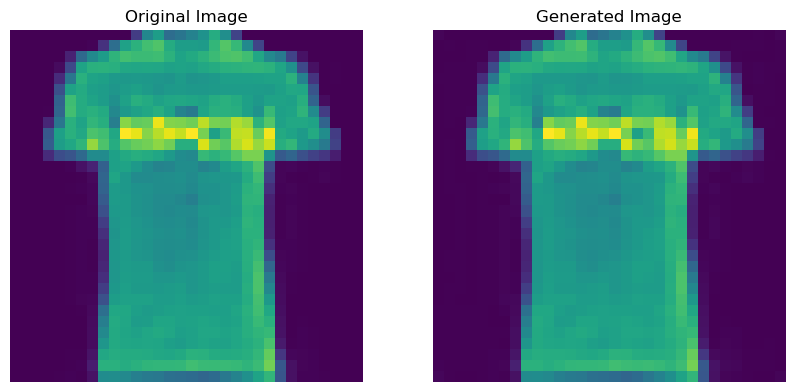

Epoch 25/100:  24%|██▍       | 24/100 [06:49<21:19, 16.83s/it, loss=6.37e-6]

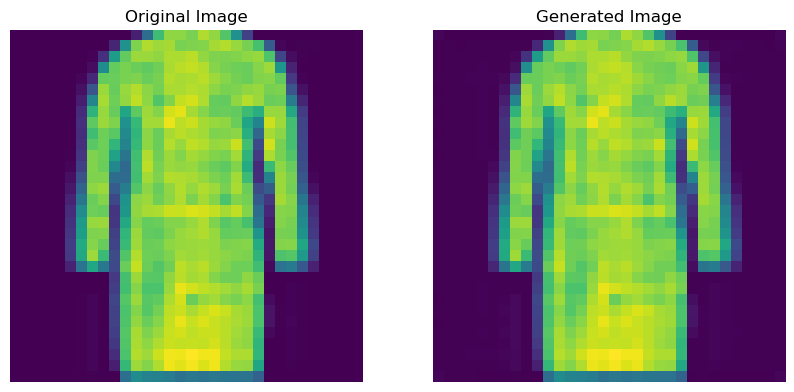

Epoch 25/100:  24%|██▍       | 24/100 [06:58<21:19, 16.83s/it, loss=4.36e-6]

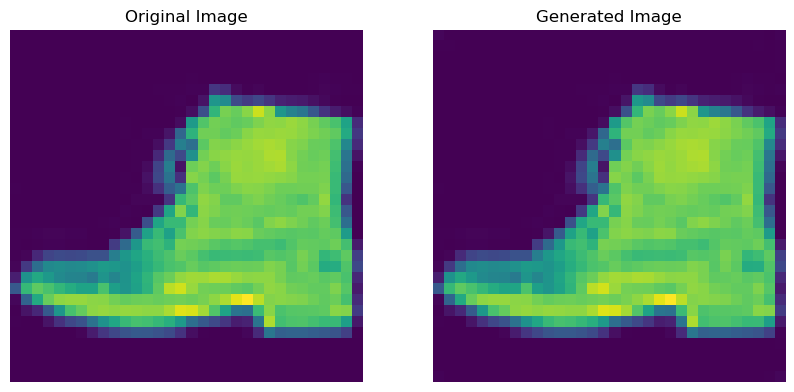

Epoch 26/100:  25%|██▌       | 25/100 [07:06<21:03, 16.84s/it, loss=3.62e-6]

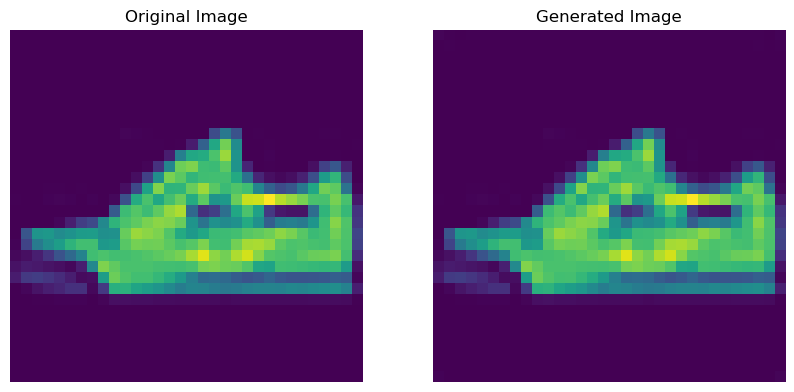

Epoch 26/100:  25%|██▌       | 25/100 [07:15<21:03, 16.84s/it, loss=2.65e-6]

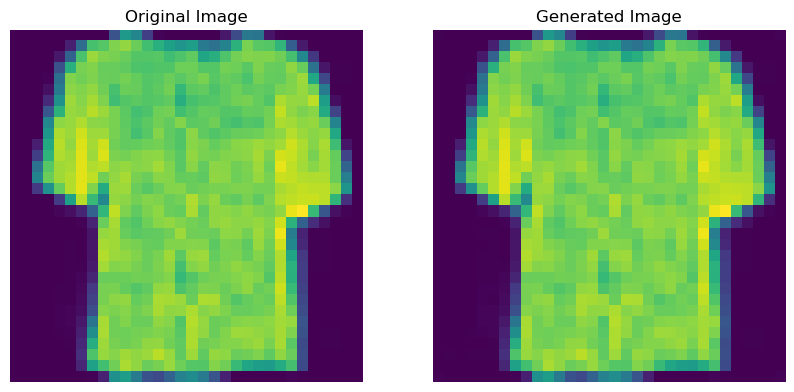

Epoch 27/100:  26%|██▌       | 26/100 [07:23<20:44, 16.82s/it, loss=2.05e-6]

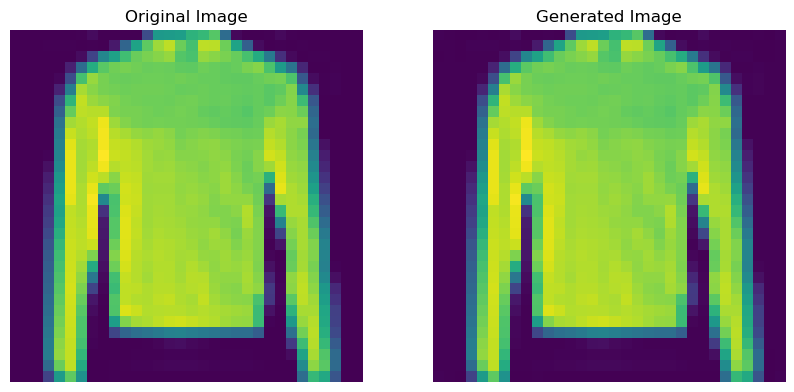

Epoch 27/100:  26%|██▌       | 26/100 [07:32<20:44, 16.82s/it, loss=1.52e-6]

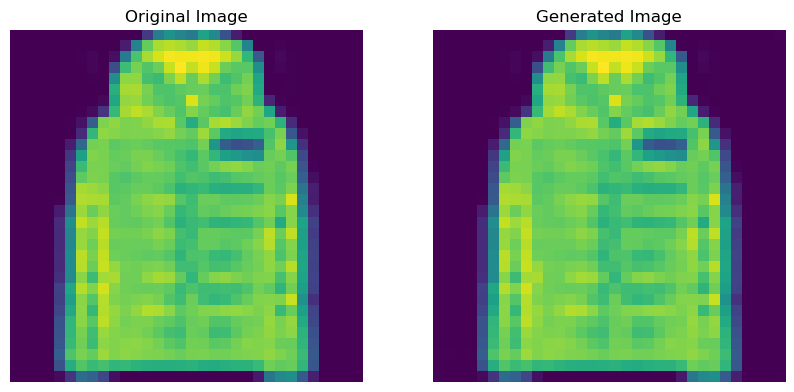

Epoch 28/100:  27%|██▋       | 27/100 [07:40<20:25, 16.79s/it, loss=1.33e-6]

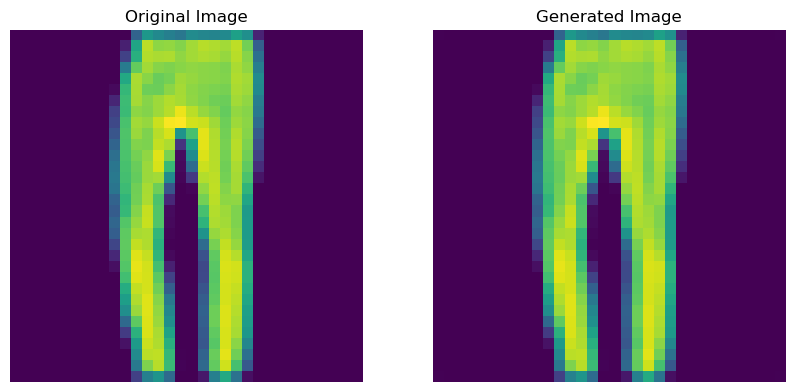

Epoch 28/100:  27%|██▋       | 27/100 [07:49<20:25, 16.79s/it, loss=9.19e-7]

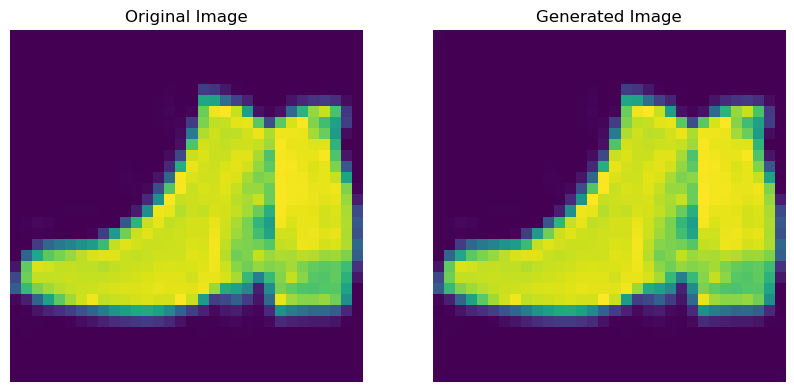

Epoch 29/100:  28%|██▊       | 28/100 [07:56<20:07, 16.77s/it, loss=7.83e-7]

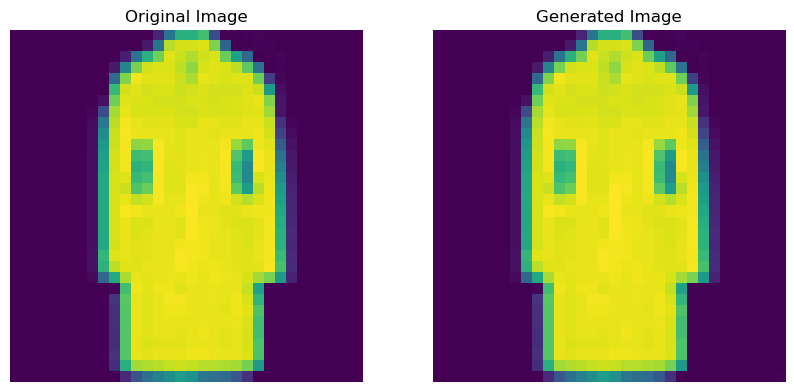

Epoch 29/100:  28%|██▊       | 28/100 [08:05<20:07, 16.77s/it, loss=6.97e-7]

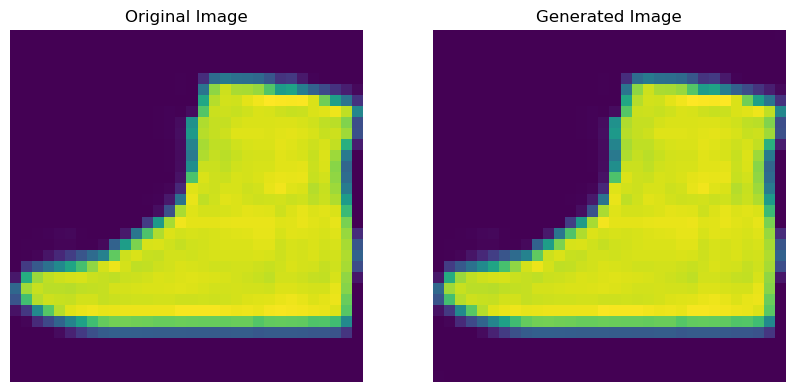

Epoch 30/100:  29%|██▉       | 29/100 [08:13<19:50, 16.76s/it, loss=1.29e-6] 

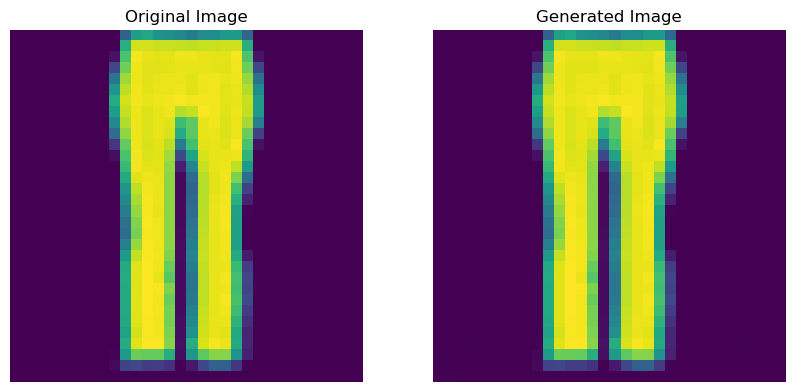

Epoch 30/100:  29%|██▉       | 29/100 [08:22<19:50, 16.76s/it, loss=3.53e-5] 

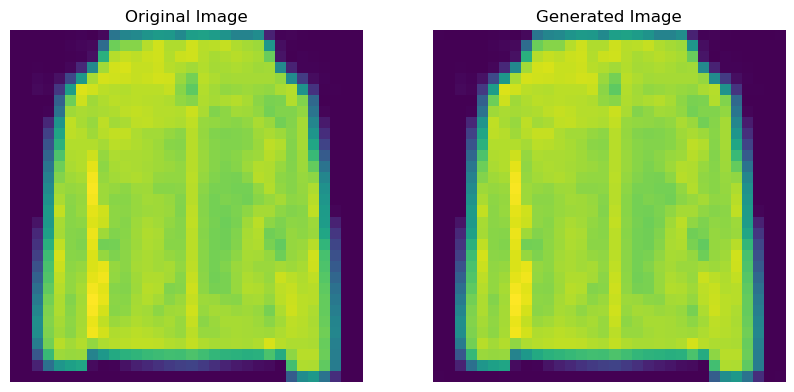

Epoch 31/100:  30%|███       | 30/100 [08:30<19:38, 16.83s/it, loss=4.33e-7]

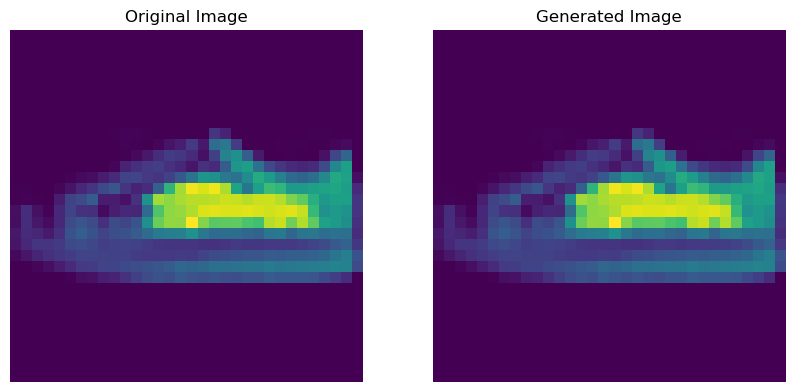

Epoch 31/100:  30%|███       | 30/100 [08:39<19:38, 16.83s/it, loss=3.06e-6]

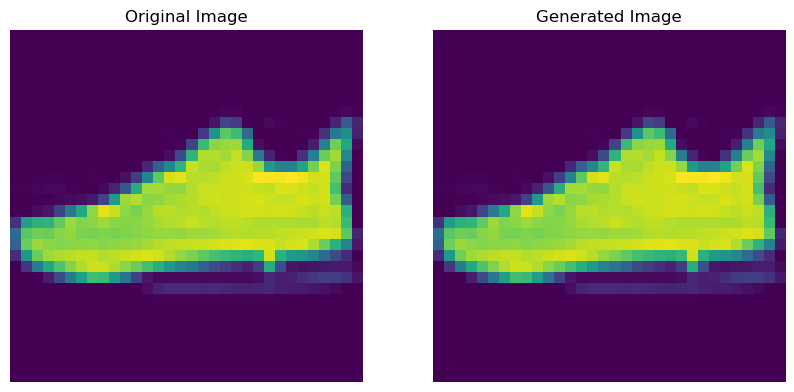

Epoch 32/100:  31%|███       | 31/100 [08:47<19:26, 16.91s/it, loss=1.23e-5] 

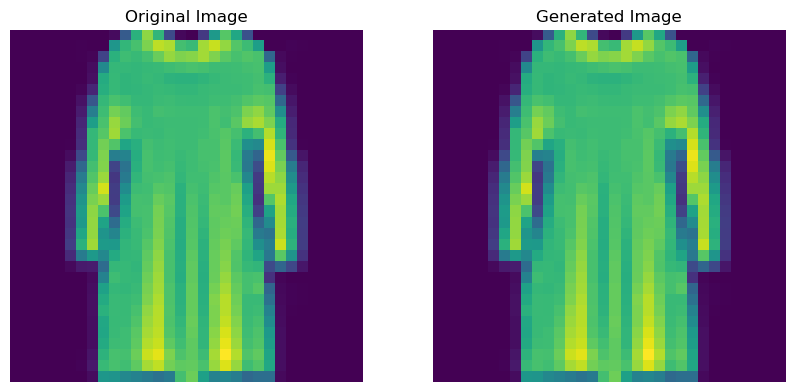

Epoch 32/100:  31%|███       | 31/100 [08:56<19:26, 16.91s/it, loss=2.74e-5]

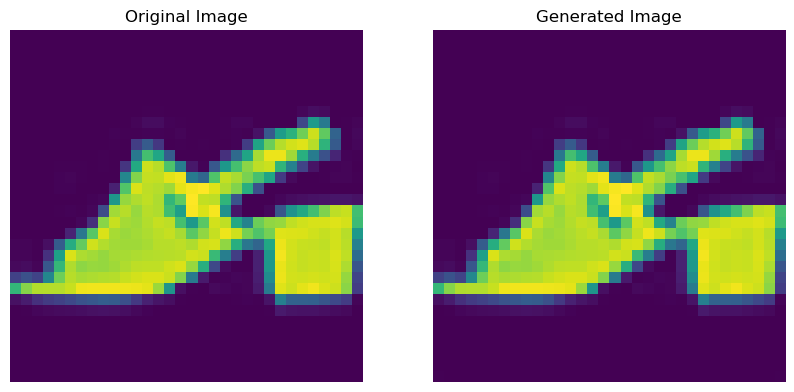

Epoch 33/100:  32%|███▏      | 32/100 [09:04<19:12, 16.94s/it, loss=4.76e-7]

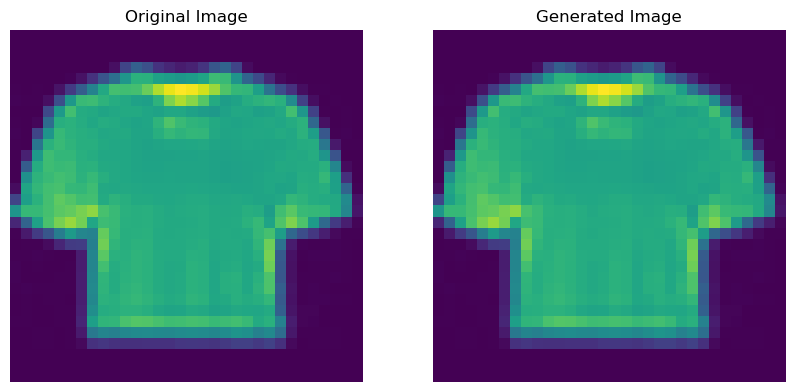

Epoch 33/100:  32%|███▏      | 32/100 [09:13<19:12, 16.94s/it, loss=4.67e-7] 

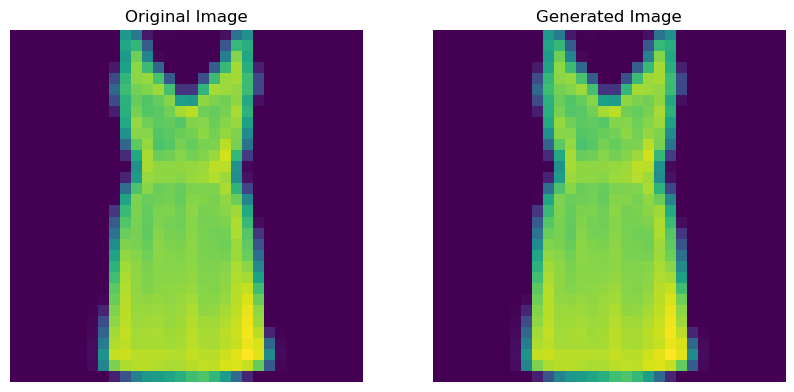

Epoch 34/100:  33%|███▎      | 33/100 [09:21<18:55, 16.95s/it, loss=1.19e-5]

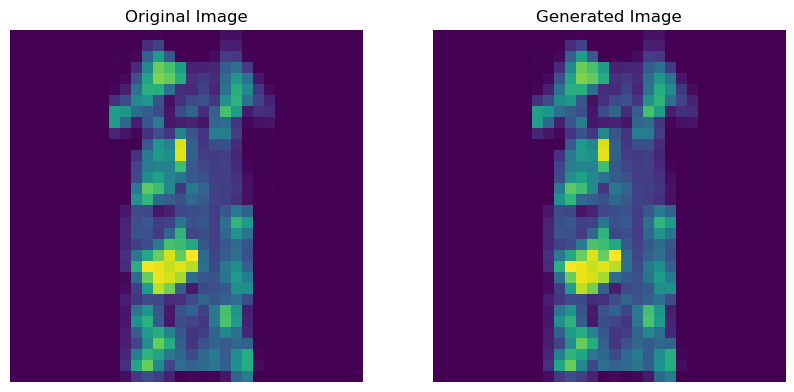

Epoch 34/100:  33%|███▎      | 33/100 [09:30<18:55, 16.95s/it, loss=1.18e-7] 

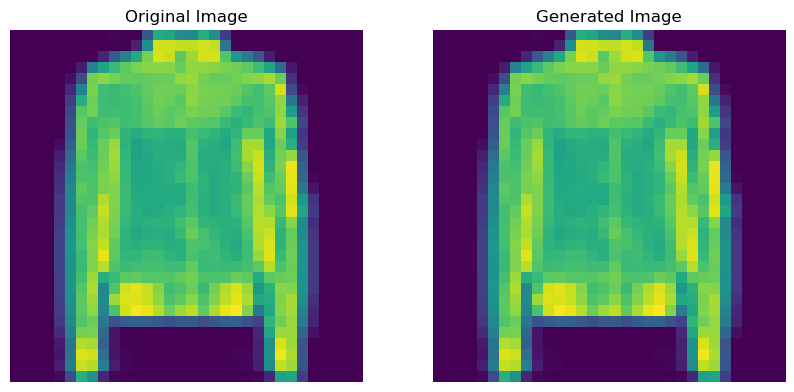

Epoch 35/100:  34%|███▍      | 34/100 [09:38<18:38, 16.94s/it, loss=1.3e-7] 

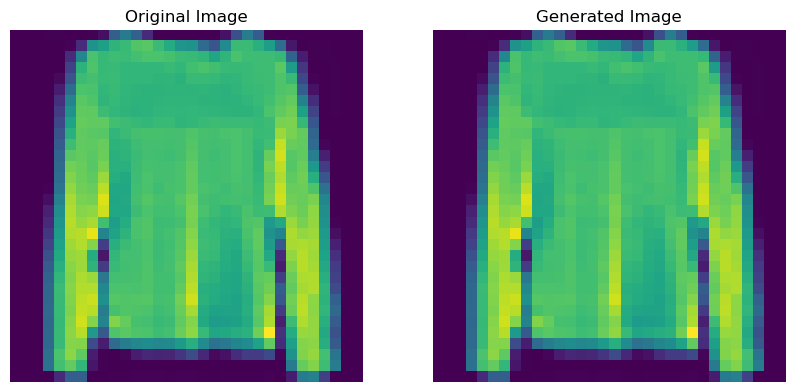

Epoch 35/100:  34%|███▍      | 34/100 [09:47<18:38, 16.94s/it, loss=3.72e-7]

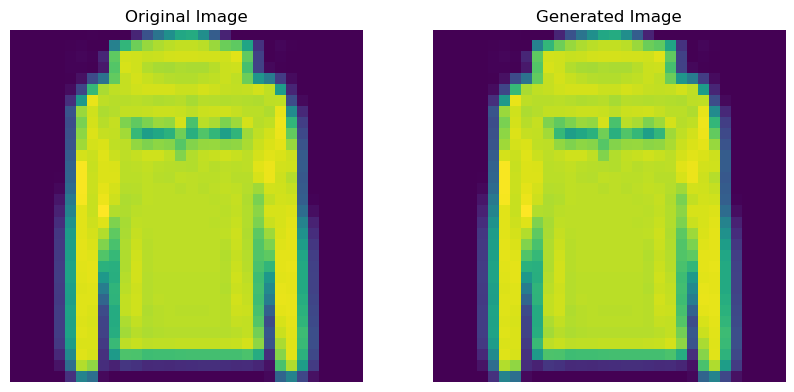

Epoch 36/100:  35%|███▌      | 35/100 [09:55<18:22, 16.97s/it, loss=1.53e-5]

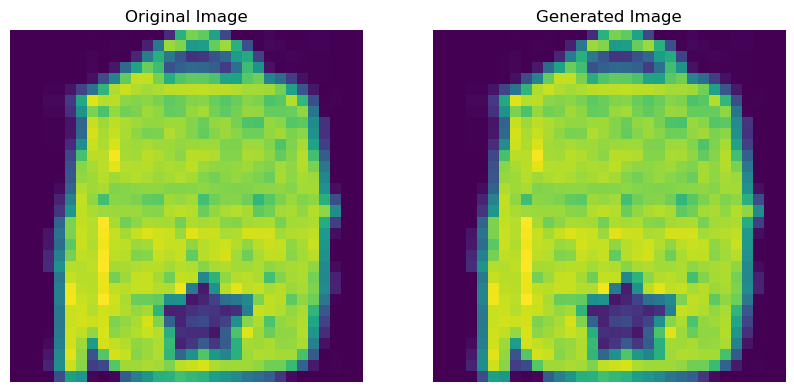

Epoch 36/100:  35%|███▌      | 35/100 [10:04<18:22, 16.97s/it, loss=6.01e-7]

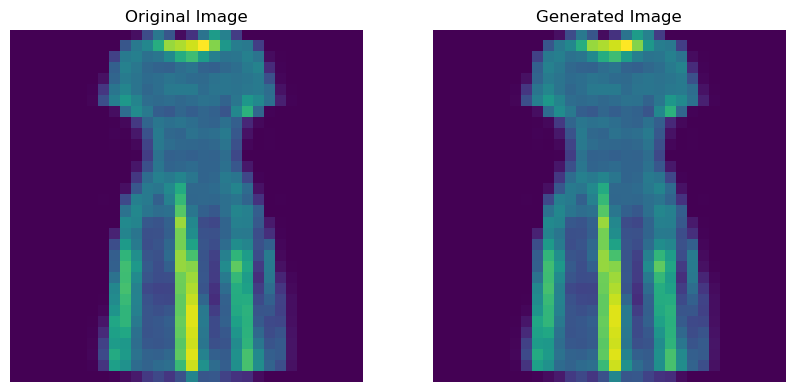

Epoch 37/100:  36%|███▌      | 36/100 [10:12<18:07, 16.99s/it, loss=8.13e-7] 

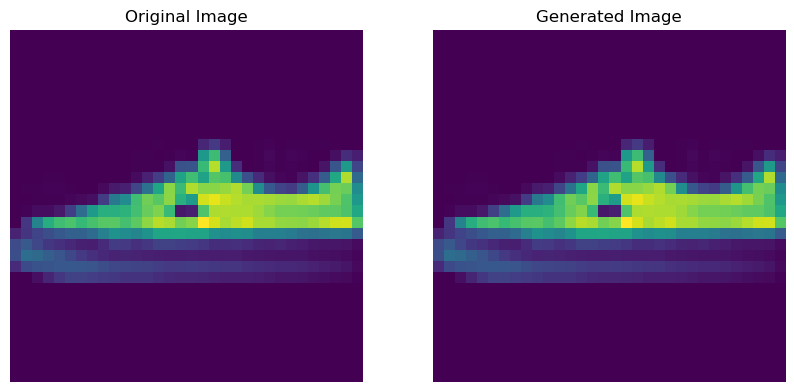

Epoch 37/100:  36%|███▌      | 36/100 [10:21<18:07, 16.99s/it, loss=4.33e-7] 

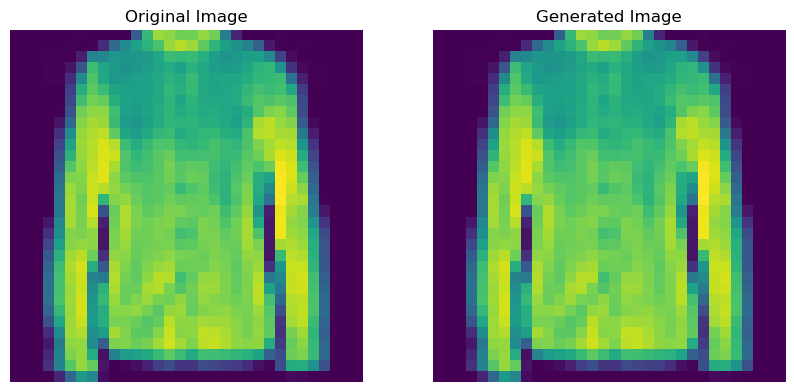

Epoch 38/100:  37%|███▋      | 37/100 [10:29<17:52, 17.02s/it, loss=1.25e-7] 

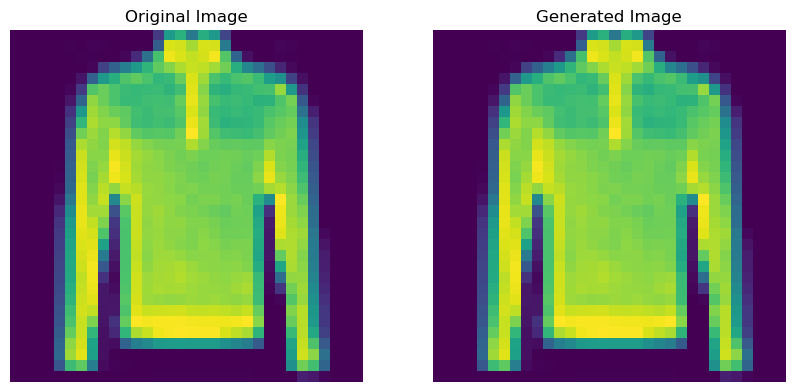

Epoch 38/100:  37%|███▋      | 37/100 [10:38<17:52, 17.02s/it, loss=6.17e-8]

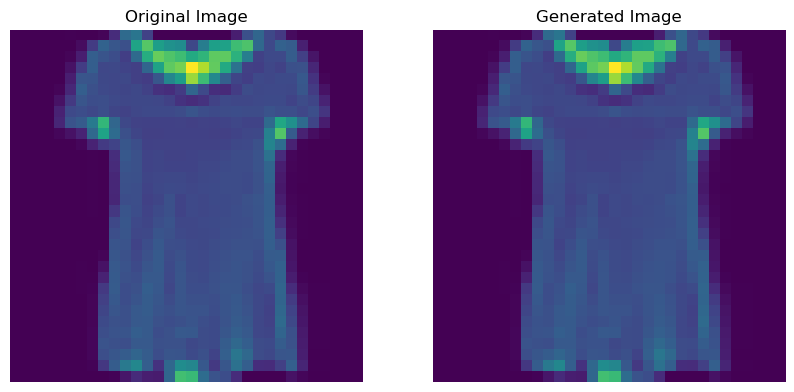

Epoch 39/100:  38%|███▊      | 38/100 [10:46<17:32, 16.97s/it, loss=1.77e-6] 

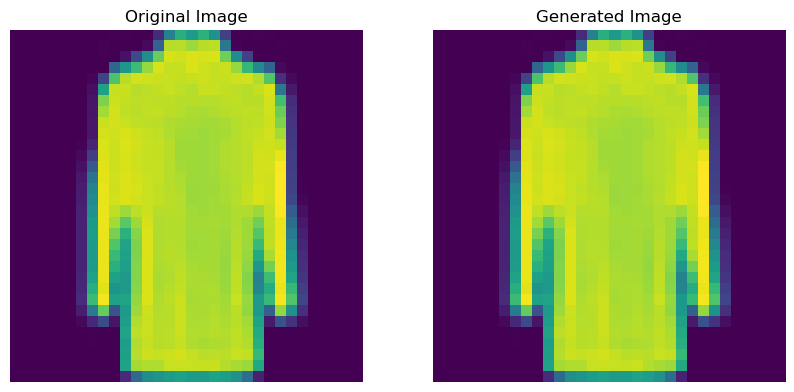

Epoch 39/100:  38%|███▊      | 38/100 [10:55<17:32, 16.97s/it, loss=9.26e-5] 

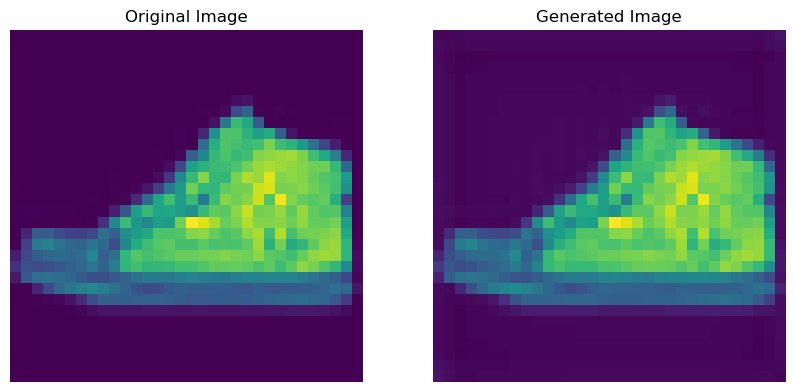

Epoch 40/100:  39%|███▉      | 39/100 [11:03<17:18, 17.03s/it, loss=1.81e-5]

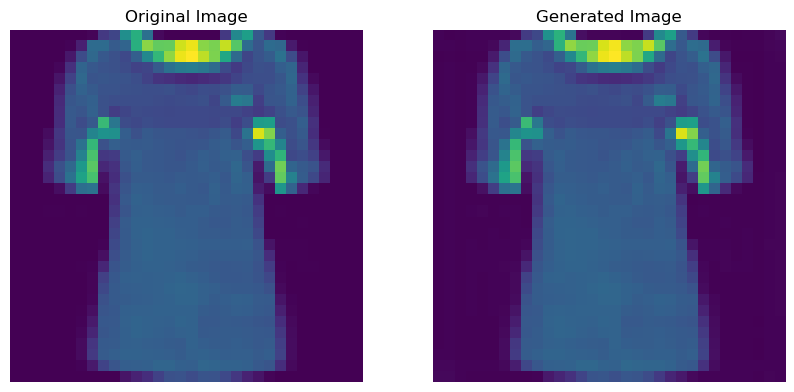

Epoch 40/100:  39%|███▉      | 39/100 [11:12<17:18, 17.03s/it, loss=7.96e-6]

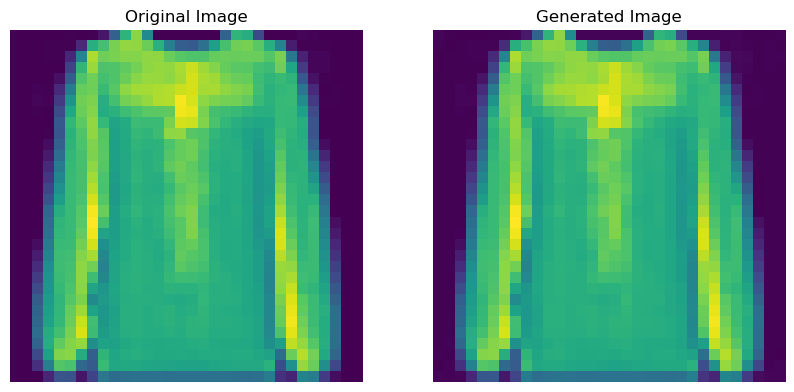

Epoch 41/100:  40%|████      | 40/100 [11:20<17:03, 17.05s/it, loss=5.32e-6]

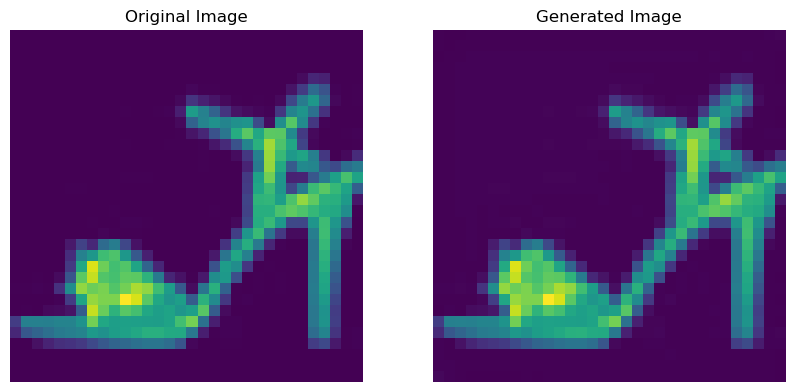

Epoch 41/100:  40%|████      | 40/100 [11:30<17:03, 17.05s/it, loss=3.21e-6]

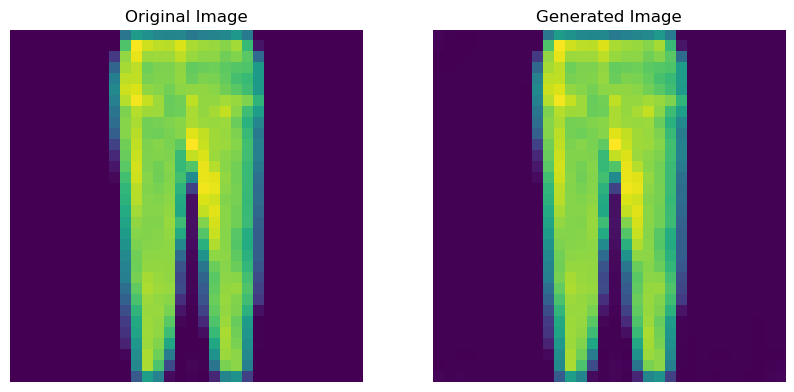

Epoch 42/100:  41%|████      | 41/100 [11:37<16:45, 17.04s/it, loss=2.33e-6]

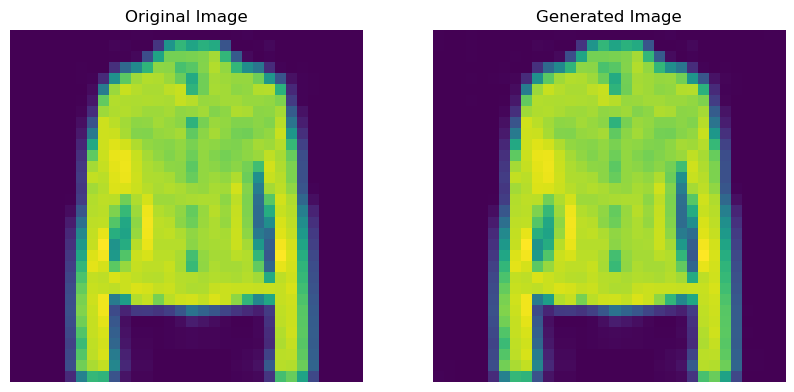

Epoch 42/100:  41%|████      | 41/100 [11:47<16:45, 17.04s/it, loss=1.62e-6]

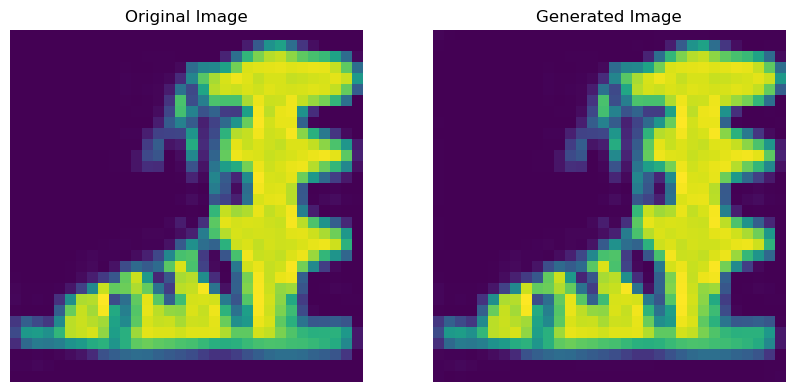

Epoch 43/100:  42%|████▏     | 42/100 [11:54<16:27, 17.03s/it, loss=1.33e-6]

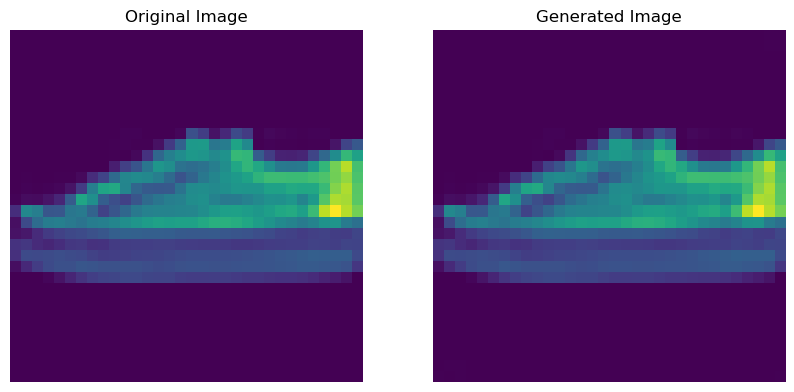

Epoch 43/100:  42%|████▏     | 42/100 [12:03<16:27, 17.03s/it, loss=9.6e-7] 

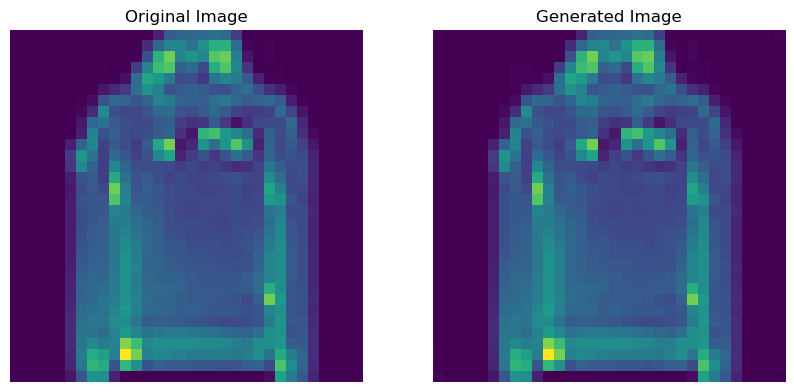

Epoch 44/100:  43%|████▎     | 43/100 [12:11<16:09, 17.01s/it, loss=2.02e-5]

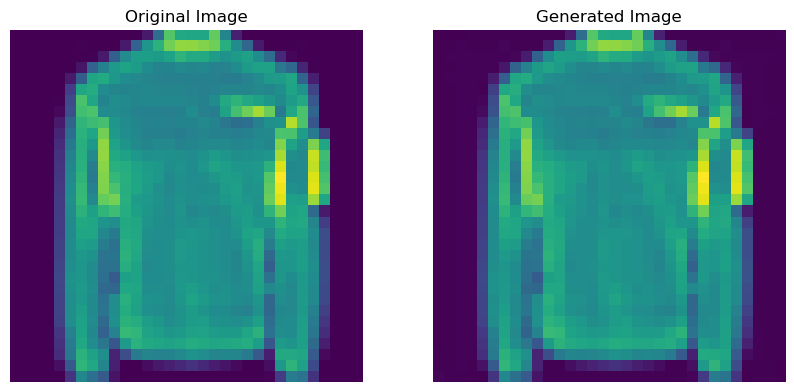

Epoch 44/100:  43%|████▎     | 43/100 [12:21<16:09, 17.01s/it, loss=5.53e-7]

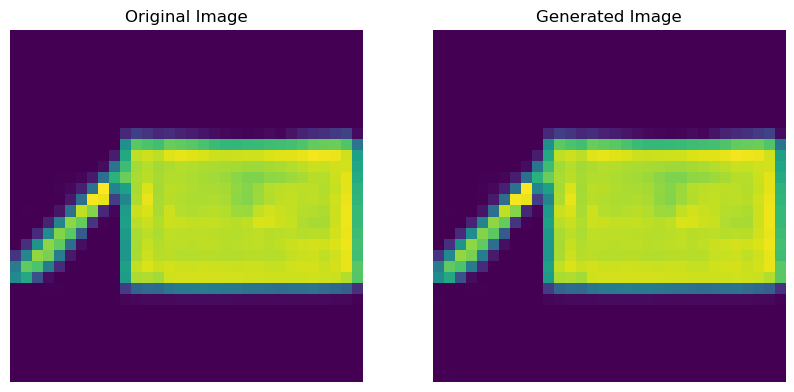

Epoch 45/100:  44%|████▍     | 44/100 [12:29<15:57, 17.10s/it, loss=2.81e-6] 

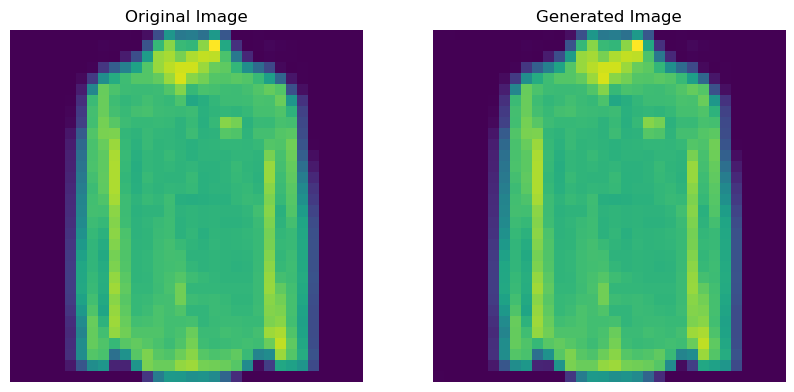

Epoch 45/100:  44%|████▍     | 44/100 [12:38<15:57, 17.10s/it, loss=3.85e-7] 

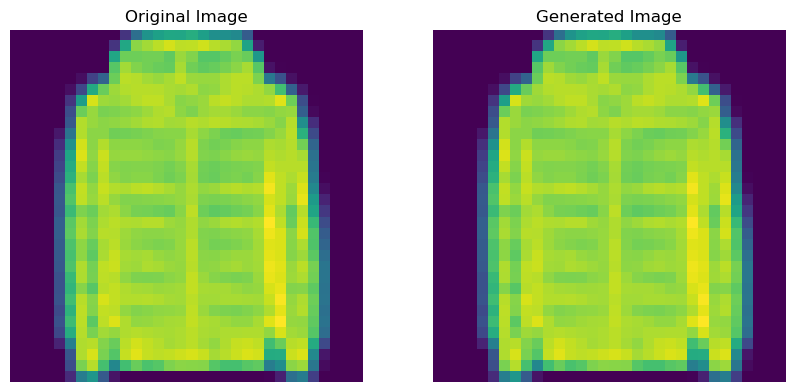

Epoch 46/100:  45%|████▌     | 45/100 [12:46<15:40, 17.09s/it, loss=2.29e-6]

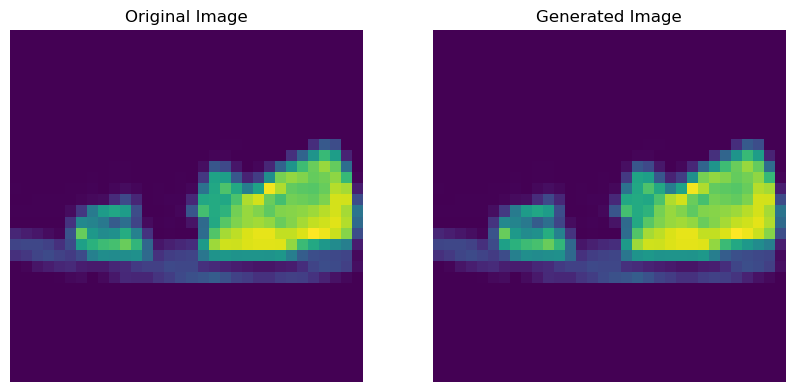

Epoch 46/100:  45%|████▌     | 45/100 [12:55<15:40, 17.09s/it, loss=1.33e-6] 

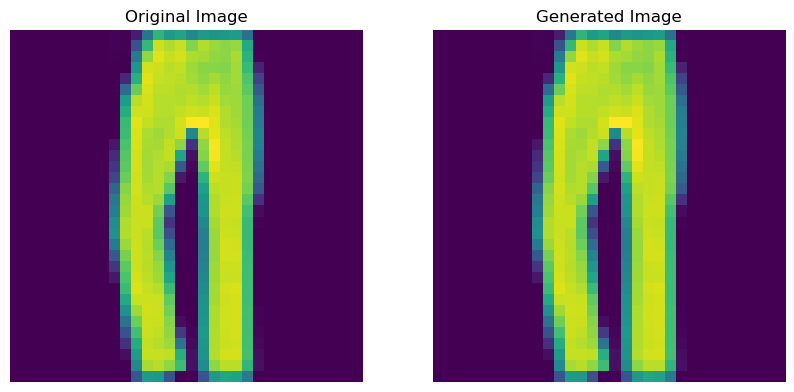

Epoch 47/100:  46%|████▌     | 46/100 [13:03<15:22, 17.08s/it, loss=3.1e-6] 

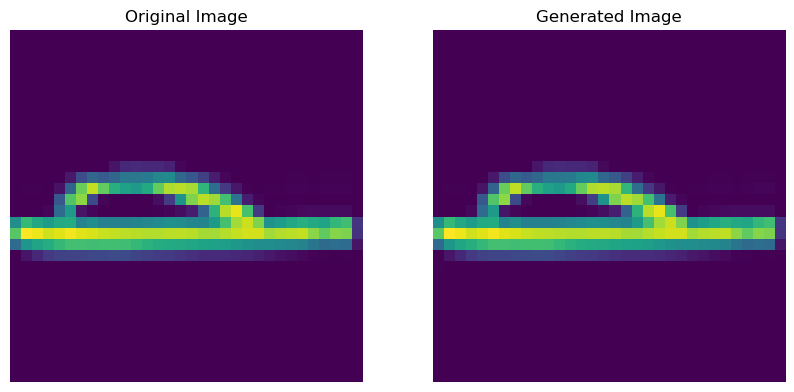

Epoch 47/100:  46%|████▌     | 46/100 [13:12<15:22, 17.08s/it, loss=5.05e-7] 

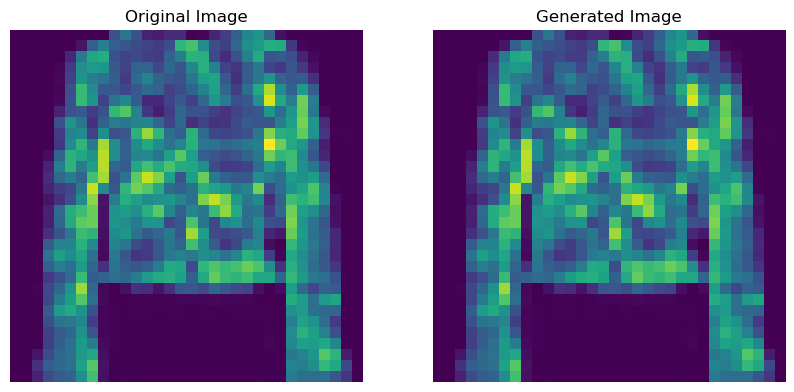

Epoch 48/100:  47%|████▋     | 47/100 [13:20<15:03, 17.06s/it, loss=5.88e-7] 

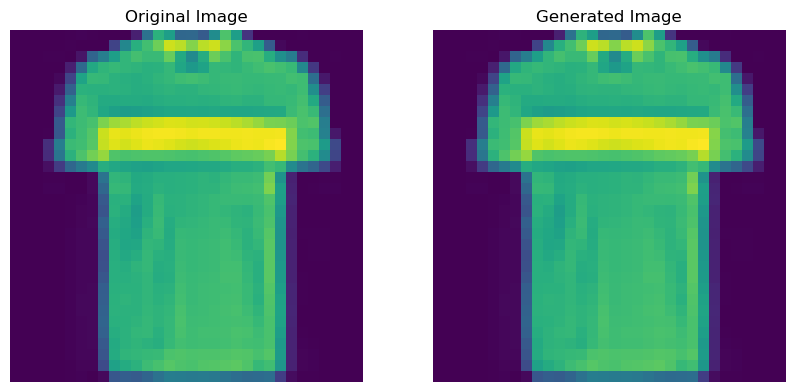

Epoch 48/100:  47%|████▋     | 47/100 [13:29<15:03, 17.06s/it, loss=3.44e-7]

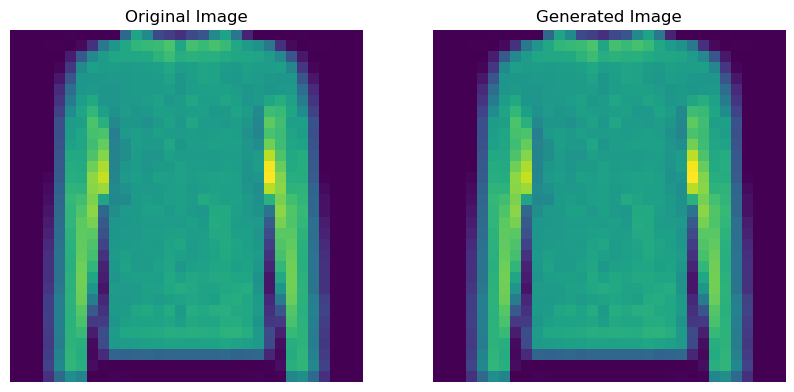

Epoch 49/100:  48%|████▊     | 48/100 [13:37<14:46, 17.04s/it, loss=4.82e-7]

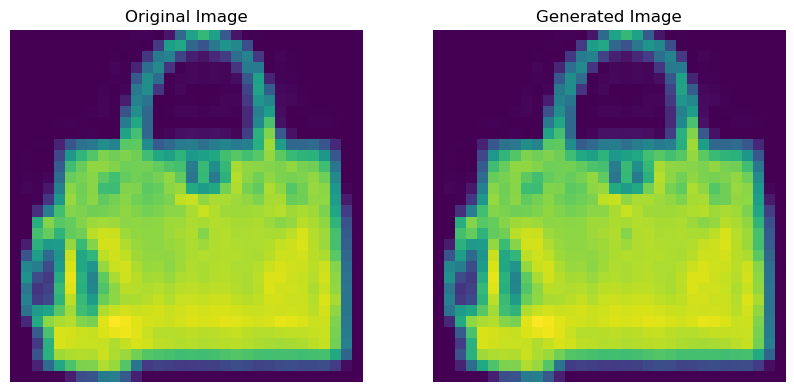

Epoch 49/100:  48%|████▊     | 48/100 [13:46<14:46, 17.04s/it, loss=5.65e-5] 

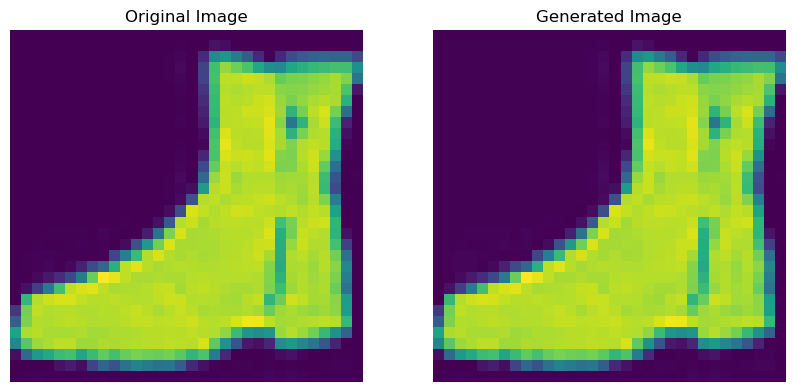

Epoch 50/100:  49%|████▉     | 49/100 [13:54<14:26, 16.99s/it, loss=3.59e-7] 

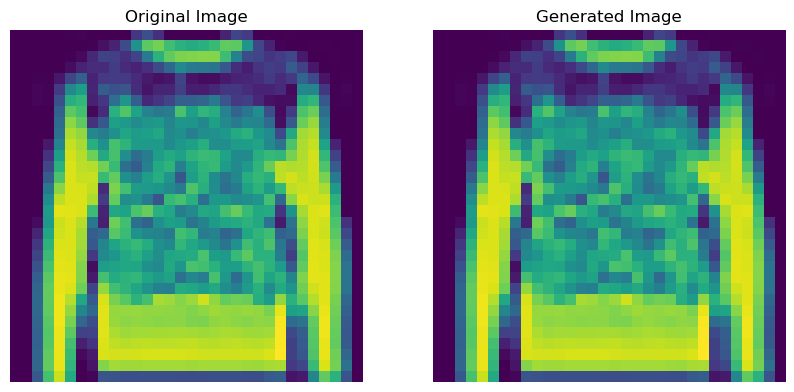

Epoch 50/100:  49%|████▉     | 49/100 [14:03<14:26, 16.99s/it, loss=9.24e-8] 

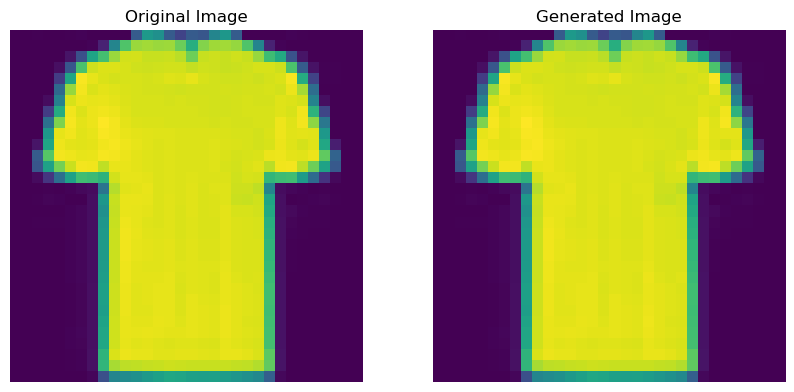

Epoch 51/100:  50%|█████     | 50/100 [14:11<14:10, 17.00s/it, loss=3.52e-6] 

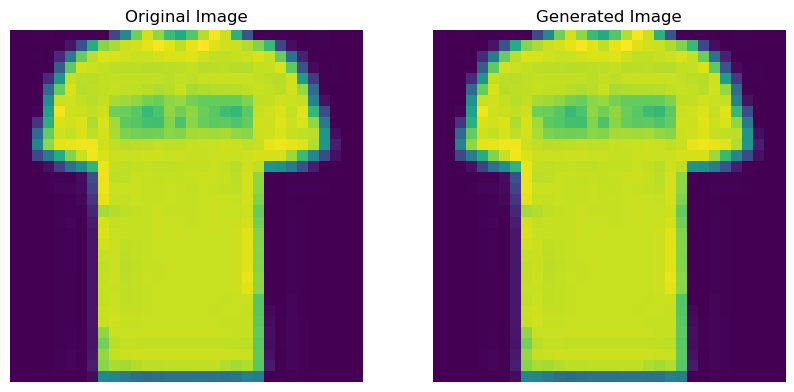

Epoch 51/100:  50%|█████     | 50/100 [14:20<14:10, 17.00s/it, loss=3.09e-8]

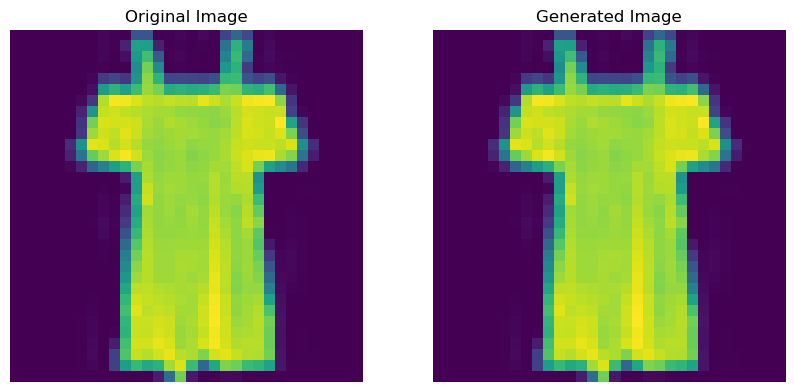

Epoch 52/100:  51%|█████     | 51/100 [14:28<13:52, 16.99s/it, loss=1.73e-7]

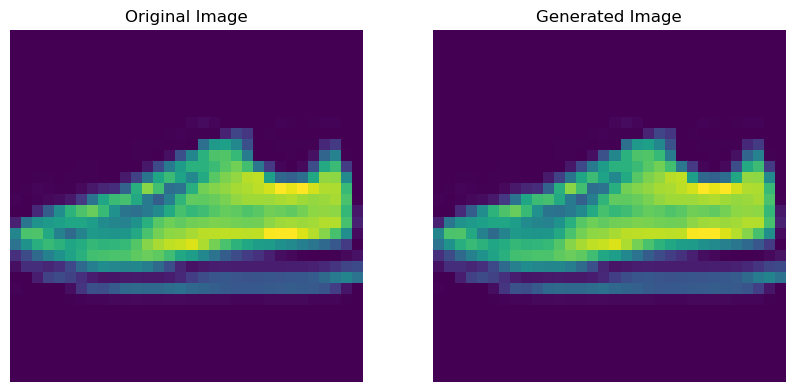

Epoch 52/100:  51%|█████     | 51/100 [14:37<13:52, 16.99s/it, loss=1.07e-7] 

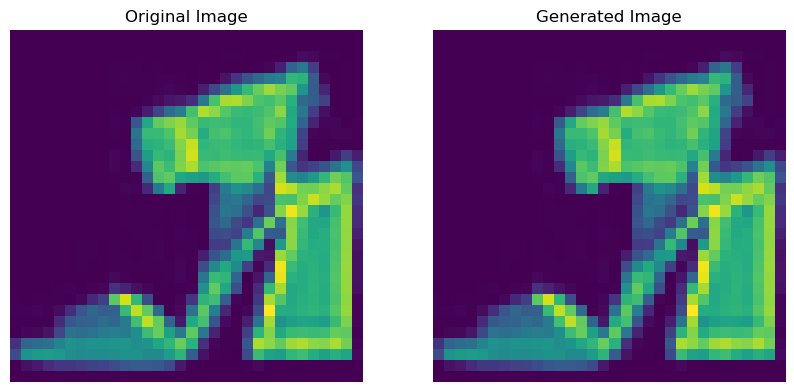

Epoch 53/100:  52%|█████▏    | 52/100 [14:45<13:39, 17.07s/it, loss=1.84e-6]

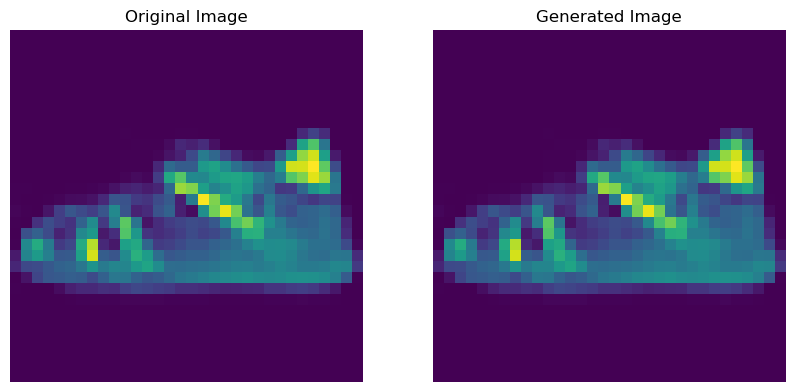

Epoch 53/100:  52%|█████▏    | 52/100 [14:54<13:39, 17.07s/it, loss=4.14e-6] 

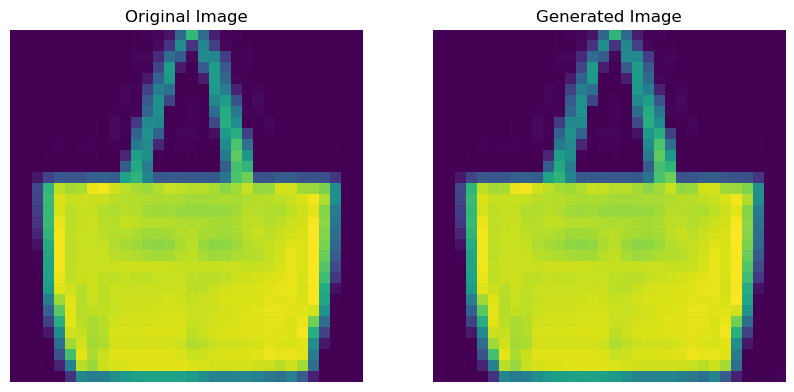

Epoch 54/100:  53%|█████▎    | 53/100 [15:02<13:23, 17.10s/it, loss=1.15e-6]

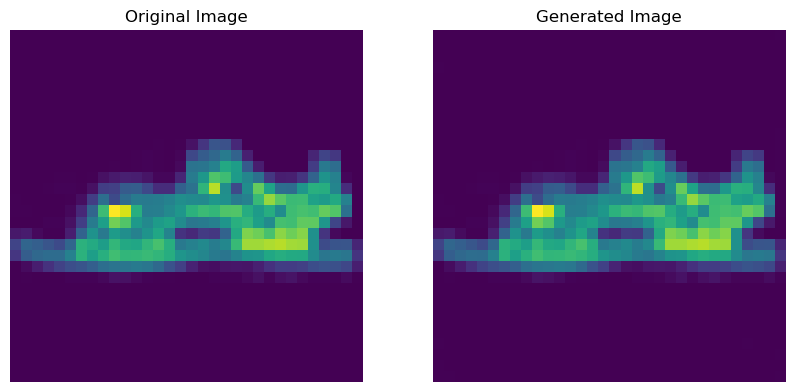

Epoch 54/100:  53%|█████▎    | 53/100 [15:11<13:23, 17.10s/it, loss=6.16e-7]

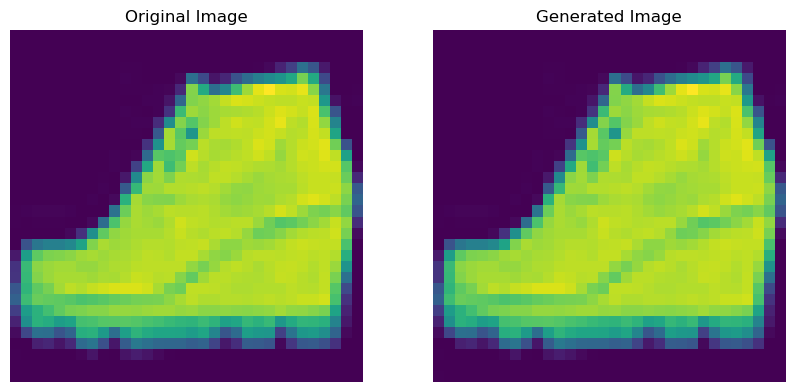

Epoch 55/100:  54%|█████▍    | 54/100 [15:19<13:06, 17.11s/it, loss=3.82e-7]

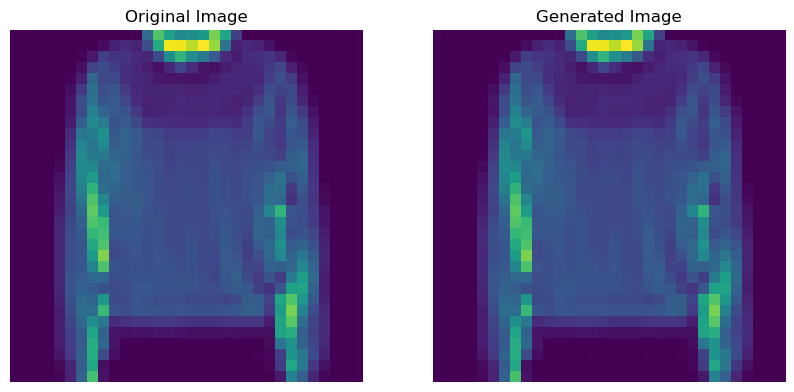

Epoch 55/100:  54%|█████▍    | 54/100 [15:28<13:06, 17.11s/it, loss=2.72e-7]

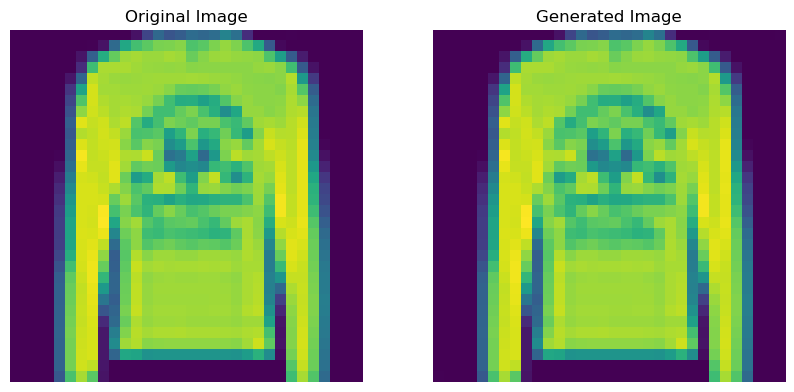

Epoch 56/100:  55%|█████▌    | 55/100 [15:36<12:49, 17.10s/it, loss=2.18e-7]

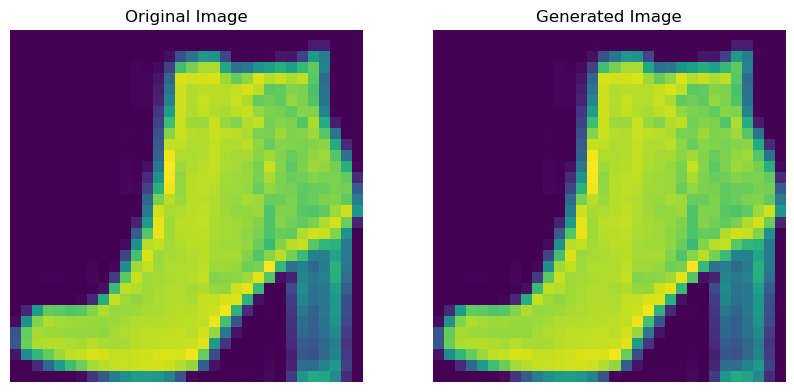

Epoch 56/100:  55%|█████▌    | 55/100 [15:46<12:49, 17.10s/it, loss=1.84e-7]

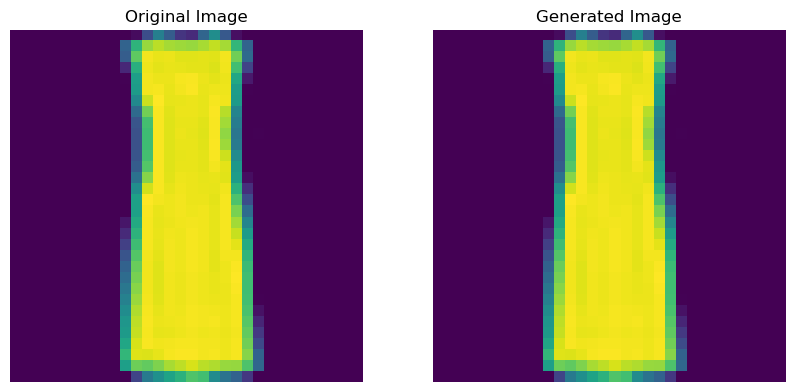

Epoch 57/100:  56%|█████▌    | 56/100 [15:54<12:34, 17.14s/it, loss=1.52e-7]

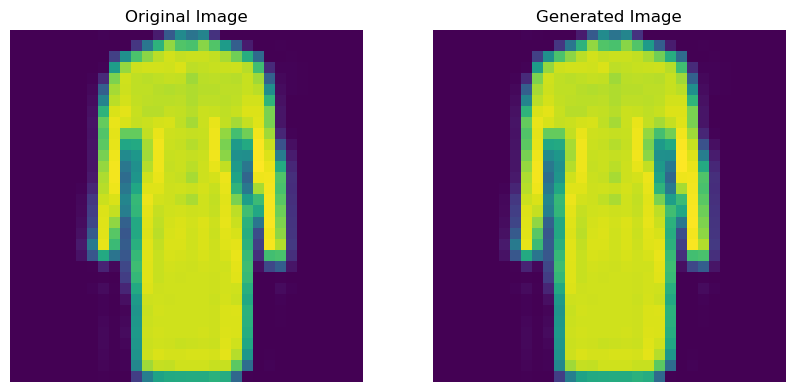

Epoch 57/100:  56%|█████▌    | 56/100 [16:03<12:34, 17.14s/it, loss=7.17e-7]

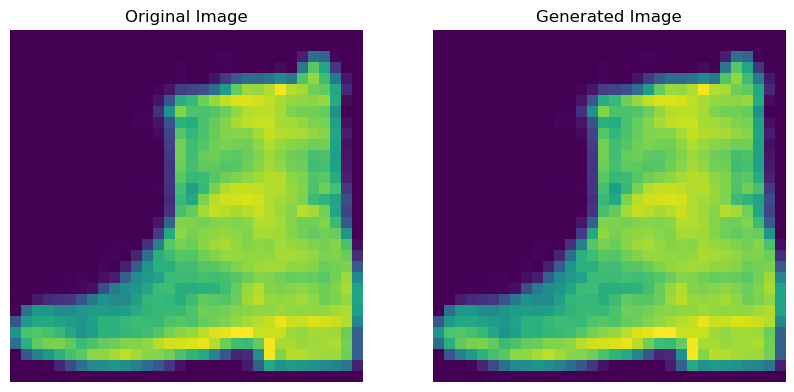

Epoch 58/100:  57%|█████▋    | 57/100 [16:11<12:18, 17.17s/it, loss=3.45e-7]

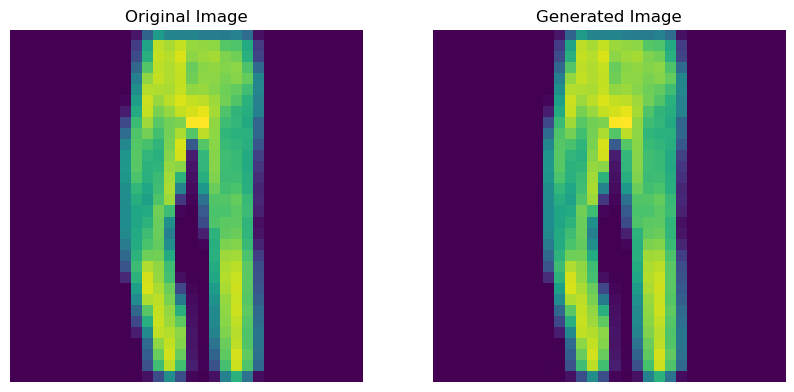

Epoch 58/100:  57%|█████▋    | 57/100 [16:20<12:18, 17.17s/it, loss=8.07e-8]

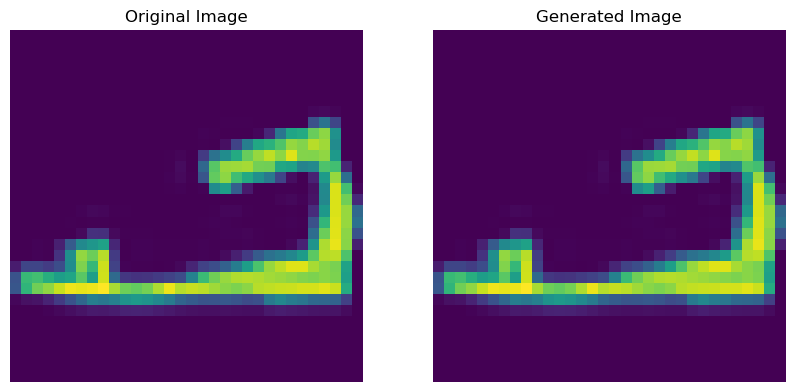

Epoch 59/100:  58%|█████▊    | 58/100 [16:28<12:00, 17.15s/it, loss=1.72e-7] 

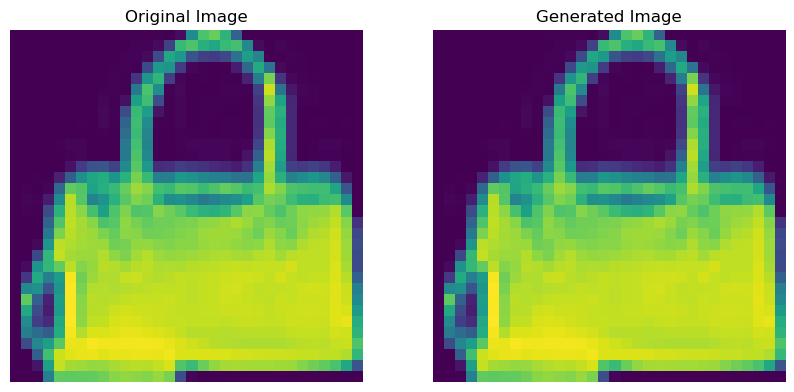

Epoch 59/100:  58%|█████▊    | 58/100 [16:37<12:00, 17.15s/it, loss=1.31e-7] 

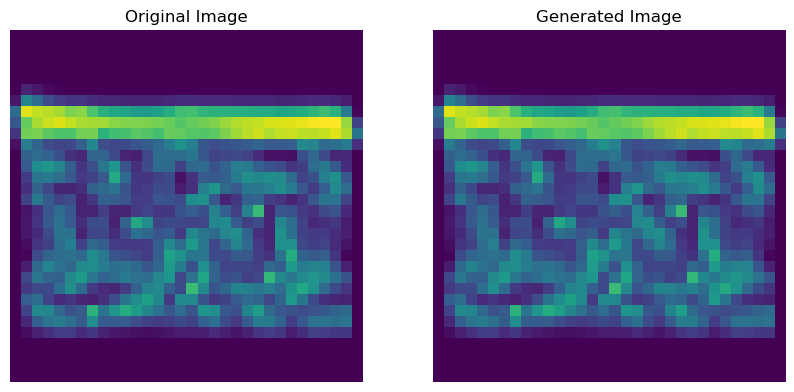

Epoch 60/100:  59%|█████▉    | 59/100 [16:45<11:46, 17.24s/it, loss=3.08e-7]

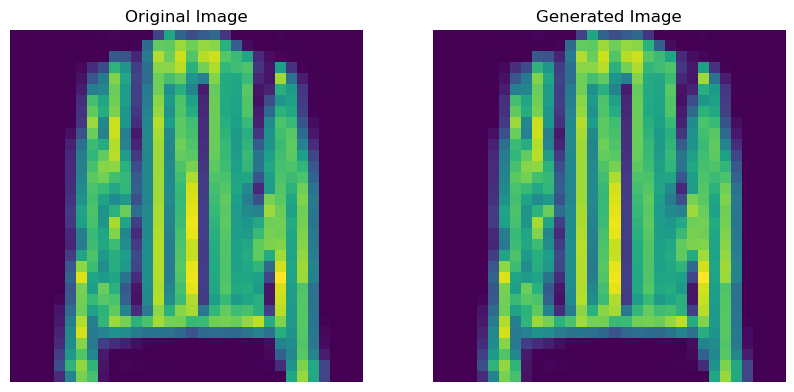

Epoch 60/100:  59%|█████▉    | 59/100 [16:55<11:46, 17.24s/it, loss=1.54e-7] 

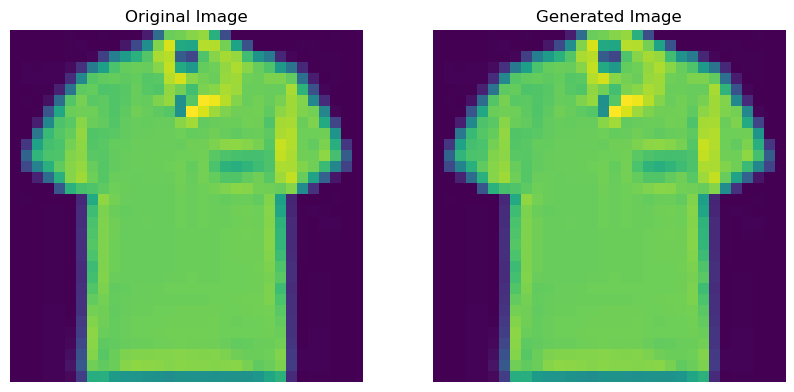

Epoch 61/100:  60%|██████    | 60/100 [17:03<11:30, 17.26s/it, loss=2.61e-6]

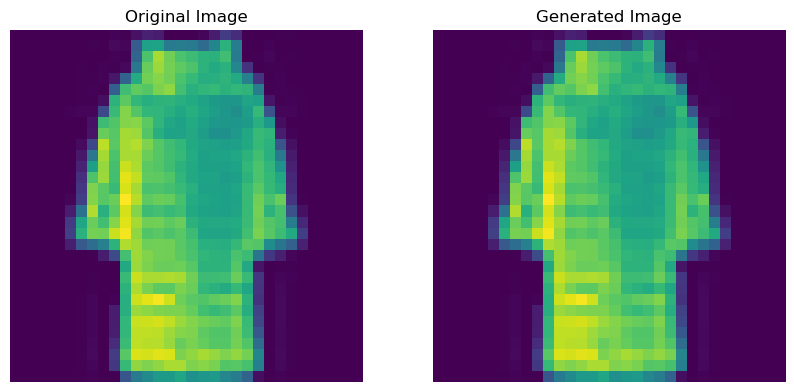

Epoch 61/100:  60%|██████    | 60/100 [17:12<11:30, 17.26s/it, loss=1.46e-7] 

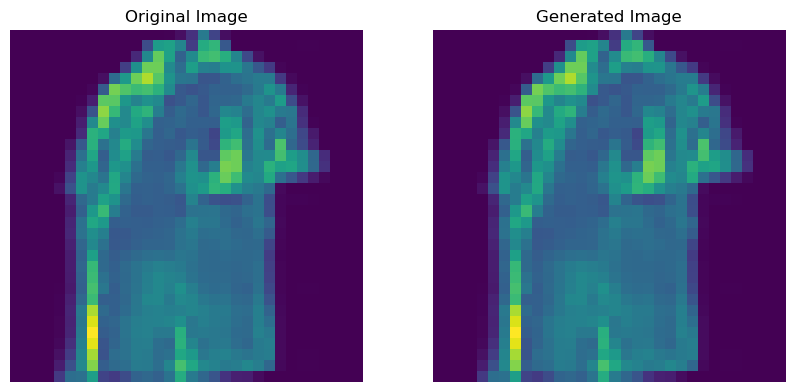

Epoch 62/100:  61%|██████    | 61/100 [17:20<11:12, 17.25s/it, loss=8.83e-8]

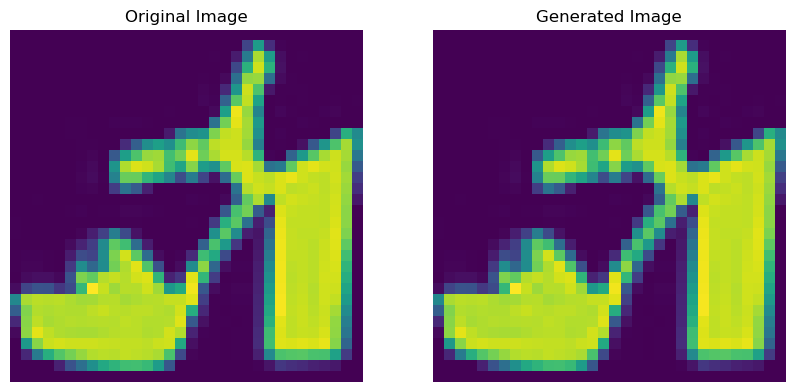

Epoch 62/100:  61%|██████    | 61/100 [17:29<11:12, 17.25s/it, loss=8.11e-8] 

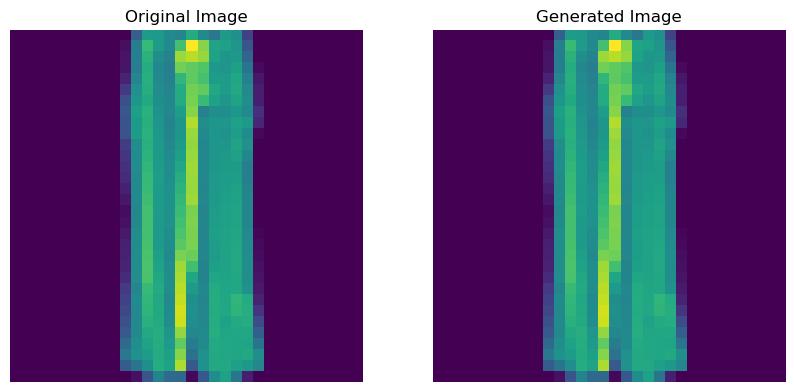

Epoch 63/100:  62%|██████▏   | 62/100 [17:37<10:54, 17.22s/it, loss=8.37e-7]

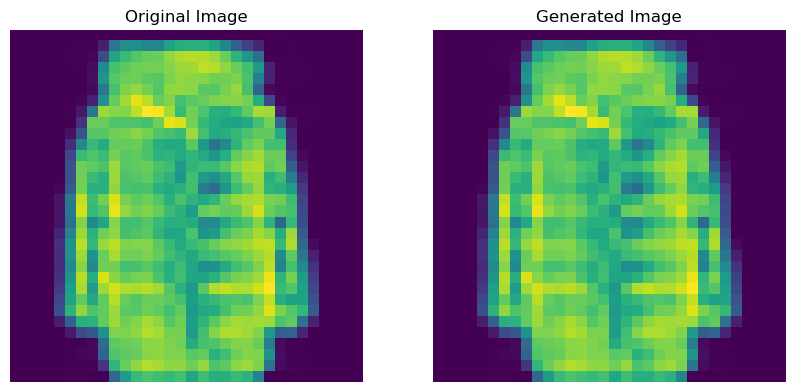

Epoch 63/100:  62%|██████▏   | 62/100 [17:46<10:54, 17.22s/it, loss=1.82e-7]

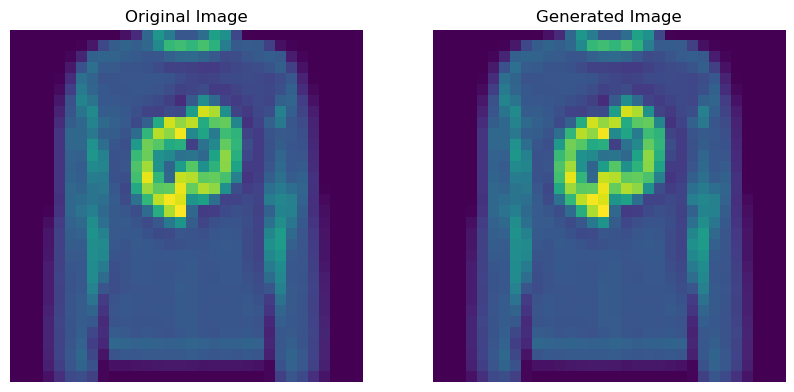

Epoch 64/100:  63%|██████▎   | 63/100 [17:54<10:36, 17.20s/it, loss=2.6e-7] 

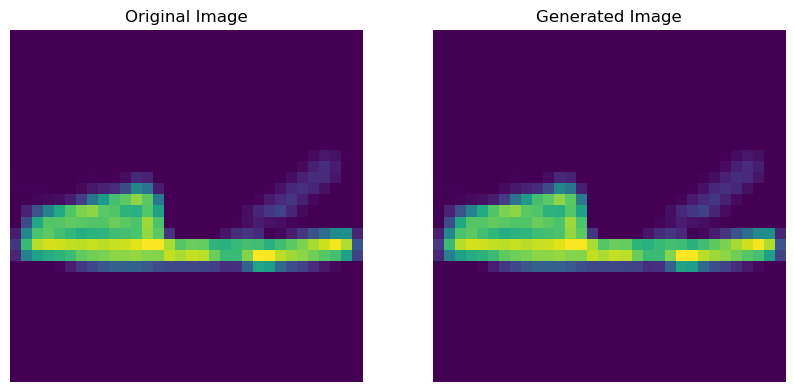

Epoch 64/100:  63%|██████▎   | 63/100 [18:03<10:36, 17.20s/it, loss=1.26e-5] 

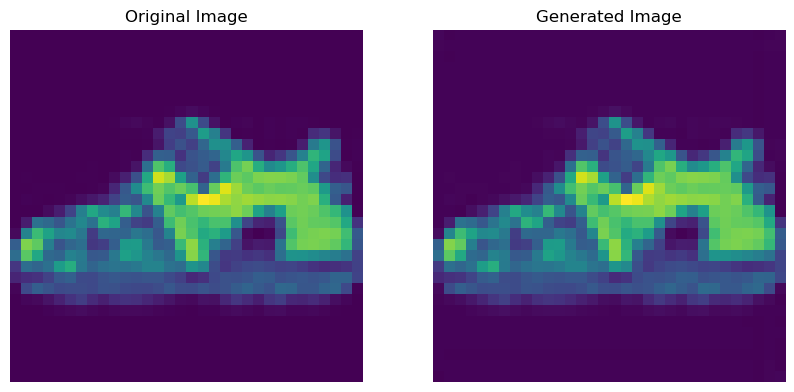

Epoch 65/100:  64%|██████▍   | 64/100 [18:11<10:17, 17.16s/it, loss=4.42e-6]

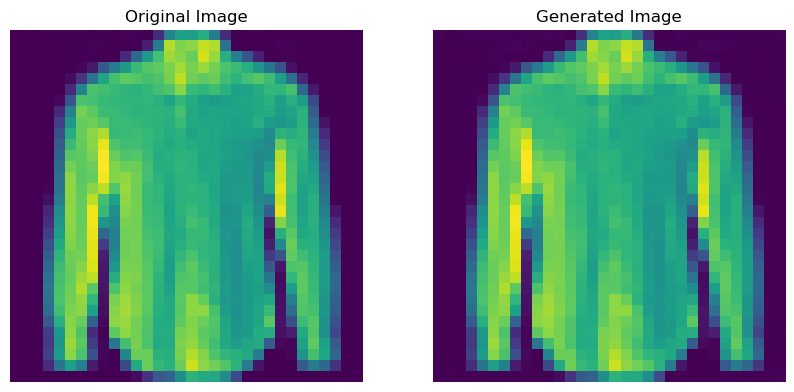

Epoch 65/100:  64%|██████▍   | 64/100 [18:20<10:17, 17.16s/it, loss=2.3e-6] 

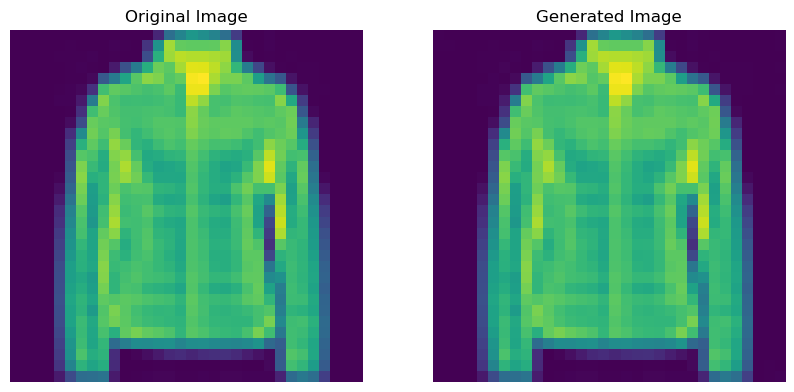

Epoch 66/100:  65%|██████▌   | 65/100 [18:28<09:59, 17.12s/it, loss=1.59e-6]

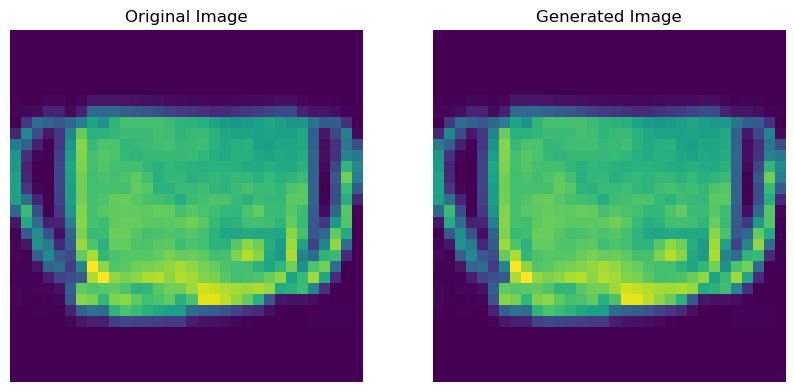

Epoch 66/100:  65%|██████▌   | 65/100 [18:37<09:59, 17.12s/it, loss=1.43e-6]

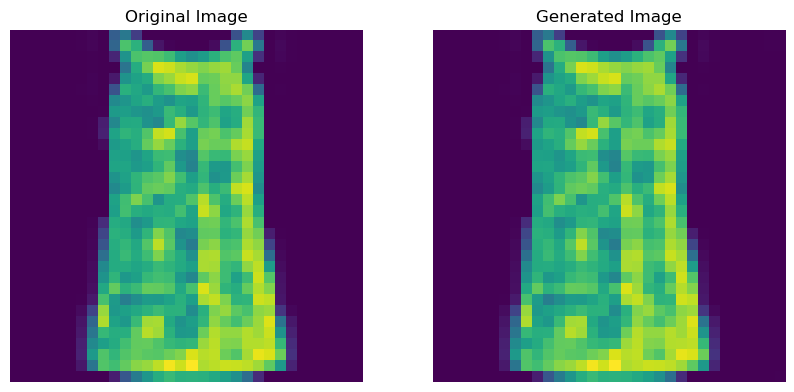

Epoch 67/100:  66%|██████▌   | 66/100 [18:45<09:41, 17.11s/it, loss=8.11e-7]

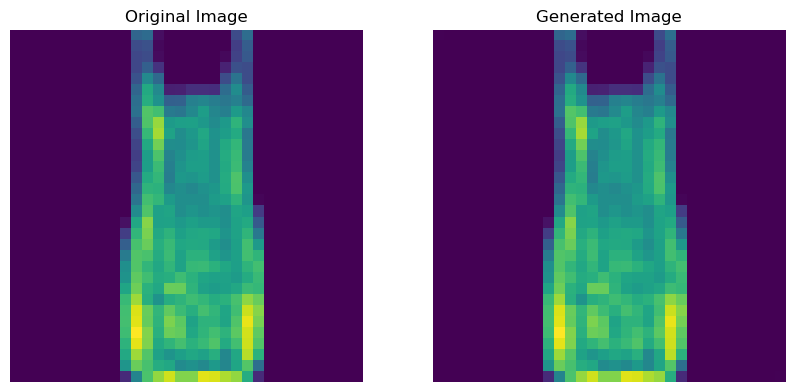

Epoch 67/100:  66%|██████▌   | 66/100 [18:54<09:41, 17.11s/it, loss=1.11e-6]

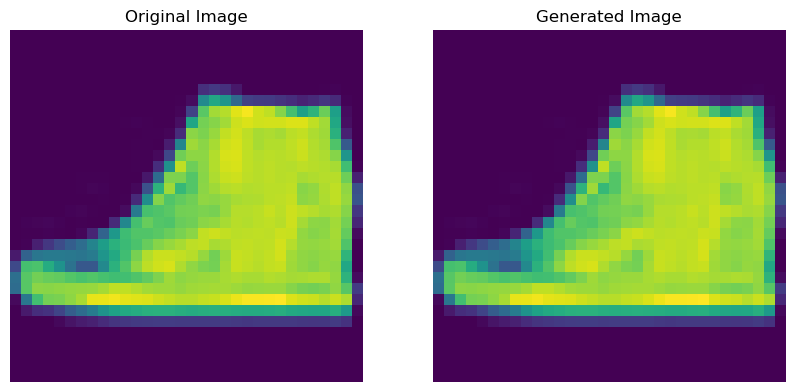

Epoch 68/100:  67%|██████▋   | 67/100 [19:02<09:23, 17.08s/it, loss=7.1e-6]  

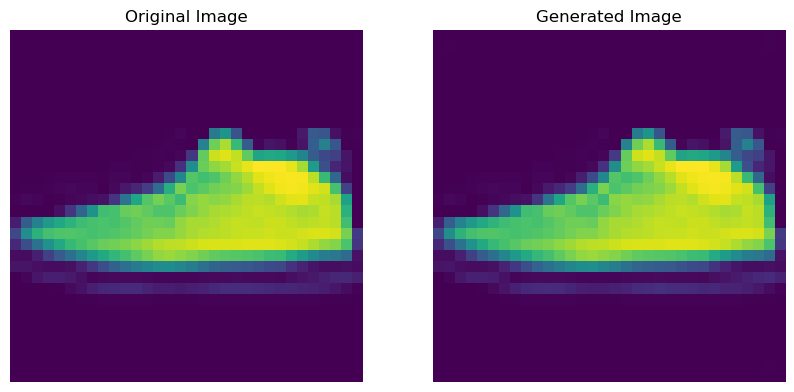

Epoch 68/100:  67%|██████▋   | 67/100 [19:11<09:23, 17.08s/it, loss=1e-5]    

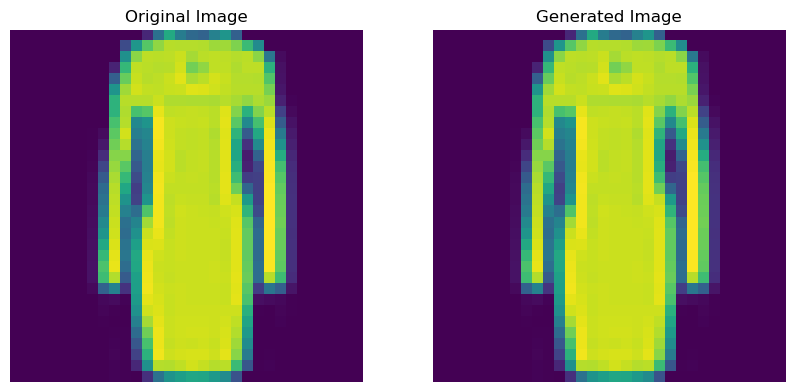

Epoch 69/100:  68%|██████▊   | 68/100 [19:19<09:04, 17.02s/it, loss=1.74e-6] 

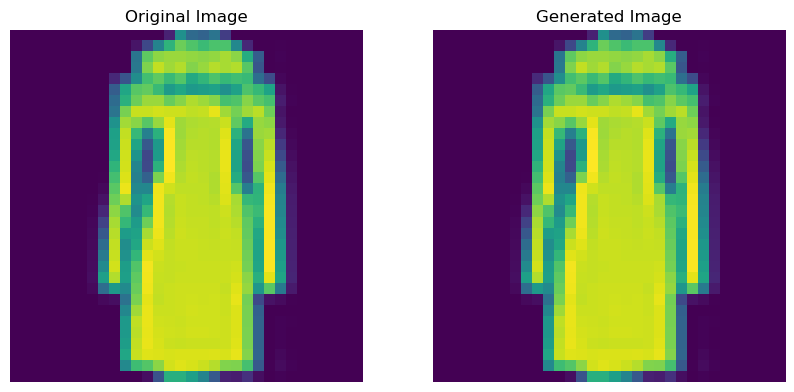

Epoch 69/100:  68%|██████▊   | 68/100 [19:28<09:04, 17.02s/it, loss=9.55e-6] 

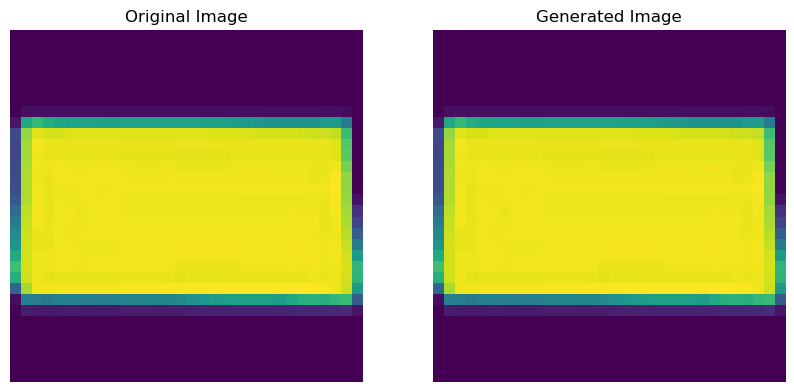

Epoch 70/100:  69%|██████▉   | 69/100 [19:36<08:47, 17.01s/it, loss=4.14e-7] 

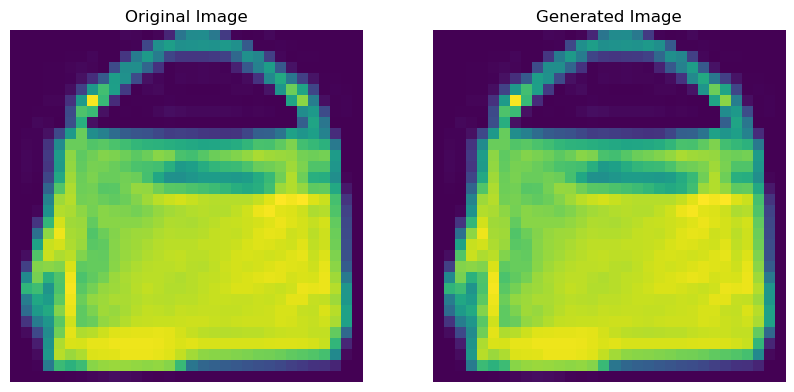

Epoch 70/100:  69%|██████▉   | 69/100 [19:45<08:47, 17.01s/it, loss=3.4e-7]  

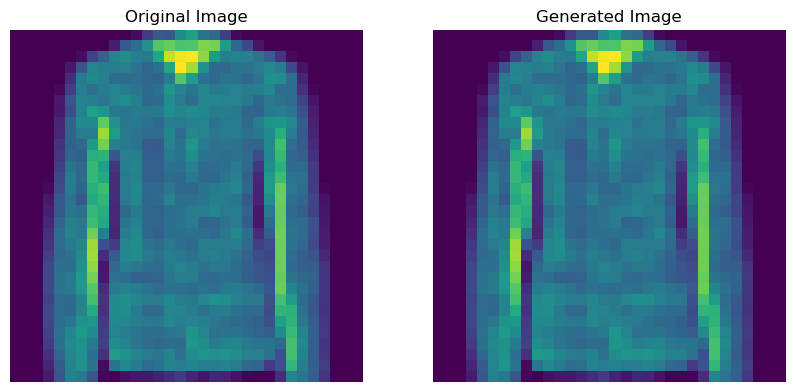

Epoch 71/100:  70%|███████   | 70/100 [19:53<08:29, 16.98s/it, loss=9.26e-6] 

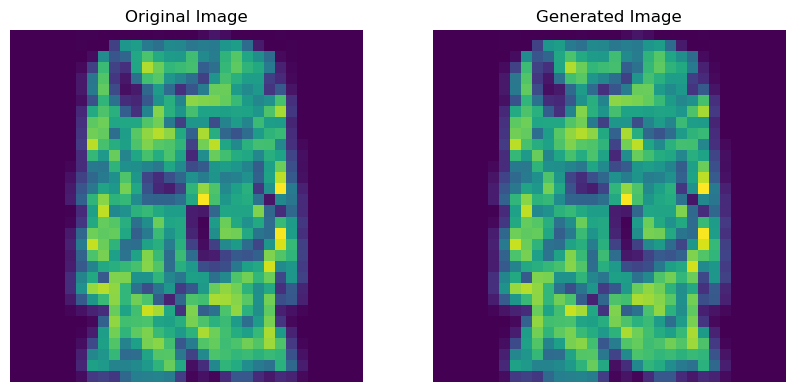

Epoch 71/100:  70%|███████   | 70/100 [20:02<08:29, 16.98s/it, loss=1.43e-7] 

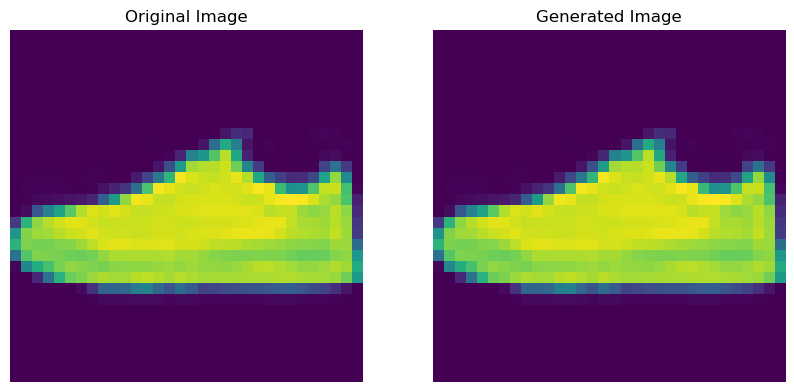

Epoch 72/100:  71%|███████   | 71/100 [20:10<08:11, 16.96s/it, loss=5.26e-6]

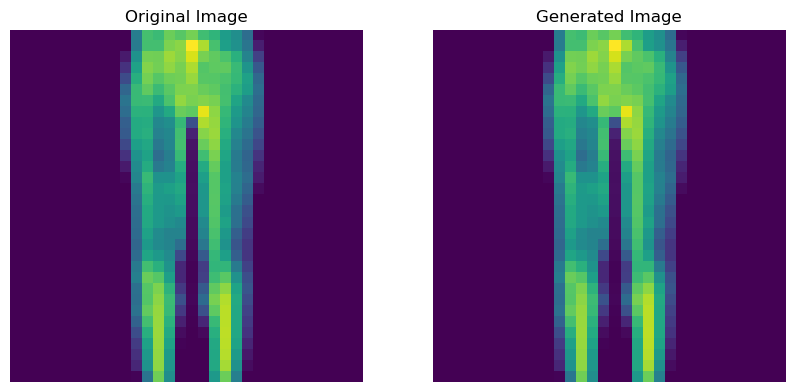

Epoch 72/100:  71%|███████   | 71/100 [20:19<08:11, 16.96s/it, loss=3.08e-7]

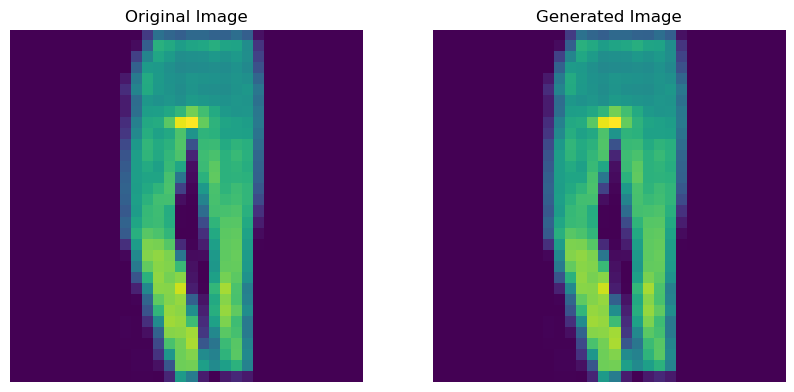

Epoch 73/100:  72%|███████▏  | 72/100 [20:27<07:55, 16.99s/it, loss=8.03e-6] 

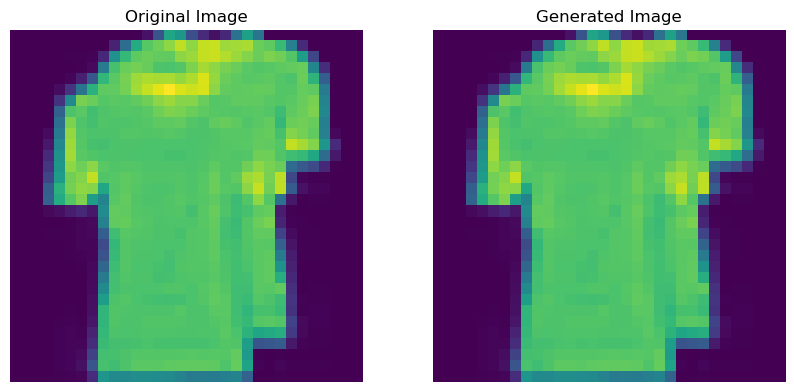

Epoch 73/100:  72%|███████▏  | 72/100 [20:36<07:55, 16.99s/it, loss=2.44e-6] 

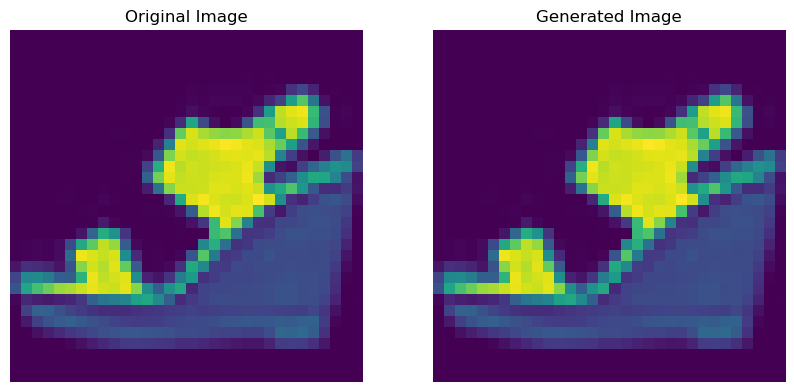

Epoch 74/100:  73%|███████▎  | 73/100 [20:45<07:41, 17.09s/it, loss=1.7e-6]  

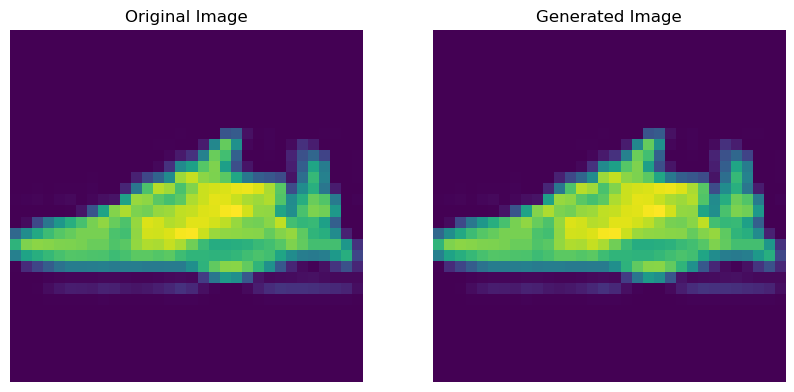

Epoch 74/100:  73%|███████▎  | 73/100 [20:54<07:41, 17.09s/it, loss=4.44e-7] 

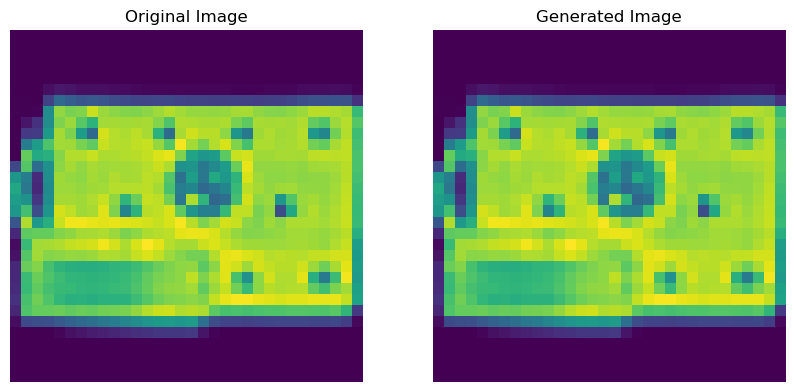

Epoch 75/100:  74%|███████▍  | 74/100 [21:02<07:25, 17.14s/it, loss=5.09e-7]

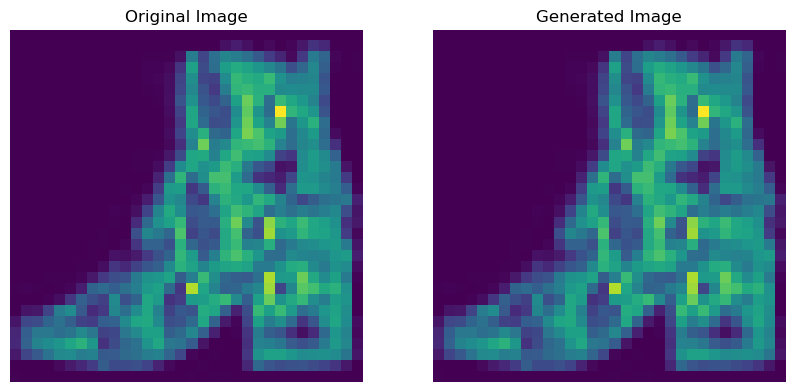

Epoch 75/100:  74%|███████▍  | 74/100 [21:11<07:25, 17.14s/it, loss=8.46e-7]

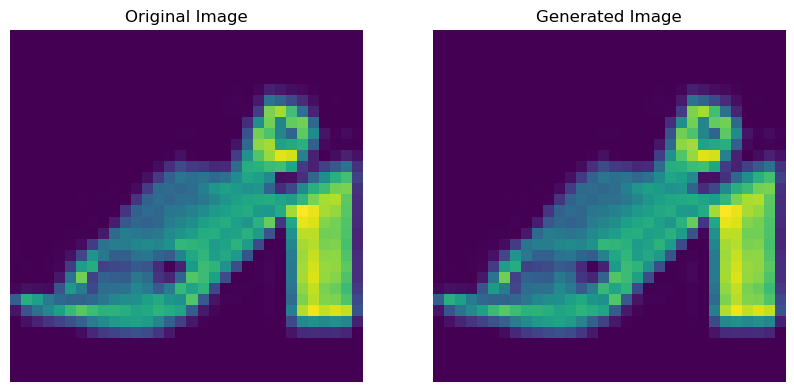

Epoch 76/100:  75%|███████▌  | 75/100 [21:19<07:08, 17.15s/it, loss=0.00526] 

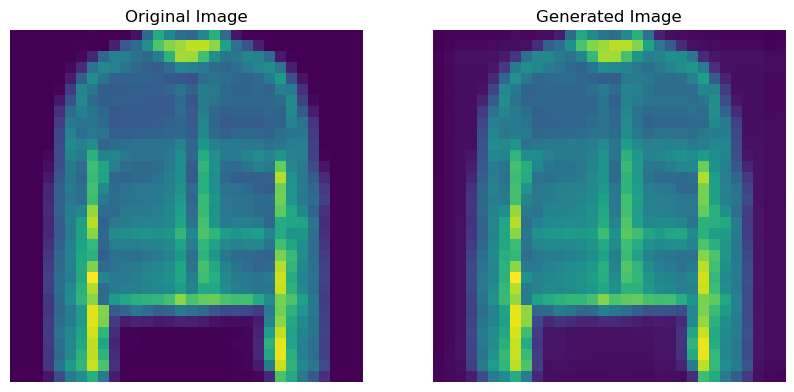

Epoch 76/100:  75%|███████▌  | 75/100 [21:28<07:08, 17.15s/it, loss=1.5e-6]  

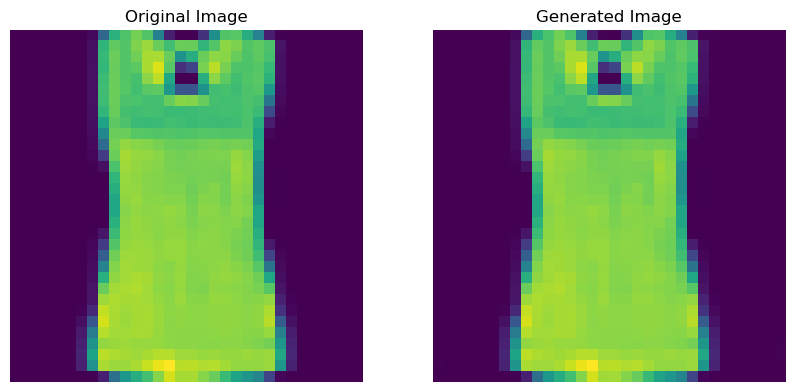

Epoch 77/100:  76%|███████▌  | 76/100 [21:36<06:51, 17.16s/it, loss=6.55e-7]

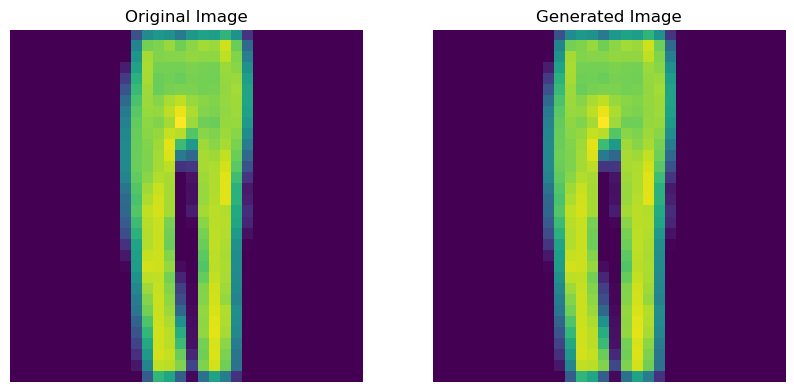

Epoch 77/100:  76%|███████▌  | 76/100 [21:45<06:51, 17.16s/it, loss=4e-7]   

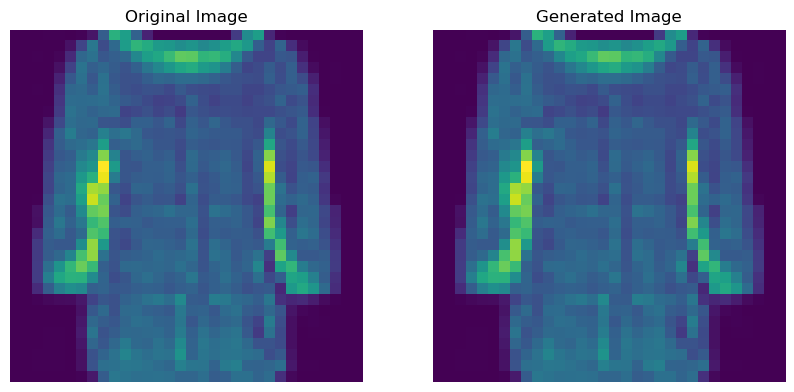

Epoch 78/100:  77%|███████▋  | 77/100 [21:53<06:35, 17.19s/it, loss=2.59e-7]

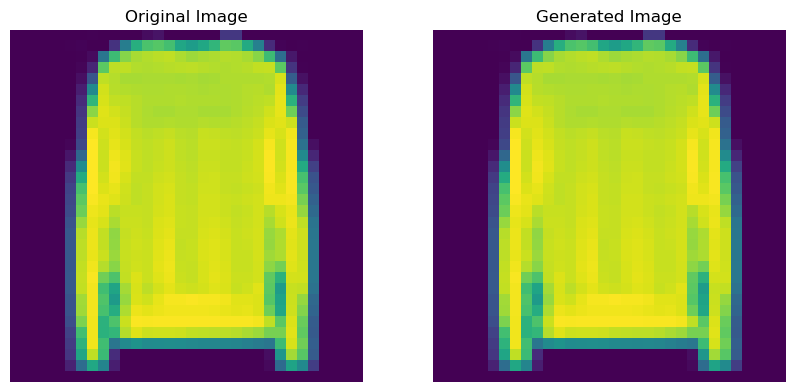

Epoch 78/100:  77%|███████▋  | 77/100 [22:03<06:35, 17.19s/it, loss=1.73e-7]

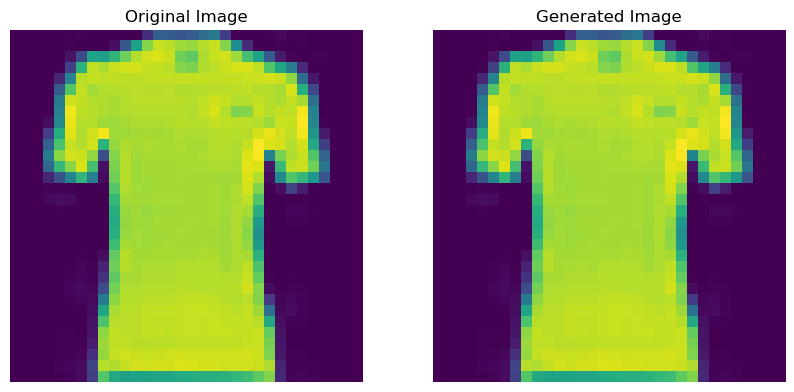

Epoch 79/100:  78%|███████▊  | 78/100 [22:11<06:18, 17.21s/it, loss=1.16e-7]

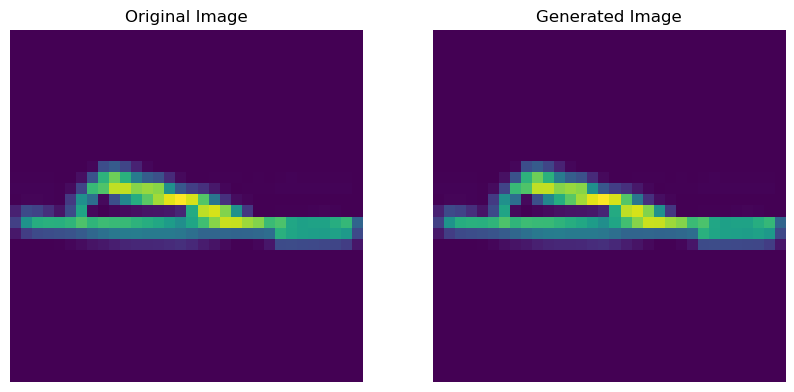

Epoch 79/100:  78%|███████▊  | 78/100 [22:20<06:18, 17.21s/it, loss=3.01e-7]

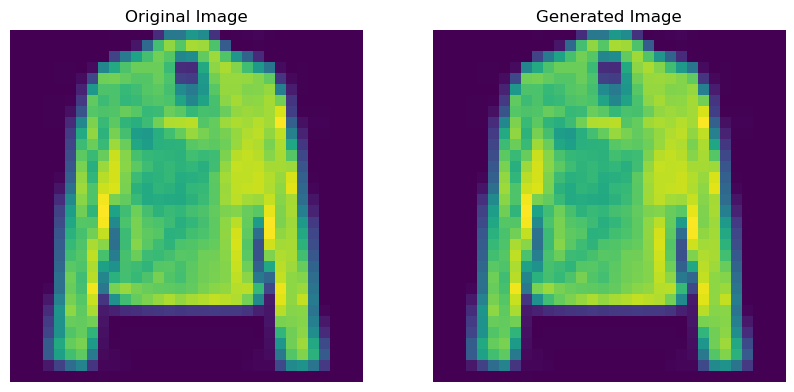

Epoch 80/100:  79%|███████▉  | 79/100 [22:28<06:01, 17.21s/it, loss=1.13e-7]

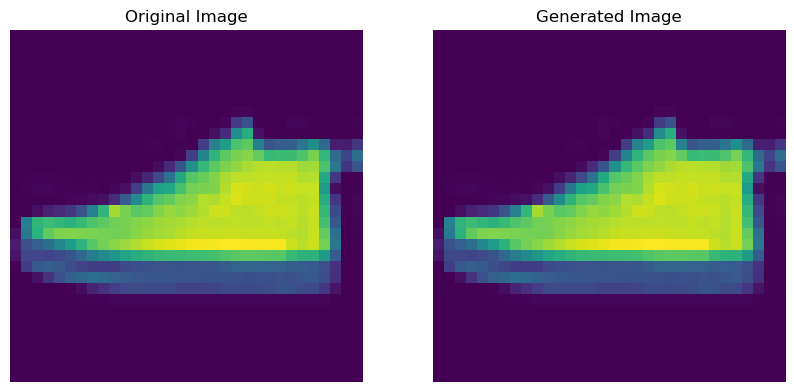

Epoch 80/100:  79%|███████▉  | 79/100 [22:37<06:01, 17.21s/it, loss=1.22e-7] 

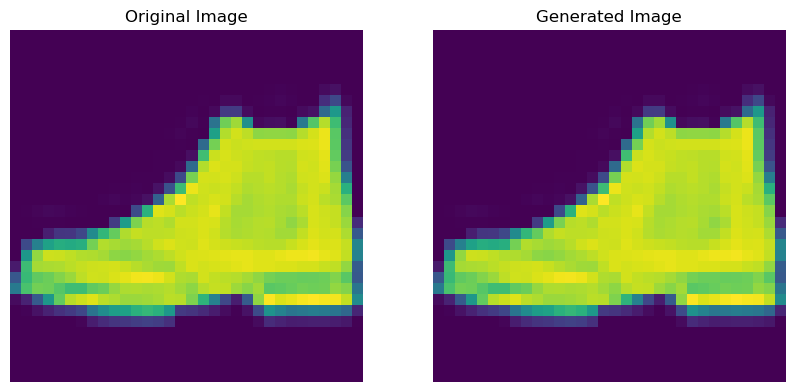

Epoch 81/100:  80%|████████  | 80/100 [22:45<05:44, 17.21s/it, loss=1.18e-7]

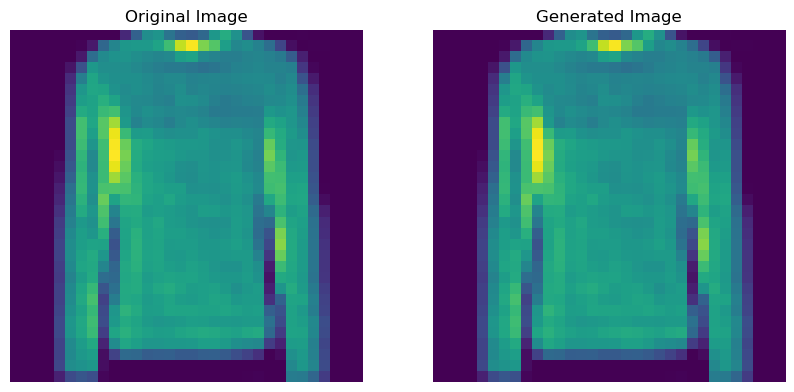

Epoch 81/100:  80%|████████  | 80/100 [22:54<05:44, 17.21s/it, loss=7.68e-8]

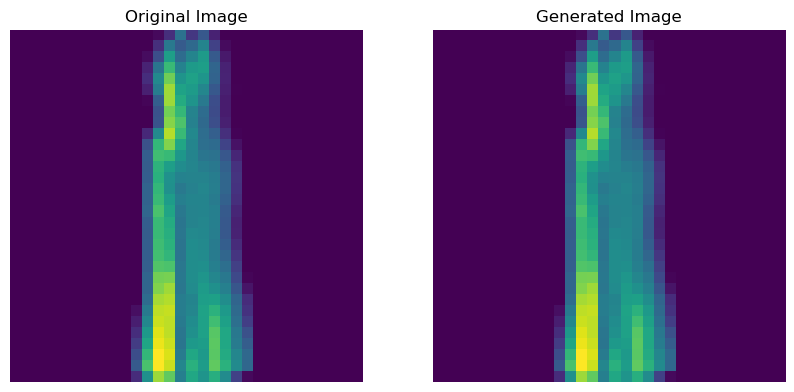

Epoch 82/100:  81%|████████  | 81/100 [23:02<05:25, 17.14s/it, loss=2.33e-7] 

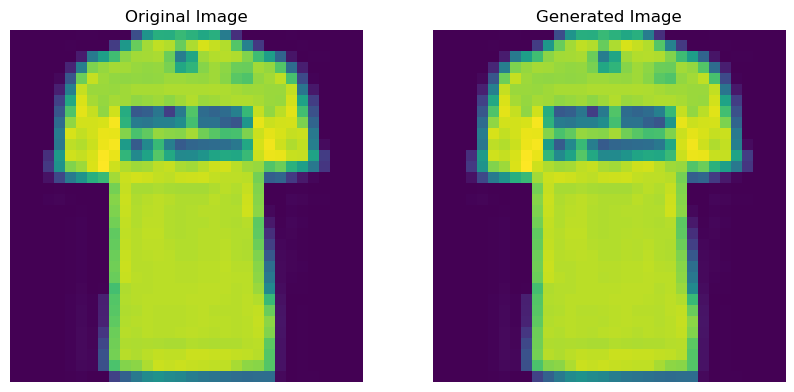

Epoch 82/100:  81%|████████  | 81/100 [23:11<05:25, 17.14s/it, loss=2.02e-7]

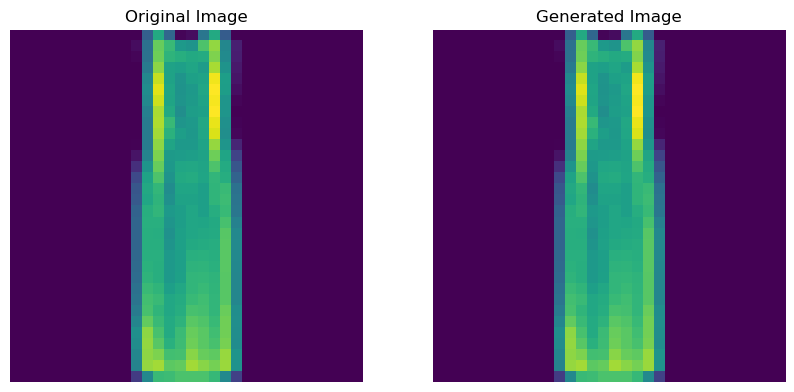

Epoch 83/100:  82%|████████▏ | 82/100 [23:19<05:07, 17.10s/it, loss=6.77e-8] 

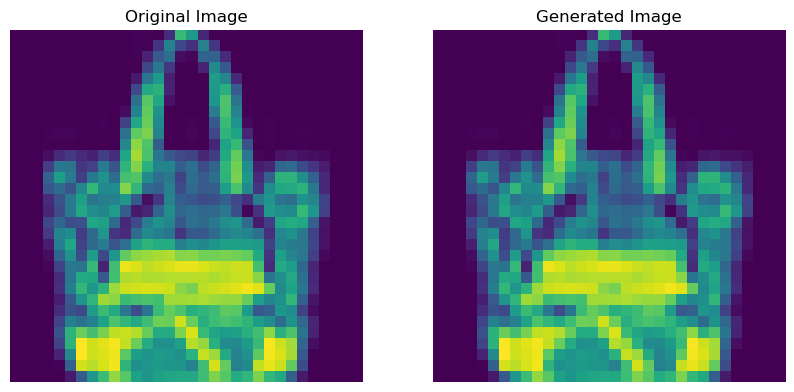

Epoch 83/100:  82%|████████▏ | 82/100 [23:28<05:07, 17.10s/it, loss=2.68e-7]

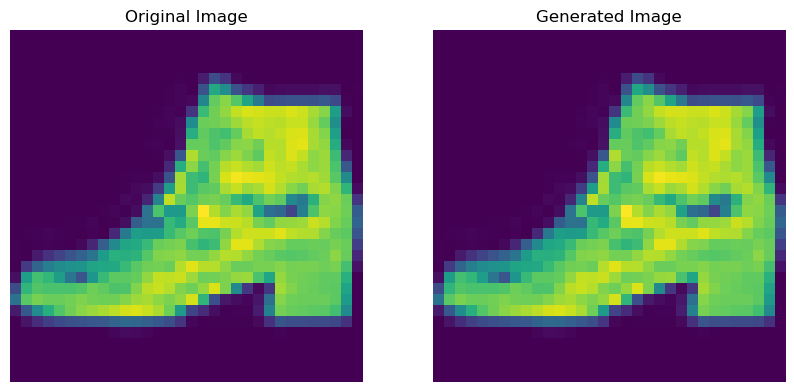

Epoch 84/100:  83%|████████▎ | 83/100 [23:36<04:49, 17.05s/it, loss=2.45e-7]

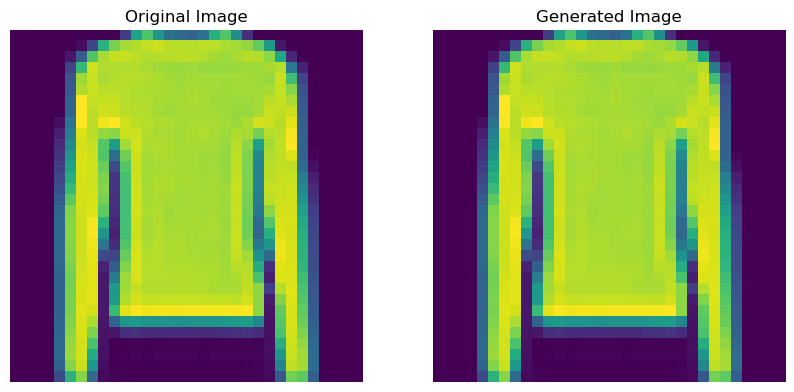

Epoch 84/100:  83%|████████▎ | 83/100 [23:45<04:49, 17.05s/it, loss=9.58e-8] 

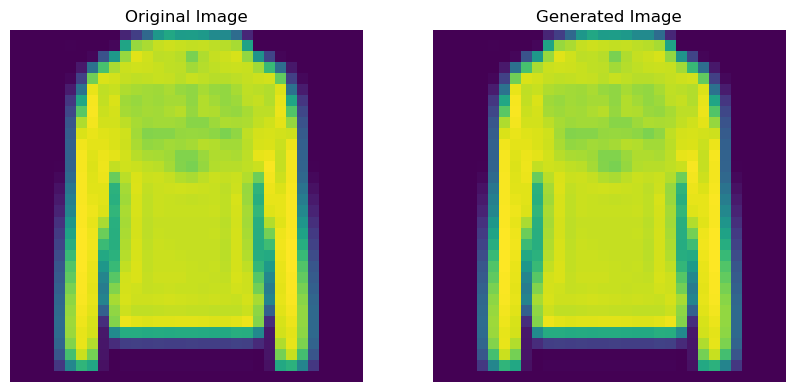

Epoch 85/100:  84%|████████▍ | 84/100 [23:53<04:33, 17.07s/it, loss=2.44e-8]

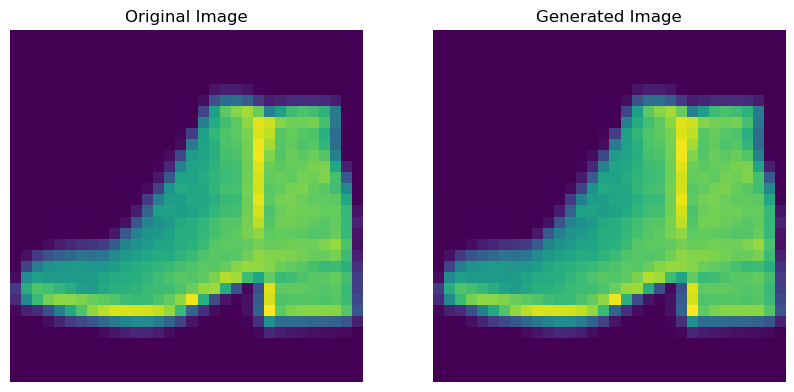

Epoch 85/100:  84%|████████▍ | 84/100 [24:02<04:33, 17.07s/it, loss=1.79e-7] 

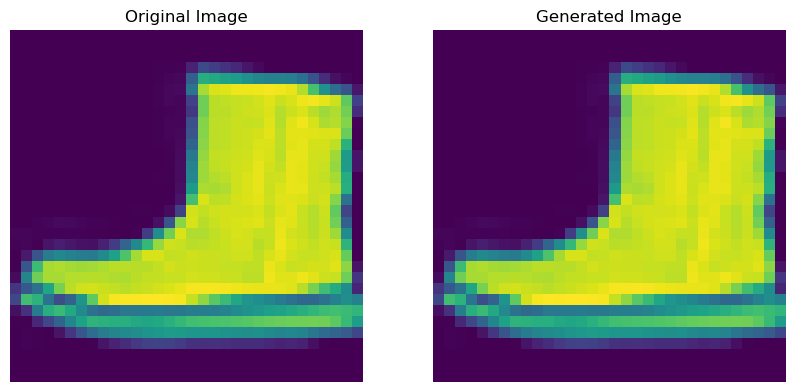

Epoch 86/100:  85%|████████▌ | 85/100 [24:10<04:15, 17.05s/it, loss=4.8e-7] 

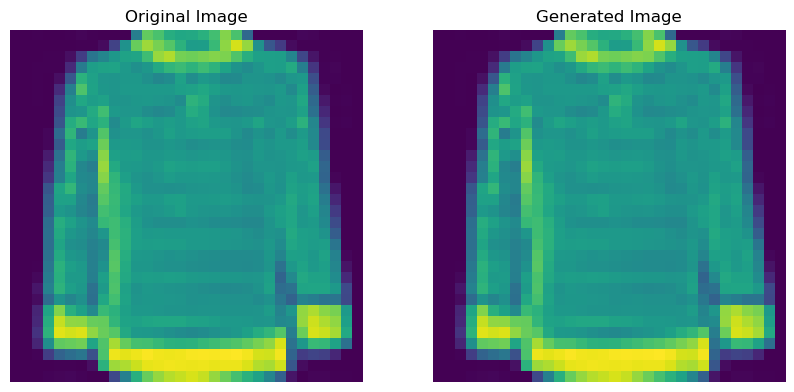

Epoch 86/100:  85%|████████▌ | 85/100 [24:19<04:15, 17.05s/it, loss=3.43e-8]

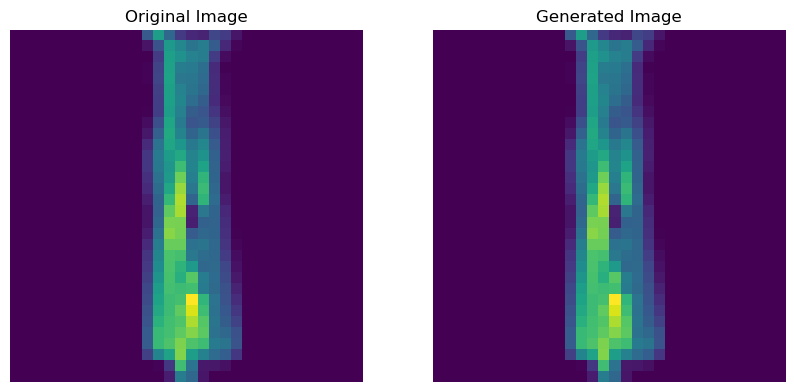

Epoch 87/100:  86%|████████▌ | 86/100 [24:27<03:59, 17.08s/it, loss=1.04e-6] 

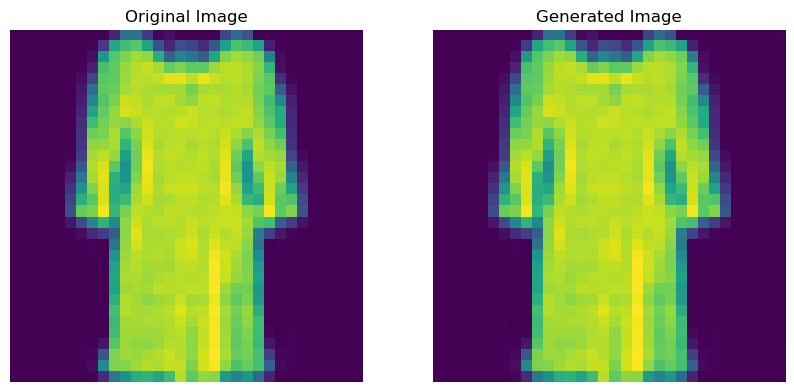

Epoch 87/100:  86%|████████▌ | 86/100 [24:36<03:59, 17.08s/it, loss=4.9e-7] 

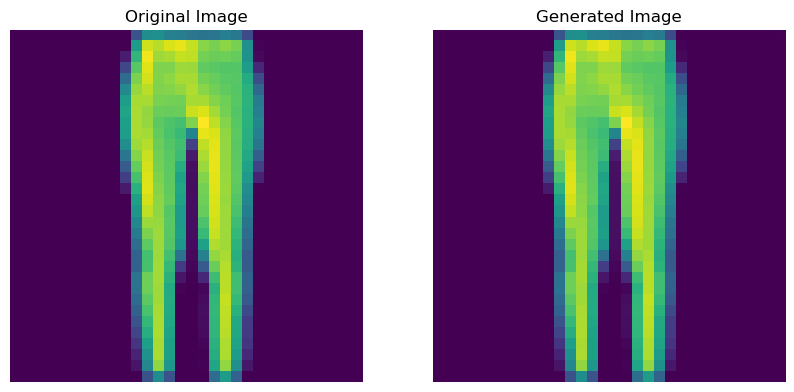

Epoch 88/100:  87%|████████▋ | 87/100 [24:44<03:42, 17.09s/it, loss=2.82e-7]

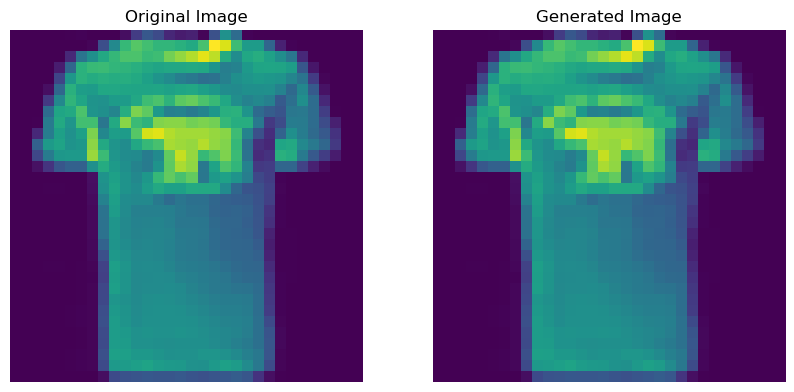

Epoch 88/100:  87%|████████▋ | 87/100 [24:53<03:42, 17.09s/it, loss=1.7e-7] 

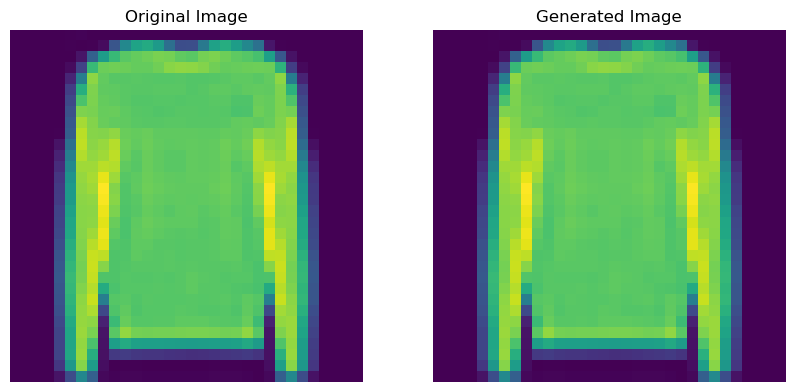

Epoch 89/100:  88%|████████▊ | 88/100 [25:01<03:25, 17.09s/it, loss=1.32e-7]

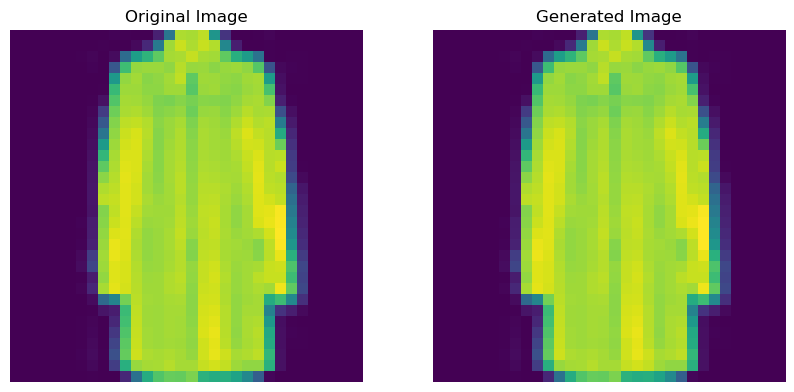

Epoch 89/100:  88%|████████▊ | 88/100 [25:11<03:25, 17.09s/it, loss=1.73e-7]

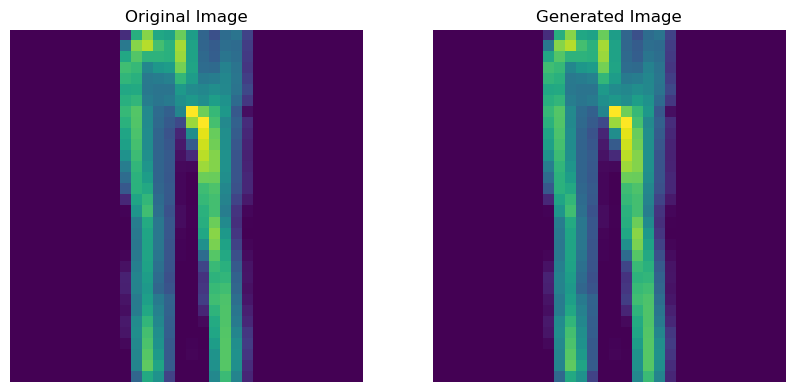

Epoch 90/100:  89%|████████▉ | 89/100 [25:18<03:07, 17.06s/it, loss=6.84e-8]

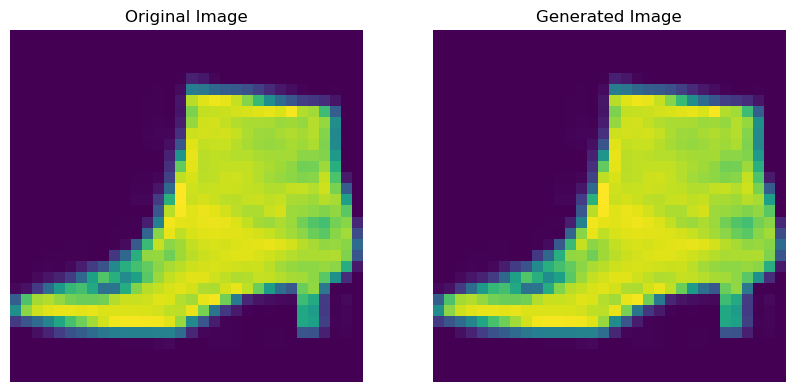

Epoch 90/100:  89%|████████▉ | 89/100 [25:27<03:07, 17.06s/it, loss=4.89e-8]

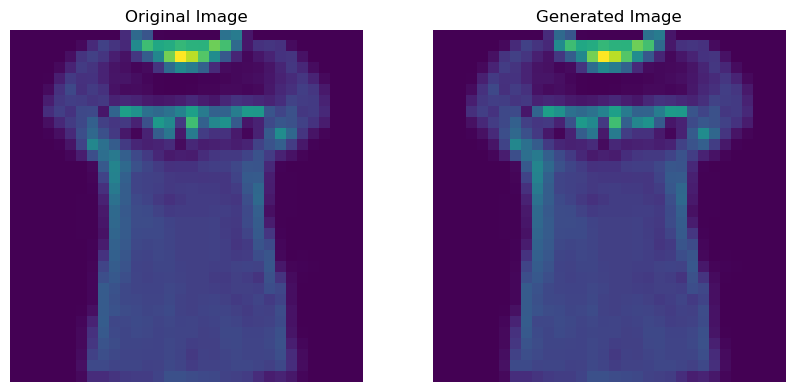

Epoch 91/100:  90%|█████████ | 90/100 [25:35<02:50, 17.05s/it, loss=2.13e-7] 

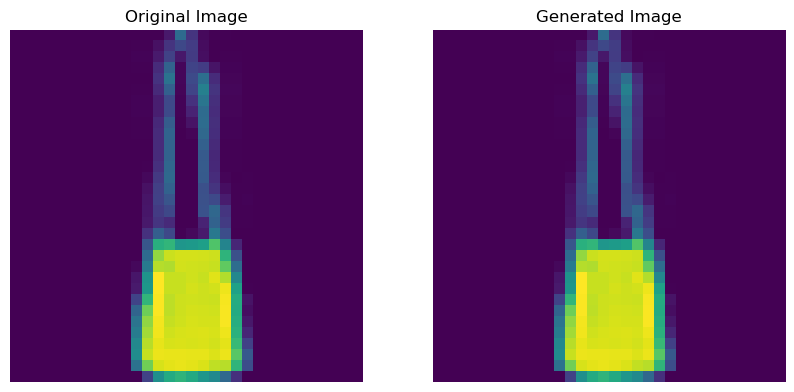

Epoch 91/100:  90%|█████████ | 90/100 [25:45<02:50, 17.05s/it, loss=4e-8]   

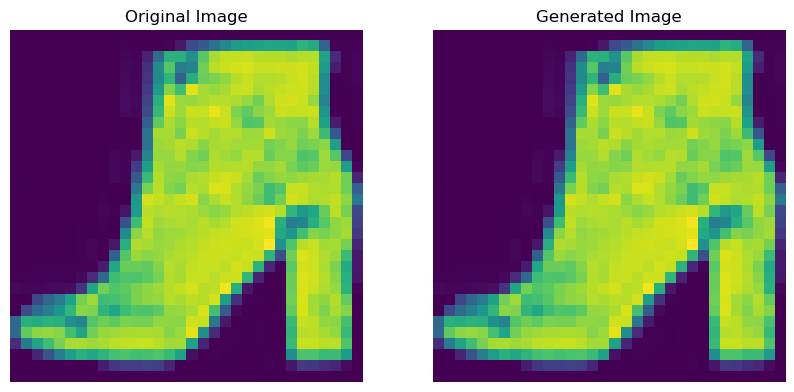

Epoch 92/100:  91%|█████████ | 91/100 [25:52<02:33, 17.03s/it, loss=5.74e-7]

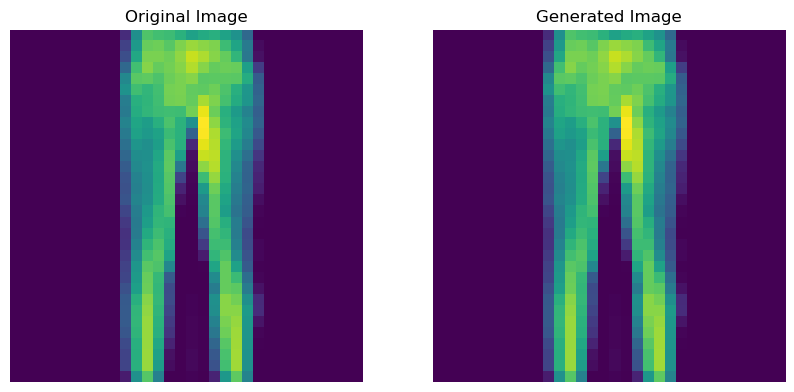

Epoch 92/100:  91%|█████████ | 91/100 [26:02<02:33, 17.03s/it, loss=1.45e-7]

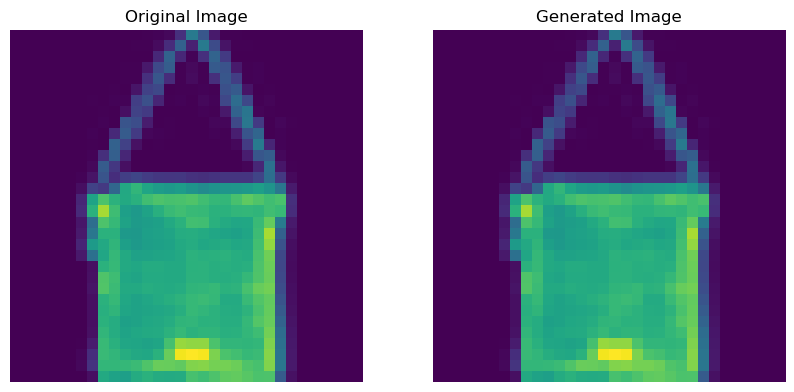

Epoch 93/100:  92%|█████████▏| 92/100 [26:09<02:16, 17.01s/it, loss=4.49e-8]

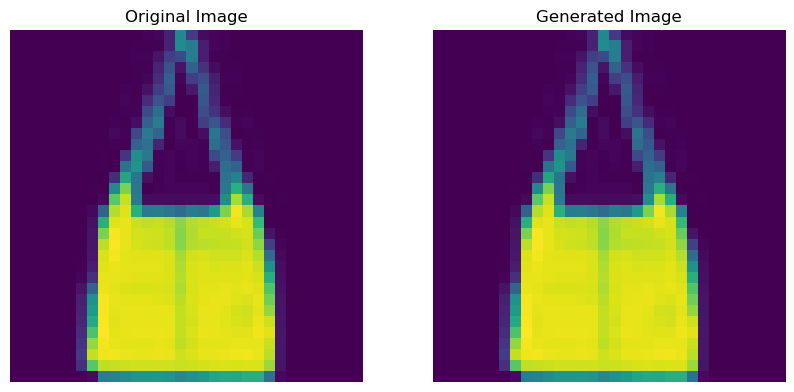

Epoch 93/100:  92%|█████████▏| 92/100 [26:19<02:16, 17.01s/it, loss=1.37e-7] 

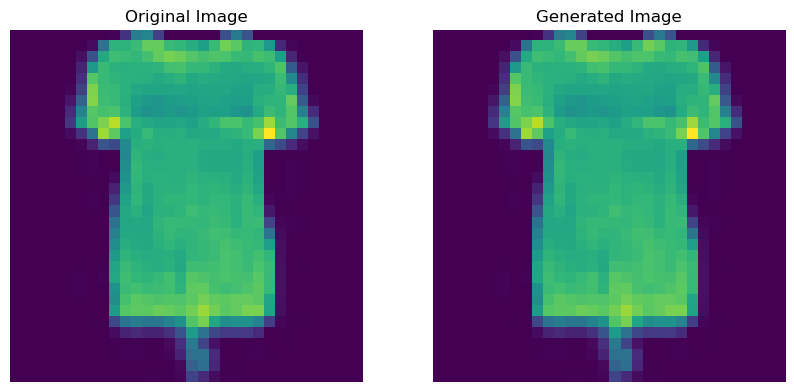

Epoch 94/100:  93%|█████████▎| 93/100 [26:27<01:59, 17.10s/it, loss=7.63e-7]

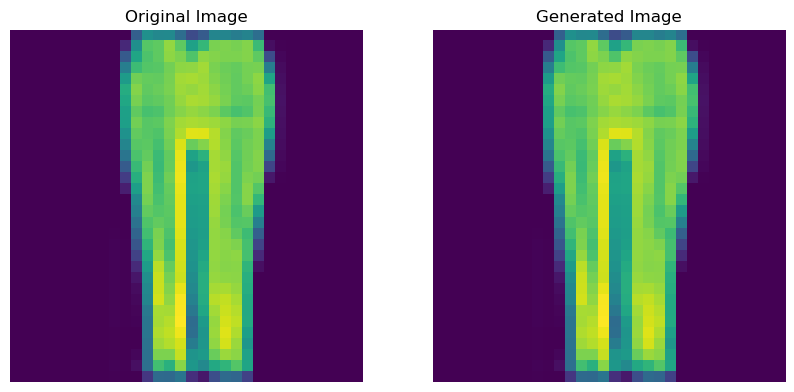

Epoch 94/100:  93%|█████████▎| 93/100 [26:36<01:59, 17.10s/it, loss=1.91e-7]

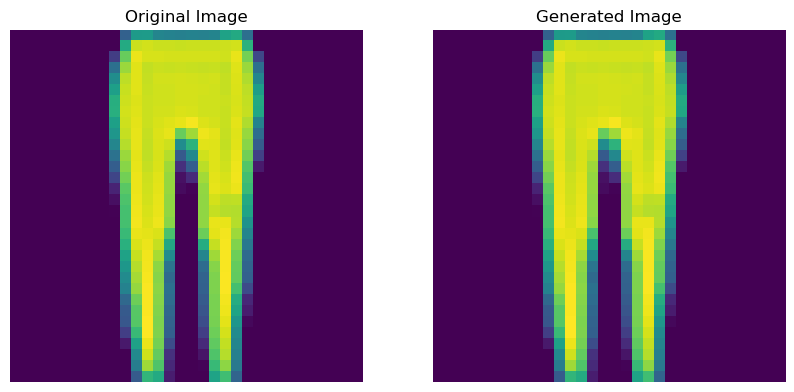

Epoch 95/100:  94%|█████████▍| 94/100 [26:44<01:43, 17.20s/it, loss=9.36e-7] 

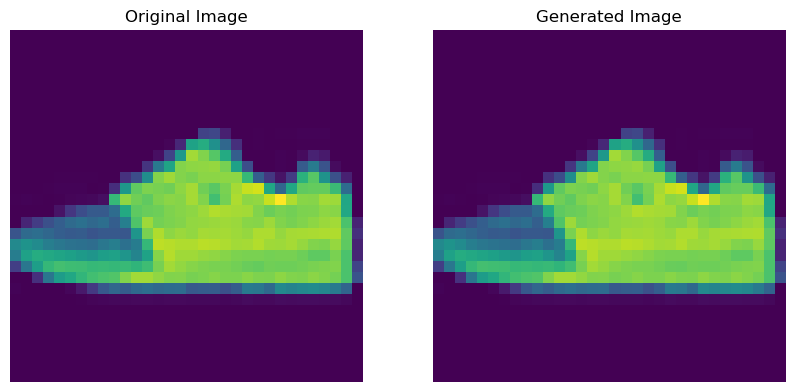

Epoch 95/100:  94%|█████████▍| 94/100 [26:53<01:43, 17.20s/it, loss=9.39e-8]

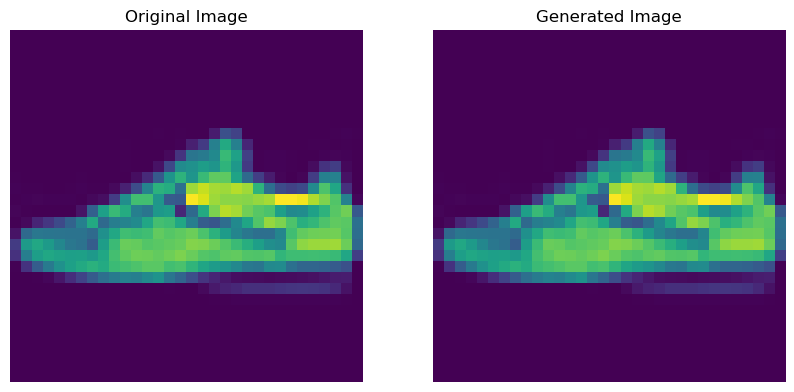

Epoch 96/100:  95%|█████████▌| 95/100 [27:01<01:25, 17.20s/it, loss=7.9e-7] 

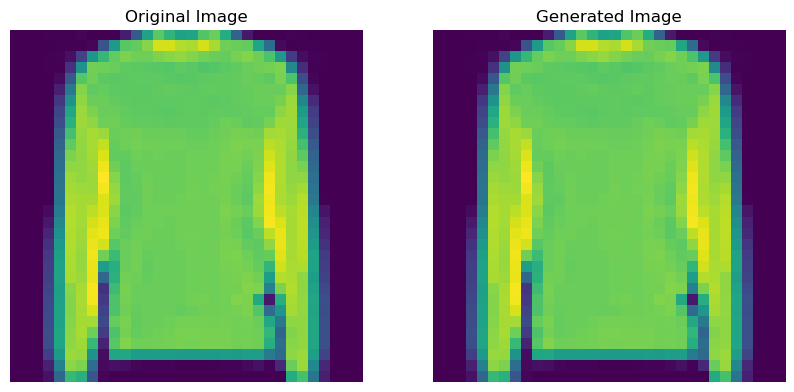

Epoch 96/100:  95%|█████████▌| 95/100 [27:10<01:25, 17.20s/it, loss=1.23e-6]

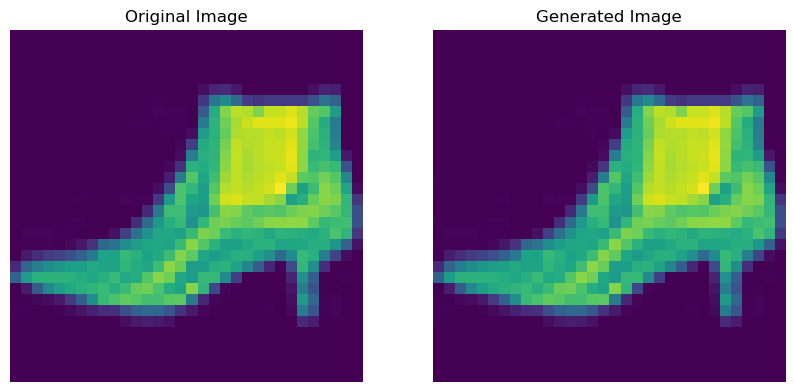

Epoch 97/100:  96%|█████████▌| 96/100 [27:18<01:08, 17.17s/it, loss=9.59e-7] 

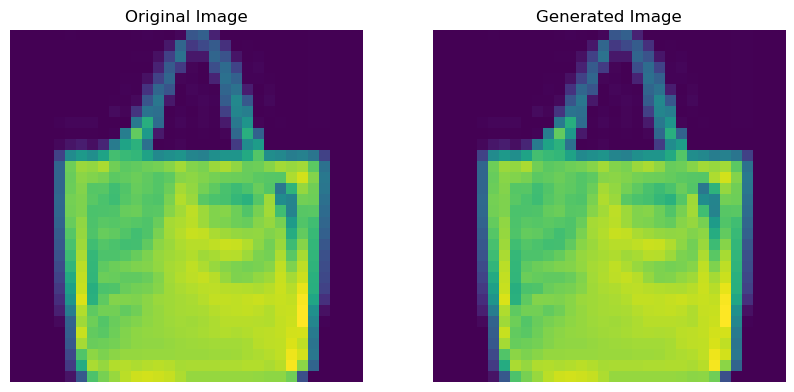

Epoch 97/100:  96%|█████████▌| 96/100 [27:28<01:08, 17.17s/it, loss=4.88e-6]

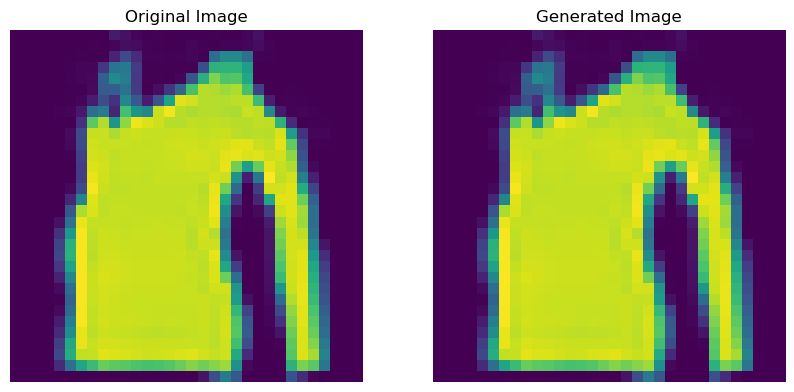

Epoch 98/100:  97%|█████████▋| 97/100 [27:36<00:51, 17.16s/it, loss=6.15e-8] 

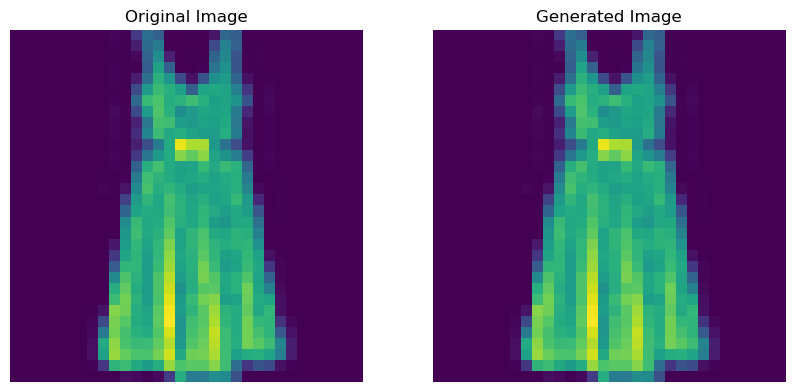

Epoch 98/100:  97%|█████████▋| 97/100 [27:45<00:51, 17.16s/it, loss=5.24e-8]

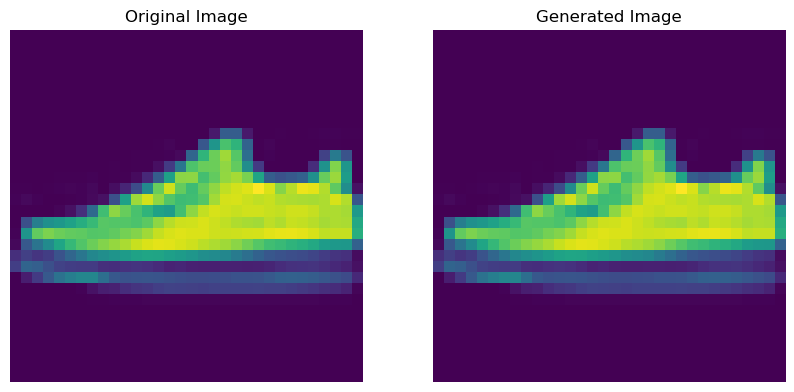

Epoch 99/100:  98%|█████████▊| 98/100 [27:53<00:34, 17.19s/it, loss=2.67e-6] 

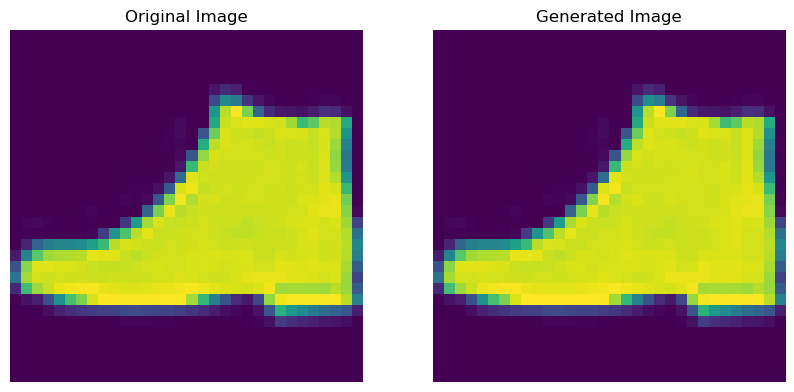

Epoch 99/100:  98%|█████████▊| 98/100 [28:02<00:34, 17.19s/it, loss=4.29e-7]

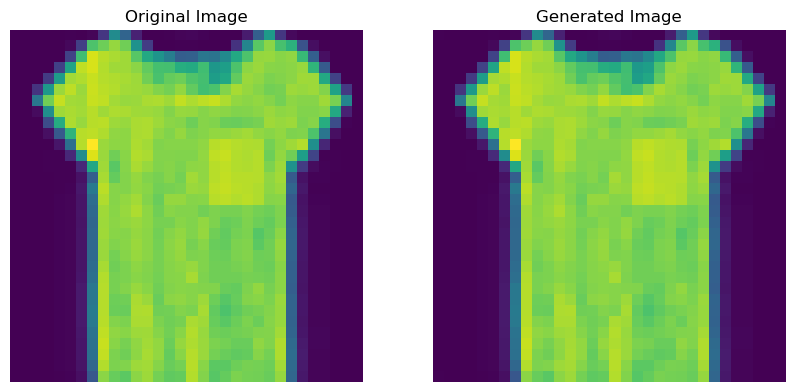

Epoch 100/100:  99%|█████████▉| 99/100 [28:10<00:17, 17.21s/it, loss=2.35e-7]

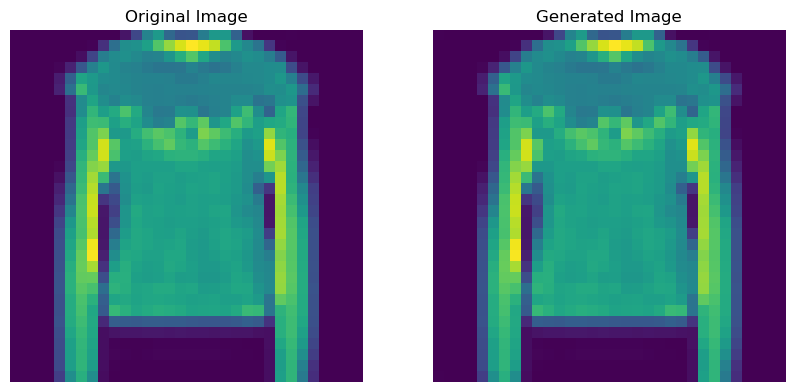

Epoch 100/100:  99%|█████████▉| 99/100 [28:19<00:17, 17.21s/it, loss=1.48e-7]

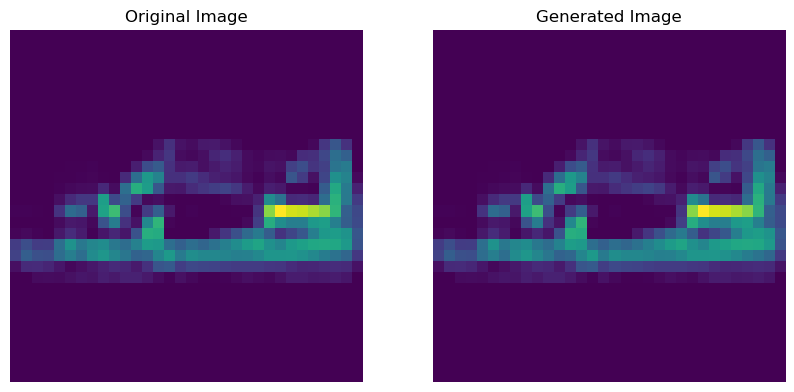

Epoch 100/100: 100%|██████████| 100/100 [28:27<00:00, 17.08s/it, loss=1.39e-7]


In [29]:
def tensor_to_image(tensor):
    tensor = tensor.detach()  # Detach tensor from computation graph
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return image

# Initialize progress bar
pb = trange(NO_EPOCHS, desc='Epoch 0/0', position=0, leave=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet.to(device)

# Training loop
for epoch in pb:
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        t = torch.randint(0, 20, (x.shape[0],), device=device)
        x_hat = unet(x, t)
        loss = torch.nn.functional.mse_loss(x_hat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar description and postfix
        pb.set_description(f'Epoch {epoch + 1}/{NO_EPOCHS}')
        pb.set_postfix(loss=loss.item())
        
        # Every 50 images, show an example
        if i % 500 == 0:
            # Take one example from the batch
            example_image = x[0].cpu()
            example_image_hat = x_hat[0].cpu()
            
            # Convert tensors to images
            example_image_np = tensor_to_image(example_image)
            example_image_hat_np = tensor_to_image(example_image_hat)
            
            # Plot original and generated image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title('Original Image')
            plt.imshow(example_image_np)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title('Generated Image')
            plt.imshow(example_image_hat_np)
            plt.axis('off')
            
            plt.show()

In [31]:
# plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

NameError: name 'losses' is not defined

In [32]:
# Save the model
torch.save(unet.state_dict(), '../models/unet.pth')

In [ ]:
# https://github.com/dtransposed/code_videos/blob/main/01_Diffusion_Models_Tutorial/Diffusion%20Model.ipynb